## **Data Mining Project - Deliverable 2**

Done by:

Student Name 1: Catarina Mendinhas   
Student ID 1: 20250422

Student Name 2: Bárbara Franco  
Student ID 2: 20250388

Student Name 3: Khadija Ennaifer   
Student ID 3: 20250439

This project's goal is to analyze customer loyalty membership data of AIAI and corresponding flight activity collected over a three-year period. This Deliverable will focus on the implementation of several clustering techniques. We will redo the treatment of the data and the merging done in the previous deliverable. Enconding, Scalling and Feature Selection will follow. Different clustering techniques will be explored for multiple perspectives, and a final clustering strategy will be chosen. Finally we will obtain a solution that supports the business' needs.

## **Table of Contents**

- [1. Importing Libraries, Loading and Reading Data](#1-loading-and-reading-data)

## **1. Importing Libraries, Loading and Reading Data**

In [1]:
#!pip install minisom

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from dateutil.relativedelta import relativedelta
from math import ceil

from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.cluster import MeanShift, DBSCAN, HDBSCAN, estimate_bandwidth, AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score,silhouette_samples
from pandas.plotting import parallel_coordinates

from minisom import MiniSom
from matplotlib import colors as mpl_colors
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable


import warnings
warnings.filterwarnings('ignore')


In [3]:
# Read the and import the files
customerDB = pd.read_csv('DM_AIAI_CustomerDB.csv')
flightsDB = pd.read_csv('DM_AIAI_FlightsDB.csv')

## **2. Data Preparation**

### **2.1 Treatment of Duplicates and Missing Values**

This section has already been done in the previous deliverable, so we will only offer a short explanation of the procedures.

Drop the 20 observations that are duplicated in the column 'Unnamed: 0'. These were the last 20 observations of the dataset customersDB and they correspond exactly to the missing values in 'Income' and 'Customer Lifetime Value'. These clients entered and exited the program in the same day ( 'Cancellation Date' is the same as 'Enrollment Date Opening') and as expected they have no corresponding observations in the flights dataset. They won't bring valuable information so we will drop them from the customers dataset.

In [4]:
unnamed_duplicates = customerDB[customerDB.duplicated(subset='Unnamed: 0')]
customers_incorrect_index = unnamed_duplicates.index
customerDB.drop(customers_incorrect_index, inplace=True)

1.9% of the customers identification ('Loyalty#') are duplicated, but they represent different clients since the values on the other columns differ. These identifiers are also duplicated in the flights dataset. Since there wasn't a clear way to separate the customers, they represent a small part of the data, and we didn't want to introduce incorrect information to the data, we decided to drop these customers in both datasets.

In [5]:
duplicated_customers = customerDB[customerDB.duplicated(subset='Loyalty#', keep = False)]
customerDB.drop(duplicated_customers.index, inplace=True)
flightsDB.drop(flightsDB[flightsDB['Loyalty#'].isin(duplicated_customers['Loyalty#'])].index, inplace = True)

### **2.2 Rounding, Typecasting, and Datetime Conversion**

The columns 'NumFlightsWithCompanions' and 'NumFlights' are of the type float when logically they should be integers. They represent more than 15% of the flights' data so dropping them is not an option and there does not seem to exist an explanation for these errors, so we will simply round them and typecast them into integers.

In [6]:
flightsDB['NumFlights'] = flightsDB['NumFlights'].round().astype(int)

The columns 'YearMonthDate' from flightsDB and 'EnrollmentDateOpening' and 'CancellationDate' from customerDB will be converted to datetime since they represent dates.

In [7]:
flightsDB['YearMonthDate'] = pd.to_datetime(flightsDB['YearMonthDate'])
customerDB['EnrollmentDateOpening'] = pd.to_datetime(customerDB['EnrollmentDateOpening'], dayfirst = False)
customerDB['CancellationDate'] = pd.to_datetime(customerDB['CancellationDate'], format='mixed', errors='coerce')

### **2.3 Fixing Inconsistencies**

#### **2.3.1 Cancellation Date before Enrollment Date** 

In Deliverable 1, some quality issues were assessed, namely there were 199 customers who had a cancellation date prior to their enrollment date. The only explanations we found were that the dates had been switched or they could have been typed wrong. However since we dont want to lose any costumers info and have no other way to impute this value, we will believe the first assumption and switch the dates. We will create a copy of the a copy of the customers dataset and we will fix this and other inconsistencies in it. 

In [8]:
customers_cleaned = customerDB.copy()
cancel_before_enrol = customers_cleaned['CancellationDate'] < customers_cleaned['EnrollmentDateOpening']
customers_cleaned.loc[cancel_before_enrol, ['EnrollmentDateOpening', 'CancellationDate']] = \
    customers_cleaned.loc[cancel_before_enrol, ['CancellationDate', 'EnrollmentDateOpening']].values
# Selects the rows of the clients that have cancellation date before enrollment date and swap the two dates

#### **2.3.2 Months with zero flights but with distance**

Now for the flights data set, we found that there were 5823 observations that had 0 for the column 'NumFlights' but with values in 'DistanceKM' different from 0, which is not logical. 

In [9]:
no_flights_with_distance = flightsDB[(flightsDB['DistanceKM'] != 0) & (flightsDB['NumFlights'] == 0)]
no_flights_with_distance

Loyalty#  Year  ...  PointsRedeemed DollarCostPointsRedeemed
19        261109  2021  ...             0.0                      0.0
93        817609  2021  ...             0.0                      0.0
96        192600  2021  ...             0.0                      0.0
116       883242  2021  ...             0.0                      0.0
154       493800  2021  ...             0.0                      0.0
...          ...   ...  ...             ...                      ...
607387    944702  2019  ...             0.0                      0.0
607549    952629  2019  ...             0.0                      0.0
607594    954973  2019  ...             0.0                      0.0
607744    962989  2019  ...             0.0                      0.0
607912    970783  2019  ...             0.0                      0.0

[5823 rows x 10 columns]

In [10]:
len(no_flights_with_distance) / len(flightsDB)

0.009759261493906117

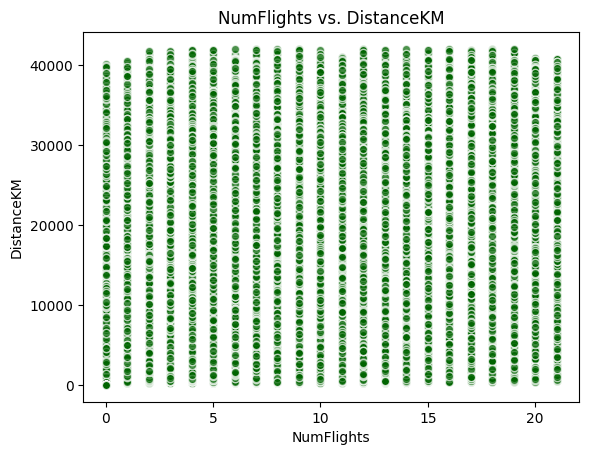

In [11]:
plt.scatter(flightsDB['NumFlights'], flightsDB['DistanceKM'], 
            color='darkgreen',  
            edgecolors='white',    
            alpha=0.7)            

plt.xlabel("NumFlights")
plt.ylabel("DistanceKM")

plt.title("NumFlights vs. DistanceKM") 
plt.show()

There is not a clear relationship between these features. It corresponds to less than 1% of the dataset and there is not a correct way to impute this values, so we will drop them.

In [12]:
flights_cleaned = flightsDB.copy()
flights_cleaned.drop(no_flights_with_distance.index, inplace=True)

### **2.4 Feature Engineering and Merging of the Datasets**

In order to segment the customers, it is crucial that we create new features and merge both datasets so that we can choose the most insightful features for the clustering algorithms.

#### **2.4.1 Feature in the flights dataset - Season**

We will create a new feature called 'Season' that assigns each observation to the season corresponding to its date. This variable could be really insightful to undersand and segment customers behavior (seasionality)

In [13]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

flights_cleaned['Season'] = flights_cleaned['Month'].apply(get_season)
flights_cleaned.head()

Loyalty#  Year  Month  ... PointsRedeemed  DollarCostPointsRedeemed  Season
0    413052  2021     12  ...            0.0                       0.0  Winter
1    464105  2021     12  ...            0.0                       0.0  Winter
2    681785  2021     12  ...            0.0                       0.0  Winter
3    185013  2021     12  ...         3213.0                      32.0  Winter
4    216596  2021     12  ...            0.0                       0.0  Winter

[5 rows x 11 columns]

#### **2.4.2 Dates**

We will start merging the datasest so we will create a new dataset called customers_merged.

On the previous deliverable, we showed that there are customers with flight activity before the enrollment date. For this reason we will alter 'EnrollmentDateOpening' so that the date of the first flight will be their new enrollment date if their first flight happen before they enrolled. We will start by extracting from flights_cleaned the first date with flight activity for each customer and then merge it with the customers' information

In [14]:
customers_cleaned.head()

Unnamed: 0  Loyalty#  ... Customer Lifetime Value  EnrollmentType
0           0    480934  ...                 3839.14        Standard
2           1    549612  ...                 3839.61        Standard
4           2    429460  ...                 3839.75        Standard
6           3    608370  ...                 3839.75        Standard
8           4    530508  ...                 3842.79  2021 Promotion

[5 rows x 21 columns]

In [15]:
first_flight_date = flights_cleaned[flights_cleaned['NumFlights'] > 0].sort_values(by=['Loyalty#','YearMonthDate'], ascending=True).groupby("Loyalty#", as_index=False)[['Loyalty#','YearMonthDate']].first()
customers_merged = pd.merge(customers_cleaned, first_flight_date, on='Loyalty#', how='left')
customers_merged.rename(columns={'YearMonthDate': 'FirstFlightDate'}, inplace=True)
customers_merged['FirstFlightDate'] = pd.to_datetime(customers_merged['FirstFlightDate'], format='%Y-%m')
customers_merged.head()

Unnamed: 0  Loyalty#  ...  EnrollmentType FirstFlightDate
0           0    480934  ...        Standard      2019-02-01
1           1    549612  ...        Standard      2019-01-01
2           2    429460  ...        Standard      2019-01-01
3           3    608370  ...        Standard      2019-01-01
4           4    530508  ...  2021 Promotion      2019-02-01

[5 rows x 22 columns]

In [16]:
customers_merged['FirstFlightDate'].isnull().sum()

np.int64(1473)

In [17]:
no_flights = customers_merged[customers_merged['FirstFlightDate'].isnull()]
no_flights.head()

Unnamed: 0  Loyalty#  ...  EnrollmentType FirstFlightDate
30          31    201574  ...        Standard             NaT
38          39    834891  ...        Standard             NaT
66          67    329382  ...  2021 Promotion             NaT
71          72    357549  ...        Standard             NaT
82          83    283314  ...        Standard             NaT

[5 rows x 22 columns]

In [18]:
len(no_flights) / len(customers_merged) * 100

8.887414021962108

There are null values for this new column. This means that these customers havent travelled since they entered the program. They form more than 8 % of AIAI's customers, so we will not remove them. These entries also do not affect the problem we are trying to solve, which is customers that **travelled** before they enrolled. 

We will now transform the column 'EnrollmentDateOpening' so that it is the minimum between the customers's enrollment date and date of the first flight.

In [19]:
customers_merged['EnrollmentDateOpening'] = customers_merged[['EnrollmentDateOpening', 'FirstFlightDate']].min(axis=1)
customers_merged.head()

Unnamed: 0  Loyalty#  ...  EnrollmentType FirstFlightDate
0           0    480934  ...        Standard      2019-02-01
1           1    549612  ...        Standard      2019-01-01
2           2    429460  ...        Standard      2019-01-01
3           3    608370  ...        Standard      2019-01-01
4           4    530508  ...  2021 Promotion      2019-02-01

[5 rows x 22 columns]

To properly analyse the customers' flight activity we will create a Start Date and and End Date for each customer. The Start Date will be the enrollment date if it happen in the 3 year span of the flights dataset, otherwise it will be the first date of that interval. The End Date will be the end of the 3 year interval if the Cancellation Date is null, otherwise it will be the Cancellation Date if it happens in the span of the flights dataset activity or the Start Date if it does not. This way we can count the number of months where the customers were enrolled in the program and calculate proportions per month. 

In [20]:
customers_merged['Analysis_Start_Date'] = customers_merged['EnrollmentDateOpening'].apply(lambda x: max(x, pd.Timestamp('2019-01-01')))
# Analysis_Start_Date is the later date between EnrollmentDateOpening and 2019-01-01

customers_merged['Analysis_End_Date'] = np.where(
    customers_merged['CancellationDate'].notna(),  # has caccellation date
    np.where(
        customers_merged['CancellationDate'] < customers_merged['Analysis_Start_Date'],
        customers_merged['Analysis_Start_Date'],  # If the cancelation date is before the Start_Date then use Start_Date
        customers_merged['CancellationDate']  # otherwise use the cancellation date
    ),
    pd.Timestamp('2021-12-01')  # if its NaT then use 2021-12-01
)
customers_merged['Analysis_End_Date'] = pd.to_datetime(customers_merged['Analysis_End_Date'])

# Months in the program in the interval of the flights data set
customers_merged['Months_In_Program'] = (
    (customers_merged['Analysis_End_Date'].dt.year - customers_merged['Analysis_Start_Date'].dt.year) * 12 +
    (customers_merged['Analysis_End_Date'].dt.month - customers_merged['Analysis_Start_Date'].dt.month)
)

end_date = pd.Timestamp('2021-12-01')
end_or_cancel = customers_merged['CancellationDate'].fillna(end_date) 
# we can not use Analysis_End_Date here because if the cancellation date is before the start date we want to use the cancellation date

# Months since enrollment to end or cancellation date
customers_merged['Months_Since_Enrollment'] = (
    (end_or_cancel.dt.year - customers_merged['EnrollmentDateOpening'].dt.year) * 12 +
    (end_or_cancel.dt.month - customers_merged['EnrollmentDateOpening'].dt.month)
)

# Analysis Start and End Dates were only auxiliary columns for calculations, so we can drop them now
customers_merged.drop(columns=['Analysis_Start_Date', 'Analysis_End_Date'], inplace=True)
customers_merged.head()



Unnamed: 0  Loyalty#  ... Months_In_Program Months_Since_Enrollment
0           0    480934  ...                34                      34
1           1    549612  ...                35                      35
2           2    429460  ...                24                      42
3           3    608370  ...                35                      70
4           4    530508  ...                35                      50

[5 rows x 24 columns]

#### **2.4.3 Total Flights and Points, Racios and Mean Distance Per Flight**

Now we will group the flights information by the customer identifiers and do some operations to ceartain features in order to get good insights on customer behavior. We will sum the number of flight with or withou companions, points accumulated and points redeemed, all for each customer. We will also extract the maximum number of flight with or without company, in a single month.

In [21]:
info_to_merge = flightsDB.groupby('Loyalty#')[['NumFlights', 'NumFlightsWithCompanions', 'PointsAccumulated', 'PointsRedeemed']].sum()

info_to_merge['NumFlights_Max'] = flightsDB.groupby('Loyalty#')[['NumFlights']].max()
info_to_merge['NumFlightsWithCompanions_Max'] = flightsDB.groupby('Loyalty#')[['NumFlightsWithCompanions']].max()


info_to_merge = info_to_merge.rename(columns={
    'NumFlights': 'TotalFlights',
    'NumFlightsWithCompanions': 'TotalFlightsWithCompanions',
    'PointsAccumulated': 'TotalPoints',
    'PointsRedeemed': 'TotalPointsRedeemed'})

info_to_merge.head()

TotalFlights  ...  NumFlightsWithCompanions_Max
Loyalty#                ...                              
100018             231  ...                           7.0
100102             248  ...                           8.0
100140             217  ...                           8.0
100214             112  ...                           7.0
100272             187  ...                           9.0

[5 rows x 6 columns]

It will also be interesting to have the racio of flights with companions and the racio of points redemeed to see which costumers tend to fly with company and which have a habit of redeeming their points.

In [22]:
info_to_merge['Ratio_Flights_Companions'] = info_to_merge['TotalFlightsWithCompanions'] / info_to_merge['TotalFlights']

info_to_merge['Ratio_Points_Redeemed'] = info_to_merge['TotalPointsRedeemed'] / info_to_merge['TotalPoints']

info_to_merge.head()


TotalFlights  ...  Ratio_Points_Redeemed
Loyalty#                ...                       
100018             231  ...               0.387873
100102             248  ...               0.553345
100140             217  ...               0.113353
100214             112  ...               0.354109
100272             187  ...               0.253564

[5 rows x 8 columns]

There are people who like to travel far away, and others who do not. We will extract this information by calculationg the mean distance per flight for each customer.

In [23]:
customers_with_flights = flightsDB[flightsDB['NumFlights'] != 0]

info_to_merge['MeanDistancePerFlight'] = customers_with_flights.groupby('Loyalty#')['DistanceKM'].sum() / customers_with_flights.groupby('Loyalty#')['NumFlights'].sum()

info_to_merge.head()

TotalFlights  ...  MeanDistancePerFlight
Loyalty#                ...                       
100018             231  ...            2295.367965
100102             248  ...            1367.397581
100140             217  ...            1990.925346
100214             112  ...            3255.372321
100272             187  ...            2297.489305

[5 rows x 9 columns]

Finally, we can add all this information to the corresponding customer by merging it with the customers_merged dataset

In [24]:
customers_merged = pd.merge(customers_merged, info_to_merge, on = 'Loyalty#', how='left')
customers_merged[['MeanDistancePerFlight', 'Ratio_Flights_Companions', 'Ratio_Points_Redeemed']] = customers_merged[['MeanDistancePerFlight', 'Ratio_Flights_Companions', 'Ratio_Points_Redeemed']].fillna(0)

customers_merged.head()

Unnamed: 0  Loyalty#  ... Ratio_Points_Redeemed MeanDistancePerFlight
0           0    480934  ...              0.266628           2604.054450
1           1    549612  ...              0.526282           1397.630466
2           2    429460  ...              0.229922           1915.185833
3           3    608370  ...              0.423144           1969.537245
4           4    530508  ...              0.000000           2143.935673

[5 rows x 33 columns]

#### **2.4.4 Proportions**

It would not be a fair to compare the total number of flights between a customer who has only entered the program 2 months ago and one that has been in the program since the beggining of the 3 year interval. For this reason, we will create several features with proportion of feature X per month, considering only the number of months where they were in the program.

In [25]:
customers_merged['PropNrFlights'] = np.where(
    customers_merged['Months_In_Program'] == 0,
    0,  
    customers_merged['TotalFlights'] / customers_merged['Months_In_Program'])

customers_merged['PropNrFlightsWithCompanions'] = np.where(
    customers_merged['Months_In_Program'] == 0,
    0, 
    customers_merged['TotalFlightsWithCompanions'] / customers_merged['Months_In_Program'])

customers_merged['PropCLV'] = np.where(
    customers_merged['Months_In_Program'] == 0,
    0,  
    customers_merged['Customer Lifetime Value'] / customers_merged['Months_In_Program'])

customers_merged['PropPoints'] = np.where(
    customers_merged['Months_In_Program'] == 0,
    0,  
    customers_merged['TotalPoints'] / customers_merged['Months_In_Program'])

customers_merged['PropPointsRedem'] = np.where(
    customers_merged['Months_In_Program'] == 0,
    0,  
    customers_merged['TotalPointsRedeemed'] / customers_merged['Months_In_Program'])

customers_merged.head()

Unnamed: 0  Loyalty# First Name  ...     PropCLV   PropPoints PropPointsRedem
0           0    480934    Cecilia  ...  112.915882  1491.158529      397.585294
1           1    549612      Dayle  ...  109.703143  1219.215429      641.651429
2           2    429460     Necole  ...  159.989583   993.017083      228.316667
3           3    608370      Queen  ...  109.707143  1102.732286      466.614286
4           4    530508     Claire  ...  109.794000  1054.758857        0.000000

[5 rows x 38 columns]

#### **2.4.5 Diversity and Most Frequent Season, Recency and Churn Status**

We already created a feature Season in flights_cleaned. Now we only need to associate it with each costumer. For that we will create 2 new features, one corresponding to the most frequent season and another one showing the amount of seasons each customer traveled in. 

In [26]:
Mode_Season = flights_cleaned[flights_cleaned['NumFlights'] != 0].groupby('Loyalty#')['Season'].agg(lambda x: x.mode()[0])
Diversity_Season = flights_cleaned[flights_cleaned['NumFlights'] != 0].groupby('Loyalty#')['Season'].nunique()
Diversity_Season.value_counts()

Season
4    12681
3     1134
2      789
1      497
Name: count, dtype: int64

Now we will merge them with the customers' information

In [27]:
customers_merged = pd.merge(customers_merged, Mode_Season, on='Loyalty#', how='outer')
customers_merged = pd.merge(customers_merged, Diversity_Season, on='Loyalty#', how='outer')
customers_merged.rename(columns={ 'Season_x': 'MostFrequentSeason', 'Season_y': 'DiversitySeason'}, inplace=True)
customers_merged['MostFrequentSeason'] = customers_merged['MostFrequentSeason'].fillna('NoFlights')
customers_merged['DiversitySeason'] = customers_merged['DiversitySeason'].fillna(0)

customers_merged.head()

Unnamed: 0  Loyalty#  ... MostFrequentSeason DiversitySeason
0        2323    100018  ...             Autumn             4.0
1        4516    100102  ...             Autumn             4.0
2        4394    100140  ...             Spring             4.0
3         167    100214  ...             Autumn             4.0
4       14398    100272  ...             Summer             4.0

[5 rows x 40 columns]

We will create a feature named 'Recency' that corresponds the number of months since each customer last travelled

In [28]:
Recency = (2021 - flights_cleaned[flights_cleaned['NumFlights'] != 0].groupby('Loyalty#')['YearMonthDate'].max().dt.year) * 12 + (12 - flights_cleaned[flights_cleaned['NumFlights'] != 0].groupby('Loyalty#')['YearMonthDate'].max().dt.month) 
Recency

Loyalty#
100018     0
100102     0
100140     1
100214     0
100272     1
          ..
999891    23
999902     2
999940     0
999982     1
999986     1
Name: YearMonthDate, Length: 15101, dtype: int32

Now we will merge it with customers_merged

In [29]:
customers_merged = pd.merge(customers_merged, Recency, on='Loyalty#', how='outer')
customers_merged.rename(columns={'YearMonthDate': 'Recency_Months'}, inplace=True)
customers_merged['Recency_Months'] = customers_merged['Recency_Months'].fillna(-1)  

customers_merged

Unnamed: 0  Loyalty#  ... DiversitySeason Recency_Months
0            2323    100018  ...             4.0            0.0
1            4516    100102  ...             4.0            0.0
2            4394    100140  ...             4.0            1.0
3             167    100214  ...             4.0            0.0
4           14398    100272  ...             4.0            1.0
...           ...       ...  ...             ...            ...
16569        2020    999902  ...             4.0            2.0
16570        8275    999911  ...             0.0           -1.0
16571        9549    999940  ...             4.0            0.0
16572       11473    999982  ...             2.0            1.0
16573        8089    999986  ...             4.0            1.0

[16574 rows x 41 columns]

Finally we will create a variable named 'ChurnStatus' that identifies wether the customer is in the program or not

In [30]:
customers_merged['ChurnStatus'] = customers_merged['CancellationDate'].apply(
    lambda x: 'Cancelled' if pd.notna(x) else 'Active'
)

customers_merged.head()

Unnamed: 0  Loyalty# First Name  ... DiversitySeason Recency_Months ChurnStatus
0        2323    100018       Mina  ...             4.0            0.0      Active
1        4516    100102  Rigoberto  ...             4.0            0.0      Active
2        4394    100140    Nakesha  ...             4.0            1.0      Active
3         167    100214      Loren  ...             4.0            0.0      Active
4       14398    100272    Siobhan  ...             4.0            1.0      Active

[5 rows x 42 columns]

#### **2.4.6 Numerical Features to Categorical Features**

For profiling and some visualizations it could be useful to have certain features in categorical form. We will do so with 'Customer Lifetime Value', 'Income', 'PropNumFlights' and 'Recency'

In [31]:
customers_merged['CLV_Category'] = pd.cut(
    customers_merged['Customer Lifetime Value'],
    bins=[0, customers_merged['Customer Lifetime Value'].quantile(0.33),
          customers_merged['Customer Lifetime Value'].quantile(0.67),
          customers_merged['Customer Lifetime Value'].quantile(0.95),
          customers_merged['Customer Lifetime Value'].max()],
    labels=['Low', 'Medium', 'High', 'Very High'])

customers_merged['Income_Category'] = pd.cut(
    customers_merged['Customer Lifetime Value'],
    bins=[0, customers_merged['Customer Lifetime Value'].quantile(0.33),
          customers_merged['Customer Lifetime Value'].quantile(0.67),
          customers_merged['Customer Lifetime Value'].quantile(0.95),
          customers_merged['Customer Lifetime Value'].max()],
    labels=['Low', 'Medium', 'High', 'Very High'])

customers_merged['PropNrFlights_Category'] = pd.cut(
    customers_merged['PropNrFlights'],
    bins=[0, customers_merged['PropNrFlights'].quantile(0.33),
          customers_merged['PropNrFlights'].quantile(0.67),
          customers_merged['PropNrFlights'].quantile(0.95),
          customers_merged['PropNrFlights'].max()],
    labels=['Low', 'Medium', 'High', 'Very High'])

customers_merged['Recency_Category'] = pd.cut(
    customers_merged['Recency_Months'],
    bins=[-1, 0,
          customers_merged['Recency_Months'].quantile(0.90),
          customers_merged['Recency_Months'].quantile(0.95),
          customers_merged['Recency_Months'].quantile(0.97),
          customers_merged['Recency_Months'].max()],
    labels=['No Flights', 'Very High', 'High', 'Medium', 'Low'],
    right = False)   

#### **2.4.7 Total Points Redeemed greater than Total Points Accumulated**

In [32]:
print(customers_merged.columns.tolist())

['Unnamed: 0', 'Loyalty#', 'First Name', 'Last Name', 'Customer Name', 'Country', 'Province or State', 'City', 'Latitude', 'Longitude', 'Postal code', 'Gender', 'Education', 'Location Code', 'Income', 'Marital Status', 'LoyaltyStatus', 'EnrollmentDateOpening', 'CancellationDate', 'Customer Lifetime Value', 'EnrollmentType', 'FirstFlightDate', 'Months_In_Program', 'Months_Since_Enrollment', 'TotalFlights', 'TotalFlightsWithCompanions', 'TotalPoints', 'TotalPointsRedeemed', 'NumFlights_Max', 'NumFlightsWithCompanions_Max', 'Ratio_Flights_Companions', 'Ratio_Points_Redeemed', 'MeanDistancePerFlight', 'PropNrFlights', 'PropNrFlightsWithCompanions', 'PropCLV', 'PropPoints', 'PropPointsRedem', 'MostFrequentSeason', 'DiversitySeason', 'Recency_Months', 'ChurnStatus', 'CLV_Category', 'Income_Category', 'PropNrFlights_Category', 'Recency_Category']


In [33]:
ANALYSIS_START_DATE = pd.Timestamp('2019-01-01')
# Find customers who redeemed more than accumulated (proportional)
problematic = customers_merged[
    customers_merged['PropPointsRedem'] > customers_merged['PropPoints']
].copy()

print(f"\nFound {len(problematic)} customers with PropPointsRedem > PropPoints")

# Check how many enrolled before and after the analysis start date
enrolled_before_2019 = problematic[problematic['EnrollmentDateOpening'] < ANALYSIS_START_DATE]
enrolled_2019_or_later = problematic[problematic['EnrollmentDateOpening'] >= ANALYSIS_START_DATE]
enrolled_before_2019
enrolled_2019_or_later


Found 458 customers with PropPointsRedem > PropPoints


Unnamed: 0  Loyalty#  ... PropNrFlights_Category Recency_Category
80          10451    103975  ...              Very High        Very High
118          2585    106444  ...                    Low        Very High
167          6964    108857  ...                    Low           Medium
294          9707    116238  ...              Very High        Very High
303          5320    116897  ...              Very High        Very High
...           ...       ...  ...                    ...              ...
16379       10178    989067  ...                    Low        Very High
16391       13557    989527  ...                 Medium             High
16428        8116    991627  ...                    Low        Very High
16452        1900    992986  ...                   High        Very High
16568        5393    999891  ...                    Low              NaN

[365 rows x 46 columns]

In [34]:
if len(enrolled_2019_or_later) > 0:
    print("\nExamples of invalid cases:")
    print(enrolled_2019_or_later[['EnrollmentDateOpening', 'PropPoints', 'PropPointsRedem']].head())



Examples of invalid cases:
    EnrollmentDateOpening   PropPoints  PropPointsRedem
80             2021-08-21  1364.250000      2253.500000
118            2020-12-20  1009.000000      1078.916667
167            2019-09-01   422.999474       555.257895
294            2021-07-14  1354.200000      1359.600000
303            2021-08-02   666.000000      2566.500000


From these results, we found out that 458 customers have PropPointsRedem > PropPoints
→ 93 enrolled BEFORE 2019-01-01 which is okay supposing that they have pre-existing points
→ 365 enrolled AFTER the analysis start date which is illogical and should be fixed 

We will now correct the invalid ones by setting PropPointsRedem = PropPoints

In [35]:
mask_to_fix = (customers_merged['PropPointsRedem'] > customers_merged['PropPoints']) & \
              (customers_merged['EnrollmentDateOpening'] >= ANALYSIS_START_DATE)

customers_merged.loc[mask_to_fix, 'PropPointsRedem'] = customers_merged.loc[mask_to_fix, 'PropPoints']

We're going to do the same thing for the total points redeemed and the total points :

In [36]:
problematic_total = customers_merged[
    customers_merged['TotalPointsRedeemed'] > customers_merged['TotalPoints']
].copy()

print(f"Found {len(problematic_total)} customers with TotalPointsRedeemed > TotalPoints")

enrolled_before_total = problematic_total[problematic_total['EnrollmentDateOpening'] < ANALYSIS_START_DATE]
enrolled_after_total = problematic_total[problematic_total['EnrollmentDateOpening'] >= ANALYSIS_START_DATE]

print(f"→ {len(enrolled_before_total)} enrolled BEFORE 2019 )")
print(f"→ {len(enrolled_after_total)} enrolled ON/AFTER 2019) ")

Found 458 customers with TotalPointsRedeemed > TotalPoints
→ 93 enrolled BEFORE 2019 )
→ 365 enrolled ON/AFTER 2019) 


In [37]:
if len(enrolled_after_total) > 0:
    print("\nExamples of invalid total cases:")
    print(enrolled_after_total[['EnrollmentDateOpening', 'TotalPoints', 'TotalPointsRedeemed']].head())


Examples of invalid total cases:
    EnrollmentDateOpening  TotalPoints  TotalPointsRedeemed
80             2021-08-21      5457.00               9014.0
118            2020-12-20     12108.00              12947.0
167            2019-09-01      8036.99              10549.9
294            2021-07-14      6771.00               6798.0
303            2021-08-02      2664.00              10266.0


We will now correct the invalid values by setting TotalPointsRedeemed= TotalPoints for the customers who didn't have pre-existing points from before 2019 (the start date of the analysis). 

In [38]:
mask_fix_total = (customers_merged['TotalPointsRedeemed'] > customers_merged['TotalPoints']) & \
                 (customers_merged['EnrollmentDateOpening'] >= ANALYSIS_START_DATE)
customers_merged.loc[mask_fix_total, 'TotalPointsRedeemed'] = customers_merged.loc[mask_fix_total, 'TotalPoints']
print(f"Fixed {mask_fix_total.sum()} total cases by capping Redeem = Points")

Fixed 365 total cases by capping Redeem = Points


### **2.5 Scaling**

In [39]:
# Function to scale features using different scaling methods to see which one works best with the clustering algorithms
def scaling_features(data, method):
    """ Scales the numeric features according to the specified method.
    Args:
        data: data to be scaled
        method (str): The scaling method to use. Options are 'minmax', 'minmax2', 'standard', and 'robust'.
    Returns:
        scaled_data (DataFrame): The scaled data.
    """

    data_copy = data.copy()

    metric_features = data_copy.select_dtypes(include=[np.number]).columns.tolist()
    non_metric_features = data_copy.drop(columns=metric_features).columns.tolist()

    data_to_scale = data_copy[metric_features]
    
    if method == 'minmax':
        # Create a MinMaxScaler instance
        scaler = MinMaxScaler()
        
    elif method == 'minmax2':
        # Create a MinMaxScaler instance that will range between -1 and 1
        scaler = MinMaxScaler(feature_range=(-1, 1))
        
    elif method == 'standard':
        # Create a StandardScaler instance
        scaler = StandardScaler()
        
    elif method == 'robust':
        # Create a RobustScaler instance
        scaler = RobustScaler()

    scaled = scaler.fit_transform(data_to_scale)

    scaled_data = pd.DataFrame(scaled, columns=metric_features, index=data_copy.index)
    result = pd.concat([scaled_data, data_copy[non_metric_features]], axis=1)
    
    return result

In [40]:
customers_merged = customers_merged.set_index('Loyalty#')

In [41]:
#try the different scaling methods on all datasets to see which one works best with the clustering algorithms

df_scaled = scaling_features(customers_merged, 'minmax')

In [42]:
customers_merged = df_scaled.copy()
customers_merged

Unnamed: 0  Latitude  ...  PropNrFlights_Category  Recency_Category
Loyalty#                        ...                                          
100018      0.137456  0.595360  ...                    High         Very High
100102      0.267219  0.037680  ...                    High         Very High
100140      0.260000  0.720259  ...                    High         Very High
100214      0.009882  0.355081  ...                     Low         Very High
100272      0.851953  0.037680  ...                  Medium         Very High
...              ...       ...  ...                     ...               ...
999902      0.119527  0.037680  ...                    High              High
999911      0.489645  0.258035  ...                     NaN        No Flights
999940      0.565030  0.215883  ...                     Low         Very High
999982      0.678876  0.306913  ...                     Low         Very High
999986      0.478639  0.137380  ...                  Medium         Very High

[16574 rows x 45 columns]

### **2.6 Outlier Treatment**

#### 2.6.1 Multivariate outlier detection and removal with DBSCAN

In [43]:
df_outlier_treat = customers_merged.copy()

We will drop the numerical features that we know for a certain that we will not use for clustering

In [44]:
df_outlier_treat.drop(['Unnamed: 0', 'Latitude', 'Longitude'],axis=1, inplace=True)
metric_features = df_outlier_treat.select_dtypes(include = 'number').columns
non_metric_features = df_outlier_treat.drop(columns=metric_features).columns.tolist()
metric_features

Index(['Income', 'Customer Lifetime Value', 'Months_In_Program',
       'Months_Since_Enrollment', 'TotalFlights', 'TotalFlightsWithCompanions',
       'TotalPoints', 'TotalPointsRedeemed', 'NumFlights_Max',
       'NumFlightsWithCompanions_Max', 'Ratio_Flights_Companions',
       'Ratio_Points_Redeemed', 'MeanDistancePerFlight', 'PropNrFlights',
       'PropNrFlightsWithCompanions', 'PropCLV', 'PropPoints',
       'PropPointsRedem', 'DiversitySeason', 'Recency_Months'],
      dtype='object')

In [45]:
def get_ss(df, features):
    """Calculate total sum of squares (SST)"""
    return np.sum(df[features].var() * (df[features].count() - 1))

def get_ssw(df, features, labels):
    """Calculate within-cluster sum of squares (SSW)"""
    df_temp = df[features].copy()
    df_temp['labels'] = labels
    return df_temp.groupby('labels')[features].apply(lambda x: get_ss(x, features)).sum()

def get_rsq(df, features, labels):
    """Calculate R² for clustering quality"""
    sst = get_ss(df, features)
    ssw = get_ssw(df, features, labels)
    return 1 - (ssw / sst)


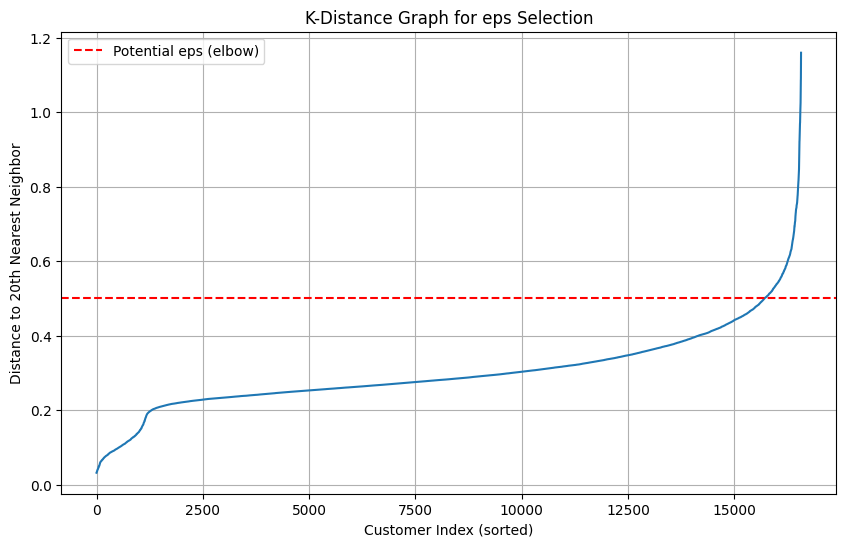

In [46]:
# Find optimal eps using K-distance method
nn_dbscan = NearestNeighbors(n_neighbors= 2 * len(metric_features)) # n_features * 2 as a rule of thumb
nn_dbscan.fit(df_outlier_treat[metric_features])
distances, _ = nn_dbscan.kneighbors(df_outlier_treat[metric_features]) # _ would be the indices of the n nearest neighbors, we only want the distances
# matrix of n_samples x n_neighbors nearest neighbors distances
distances = np.sort(distances[:, -1])
# distances will be a 1D array of the distance for every sample to the n nearest neighbor, sorted


plt.figure(figsize=(10,6))
plt.plot(distances)
plt.title("K-Distance Graph for eps Selection")
plt.xlabel("Customer Index (sorted)")
plt.ylabel("Distance to 20th Nearest Neighbor")
plt.grid(True)

plt.axhline(y=0.5, color='r', linestyle='--', label='Potential eps (elbow)') 
# NEED TO ADJUST THE VALUE OF EPS BASED ON THE GRAPH
# we choose the eps value at the elbow point

plt.legend()
plt.show()

In [47]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=2 * len(metric_features), n_jobs=-1)

dbscan_labels = dbscan.fit_predict(df_outlier_treat[metric_features])

In [48]:
# Print cluster counts for DBSCAN and get the R² score
print(pd.Series(dbscan_labels).value_counts().sort_index())
r2_db = get_rsq(df_outlier_treat, metric_features, dbscan_labels)
print(f"DBSCAN R² score: {r2_db:.4f}")

-1      178
 0    16396
Name: count, dtype: int64
DBSCAN R² score: 0.0150


In [49]:
df_outlier_treat['DBSCAN_Labels'] = dbscan_labels
len(df_outlier_treat[df_outlier_treat['DBSCAN_Labels'] == -1]) / len(df_outlier_treat) * 100

1.0739712803185713

We already dropped 1.9% of the data when dealing with missing values and duplicates. We will now drop these outliers since the total percentage doesnt reach 5%.

In [50]:
df_outliers = df_outlier_treat[df_outlier_treat['DBSCAN_Labels'] == -1]
df_outlier_treat.drop((df_outlier_treat[df_outlier_treat['DBSCAN_Labels'] == -1].index), inplace=True)

####  2.6.2 Univariate outlier capping

Before clustering, we want to protect the algorithms from extreme values that are almost certainly data errors
But we don't want to lose real high-value customers and diversity in the data so we will apply capping using the 1st and 99th percentiles:

In [51]:
extreme = []
for col in metric_features:
    low  = df_outlier_treat[col].quantile(0.01)
    high = df_outlier_treat[col].quantile(0.99)
    n_low  = (df_outlier_treat[col] < low).sum()
    n_high = (df_outlier_treat[col] > high).sum()
    if n_low + n_high > 0:
        extreme.append([col, n_low, n_high])

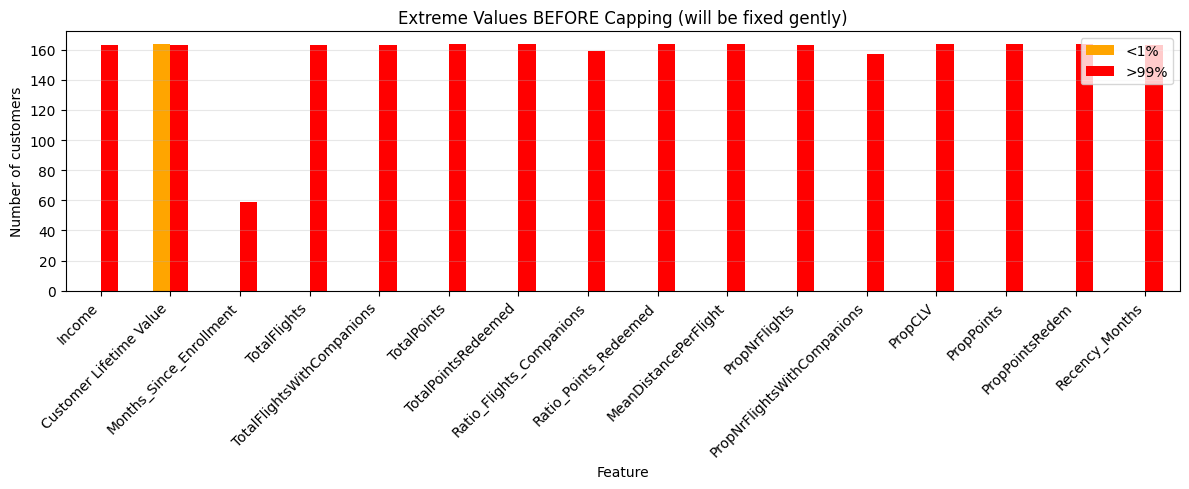

In [52]:
pd.DataFrame(extreme, columns=['Feature', '<1%', '>99%']).set_index('Feature').plot(
    kind='bar', figsize=(12,5), color=['orange','red'])
plt.title("Extreme Values BEFORE Capping (will be fixed gently)")
plt.ylabel("Number of customers")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

We can see from this visual that more than 160 customers have extreme values in several features 
These are the top 1% most extreme customers , some may be real vip customers but many values are so high that they can distort clustering algorithms.  
We will cap them at the 99th percentile (and also the few low values at the 1st percentile) so that our clustering remains stable and logic, while avoiding to remove other customers from the dataset.

In [53]:
print("Applying  capping ")

for col in metric_features:
    lower = df_outlier_treat[col].quantile(0.01)
    upper = df_outlier_treat[col].quantile(0.99)
    
    n_low  = (df_outlier_treat[col] < lower).sum()
    n_high = (df_outlier_treat[col] > upper).sum()
    
    df_outlier_treat[col] = df_outlier_treat[col].clip(lower=lower, upper=upper)
    
    if n_low + n_high > 0:
        print(f"{col:30} → capped {n_low:3} low | {n_high:3} high")

Applying  capping 
Income                         → capped   0 low | 163 high
Customer Lifetime Value        → capped 164 low | 163 high
Months_Since_Enrollment        → capped   0 low |  59 high
TotalFlights                   → capped   0 low | 163 high
TotalFlightsWithCompanions     → capped   0 low | 163 high
TotalPoints                    → capped   0 low | 164 high
TotalPointsRedeemed            → capped   0 low | 164 high
Ratio_Flights_Companions       → capped   0 low | 159 high
Ratio_Points_Redeemed          → capped   0 low | 164 high
MeanDistancePerFlight          → capped   0 low | 164 high
PropNrFlights                  → capped   0 low | 163 high
PropNrFlightsWithCompanions    → capped   0 low | 157 high
PropCLV                        → capped   0 low | 164 high
PropPoints                     → capped   0 low | 164 high
PropPointsRedem                → capped   0 low | 164 high
Recency_Months                 → capped   0 low | 163 high


### **2.7 Feature Selection**

In [54]:
df_clustering = df_outlier_treat.copy().drop(columns=['DBSCAN_Labels'])

We will have a dataset only with active customers and another with the clients that have already exited the program, both with just numerical features since they will enter the clustering algorithms. We will save the data off all costumers in 2 datasets, one will all the variables and another only with the numeric features

In [55]:
df_before_clustering = df_clustering.copy()
df_cancelled = df_before_clustering[df_before_clustering['ChurnStatus'] == 'Cancelled']
df_cancelled = df_cancelled.select_dtypes(include=[np.number])
df_active = df_before_clustering[df_before_clustering['ChurnStatus'] == 'Active']
df_active = df_active.select_dtypes(include=[np.number])
df_all = df_before_clustering.select_dtypes(include=[np.number])

### **2.7.1 Correlation Matrix of Numeric Features**

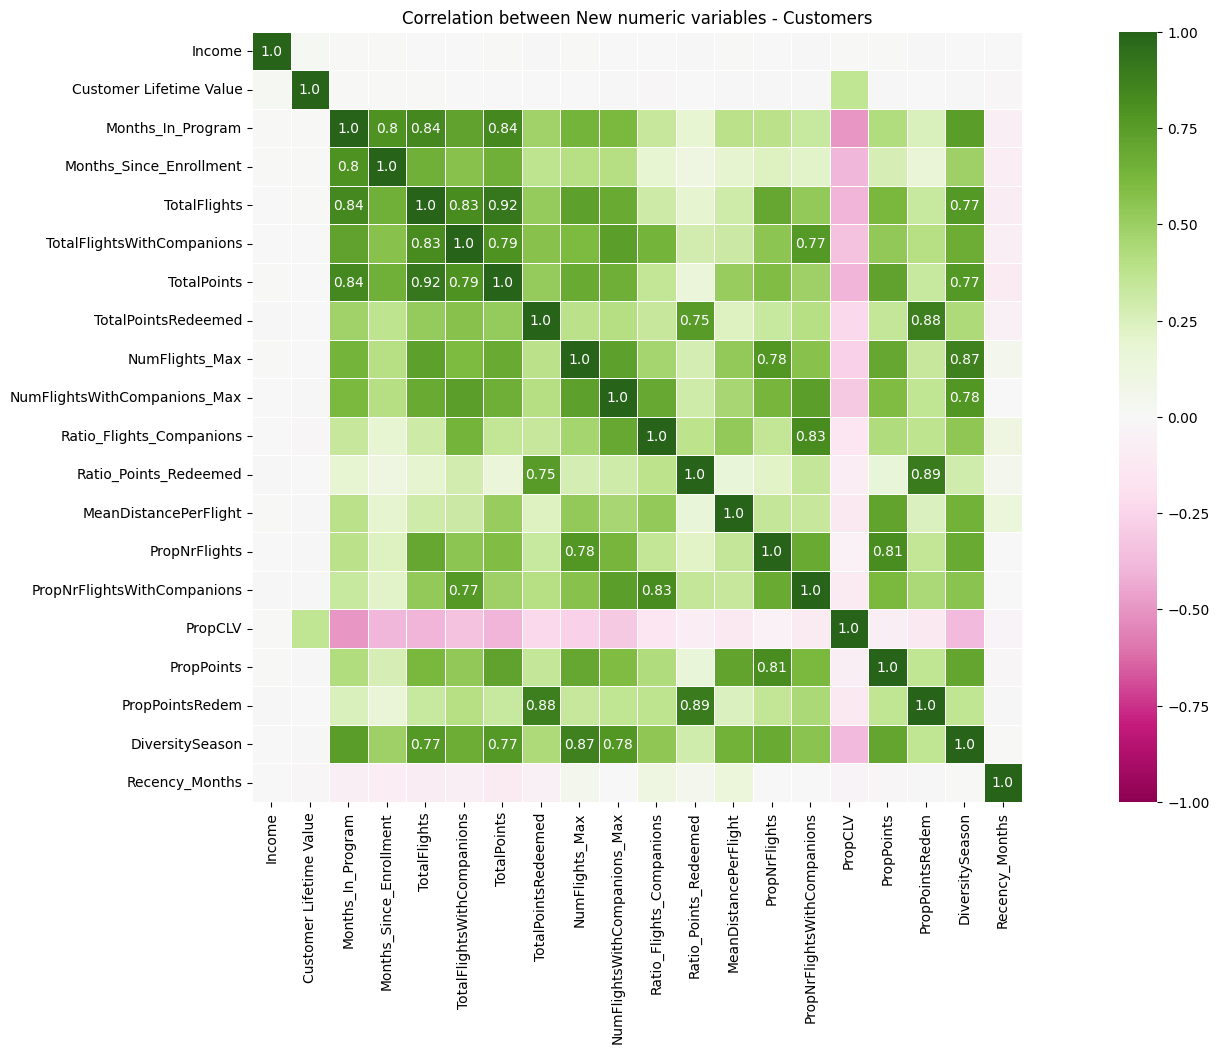

In [56]:
fig = plt.figure(figsize=(25, 10))


# # Plot heatmap of the correlation matrix
sns.heatmap(data=df_all.corr(), 
            annot=df_all.corr().round(2).astype(str).where(df_all.corr().abs() >= 0.75, ""), # Specify custom annotation
            fmt='s', # The annotation matrix now has strings, so we need to explicitly say this
            vmin=-1, vmax=1, 
            center=0, # Center the colormap at zero
            square=True, # Make each cell square-shaped
            linewidths=.5, # Add lines between cells
            cmap='PiYG' # Diverging color map
            )

plt.title("Correlation between New numeric variables - Customers")
plt.show()

Income has 0 correlations with all features, seems to be irrelevant. We will drop it. There is an area on the plot with strong correlation which can indicate redudant features. We will investigate these pairs of features.

features to drop:
months_in_program
total_flights

In [57]:
def corr_pairs(corr, threshold):
    mask = np.tril(np.ones(corr.shape), k=-1).astype(bool)
    
    corr_lower = corr.where(mask)
    
    cor_pairs = corr_lower.unstack().dropna()
    cor_pairs = cor_pairs[(cor_pairs.abs() >= threshold)]

    
    for pair, value in cor_pairs.items():
        feature_count_pair1 = len(corr[(corr[pair[0]].abs() > 0.35) & (corr[pair[0]].abs() < threshold)])
        feature_count_pair2 = len(corr[(corr[pair[1]].abs() > 0.35) & (corr[pair[1]].abs() < threshold)])
        
        print(f'{value:.2f} : {pair[0]} | significantly correlated with {feature_count_pair1} more features | or | {pair[1]} | significantly correlated with {feature_count_pair2} more features')

In [58]:
corr_pairs(df_all.corr(), 0.75)

0.80 : Months_In_Program | significantly correlated with 9 more features | or | Months_Since_Enrollment | significantly correlated with 8 more features
0.84 : Months_In_Program | significantly correlated with 9 more features | or | TotalFlights | significantly correlated with 8 more features
0.84 : Months_In_Program | significantly correlated with 9 more features | or | TotalPoints | significantly correlated with 10 more features
0.83 : TotalFlights | significantly correlated with 8 more features | or | TotalFlightsWithCompanions | significantly correlated with 11 more features
0.92 : TotalFlights | significantly correlated with 8 more features | or | TotalPoints | significantly correlated with 10 more features
0.77 : TotalFlights | significantly correlated with 8 more features | or | DiversitySeason | significantly correlated with 11 more features
0.79 : TotalFlightsWithCompanions | significantly correlated with 11 more features | or | TotalPoints | significantly correlated with 10 mo

In [59]:
df_all = df_all.copy().drop(['TotalFlights', 'Months_In_Program', 'Income'], axis=1)

income não tem correlações
total flights e total months, fazer análise de pares de variaveis para justificar

In [60]:
round(df_all.var(), 4)

Customer Lifetime Value         0.0058
Months_Since_Enrollment         0.0767
TotalFlightsWithCompanions      0.0348
TotalPoints                     0.0516
TotalPointsRedeemed             0.0216
NumFlights_Max                  0.0665
NumFlightsWithCompanions_Max    0.0696
Ratio_Flights_Companions        0.0149
Ratio_Points_Redeemed           0.0001
MeanDistancePerFlight           0.0006
PropNrFlights                   0.0122
PropNrFlightsWithCompanions     0.0057
PropCLV                         0.0003
PropPoints                      0.0152
PropPointsRedem                 0.0070
DiversitySeason                 0.0969
Recency_Months                  0.0159
dtype: float64

## **3. Clustering**

### **3.1 Multi perpective segmentation**

We will divide our features into two segments. One is value based, meaning that it brings economic value to the company. And another based on the behaviour of the customers. We did not find enough numerical features to create a demographic segmentation. The division is the following:

In [61]:
value_segmentation = ['Customer Lifetime Value', 'PropCLV', 'PropPointsRedem', 'TotalPointsRedeemed', 'TotalPoints', 'PropPoints']
behavioral_segmentation = ['Recency_Months', 'PropPointsRedem', 'TotalPointsRedeemed', 'TotalFlightsWithCompanions', 'NumFlights_Max', 'NumFlightsWithCompanions_Max', 'Ratio_Flights_Companions', 'Ratio_Points_Redeemed', 'MeanDistancePerFlight', 'PropNrFlights', 'PropNrFlightsWithCompanions', 'DiversitySeason', 'Months_Since_Enrollment']

For this project we will do 2 works in parallel:  

- Use all customers in the clustering algorithms and check if they are able to group all the customers that have cancelled without the variable 'ChurnStatus'. If this happens, we will consider that the other customers that were grouped with the cancelled ones, are at risk of churn. Then we will remove the ones that have cancelled customers from the cluster.
 They are helpful to identify the patterns of the clients that have a high probability of leaving the program, however, we do not wish to create a marketing strategy for them as the goal is only to do so for customers in the program.

- Use only the active customers for the clustering and after, in profilling, we will analyse if there is any cluster with similar characteristics to the clients that already left the program.




### **3.2 Hierarchical Clustering**

We will explore different values for the hyperparameters. From https://sklearn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html :   

" **metric:** metricstr or callable, default=”euclidean”
Metric used to compute the linkage. Can be “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. If linkage is “ward”, only “euclidean” is accepted. "  

We will have into consideration that linkage ward only works with euclidean distance.

In [63]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):

    '''
    This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    -------------------------------------------------------------
    df (DataFrame):
        Dataset to apply clustering

    link_method (str): 
        either "ward", "complete", "average", "single"

    max_nclus (int): 
        maximum number of clusters to compare the methods

    min_nclus (int): 
        minimum number of clusters to compare the methods. Defaults to 1.

    dist (str): 
        distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    -------------------------------------------------------------
    ndarray: 
        R2 values for the range of cluster solutions
    '''
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        

        cluster = AgglomerativeClustering(linkage=link_method, metric=dist, n_clusters=i)
 
        hclabels = cluster.fit_predict(df[feats])
    
        r2.append(get_rsq(df, feats, hclabels))
        
    return np.array(r2)


In [64]:
get_r2_hc(df_all[value_segmentation], 'ward', 10, 2)

array([0.4900403 , 0.60848186, 0.6742633 , 0.71154499, 0.73682945,
       0.75991049, 0.78176932, 0.79861367, 0.81299164])

In [65]:
def get_r2_hc_link(df, hc_methods, max_clusters, distance="euclidean"):
    '''
    This function computes the R2 for a set of hierarchical clustering methods, for different linkage methods and number of clusters.

    Parameters:
    -------------------------------------------------------------
    df (DataFrame):
        Dataset to apply clustering

    hc_methods (list): 
        list of hierarchical clustering methods to compare, e.g., ["ward", "complete", "average", "single"]

    max_clusters (int): 
        maximum number of clusters to compare the methods

    distance (str): 
        distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".

    Returns:
    -------------------------------------------------------------
    DataFrame: 
        R2 values for each hierarchical clustering method and number of clusters
    
    
    
    '''
    results = []
    for link in hc_methods:
        r2 = get_r2_hc(
            df=df, 
            link_method=link, 
            max_nclus=max_clusters, 
            min_nclus=1, 
            dist=distance)
        results.append(r2)
        r2_hc = np.vstack(results)
    return pd.DataFrame(r2_hc.T, index=range(1, max_clusters + 1), columns=hc_methods)

In [66]:
def plot_r2_hc_methods(datasets):

    '''
    This function plots the R2 values for different hierarchical clustering methods and number of clusters.

    Parameters:
    -------------------------------------------------------------
    datasets (list): 
        list of DataFrames containing R2 values for different hierarchical clustering methods and number of clusters.

    Returns:
    -------------------------------------------------------------
    None: 
        Displays the plots of R2 values for each hierarchical clustering method.


    '''
    sns.set()

    fig, axes = plt.subplots(2, 2, figsize=(18, 10))  
    axes = axes.flatten()

    for i, data in enumerate(datasets):
        sns.lineplot(ax=axes[i], data=data, linewidth=2.5, markers=["o"]*4)
        axes[i].set_title(f"Plot {i+1}", fontsize=15)
        axes[i].set_xticks(range(1, 11))
        axes[i].set_xlabel("Number of clusters", fontsize=12)
        axes[i].set_ylabel("R2 metric", fontsize=12)
        axes[i].legend(title="HC methods", title_fontsize=10)

    # Remove o 6º subplot vazio
    fig.delaxes(axes[-1])

    fig.suptitle("$R^2$ plots for various hierarchical methods", fontsize=22)
    plt.tight_layout()
    plt.show()

In [67]:
def plot_dendogram(linkage_matrix, y_threshold, distance):
    '''
    Plots a dendrogram for hierarchical clustering.
    
    Parameters:
    -------------------------------------------------------------
    linkage_matrix (ndarray): 
        The linkage matrix obtained from hierarchical clustering.

    y_threshold (float):
        The threshold value for cutting the dendrogram.

    distance (str): 
        The distance metric to use.


    Returns:
    -------------------------------------------------------------
    None: 
        Displays the dendrogram plot.
        
    '''

    sns.set()
    fig = plt.figure(figsize=(11,5))

 
    dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
        # You can play with 'truncate_mode' and 'p' define what level the dendrogram shows
        # above_threshold_color='k' forces black color for the lines above the threshold)
    plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
    plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')
    plt.ylabel(f'{distance.title()} Distance', fontsize=13)
    plt.show()

#### **All costumers**

**Value segmentation**

In [68]:
r2_hc_eucl = get_r2_hc_link(df_all[value_segmentation], ['ward', 'complete', 'average', 'single'], 10, distance="euclidean") 
r2_hc_l1 = get_r2_hc_link(df_all[value_segmentation], ['complete', 'average', 'single'], 10, distance="l1")  
r2_hc_l2 = get_r2_hc_link(df_all[value_segmentation], ['complete', 'average', 'single'], 10, distance="l2")
r2_hc_manh = get_r2_hc_link(df_all[value_segmentation], ['complete', 'average', 'single'], 10, distance="manhattan")

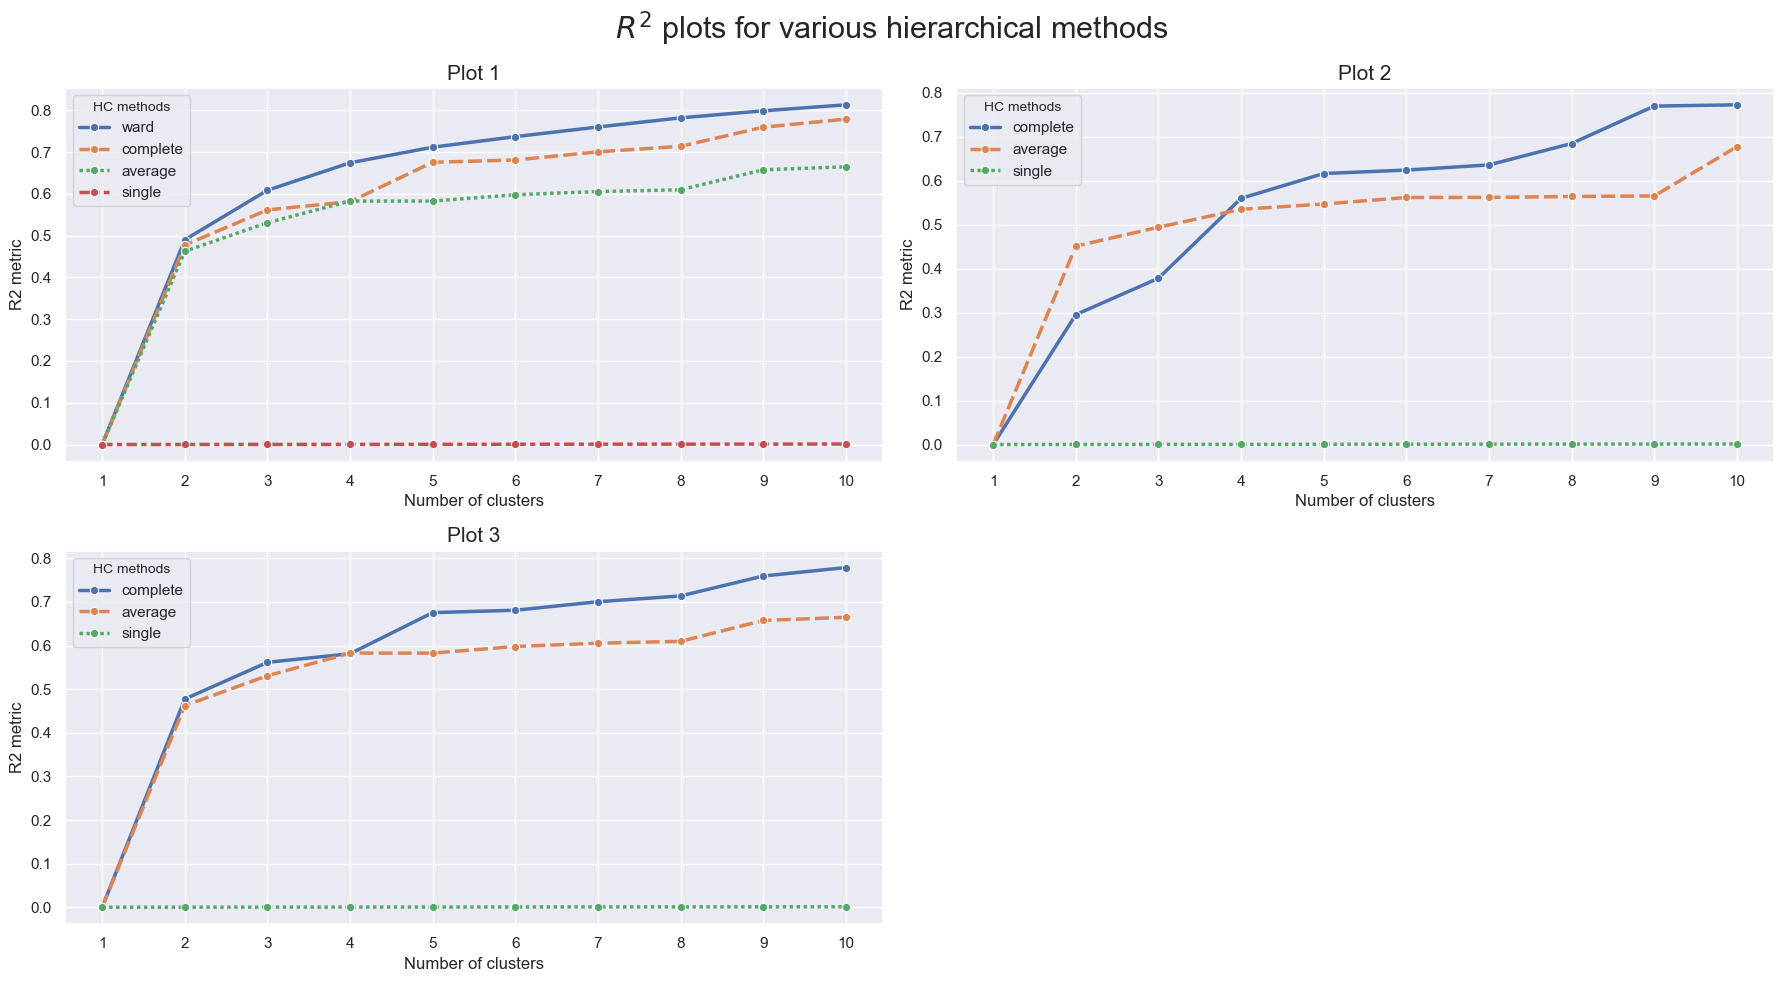

In [69]:
datasets = [r2_hc_eucl, r2_hc_l1, r2_hc_l2, r2_hc_manh]

# we will visualize the r2 for the different methods and distances, so that we can choose the best one
plot_r2_hc_methods(datasets)

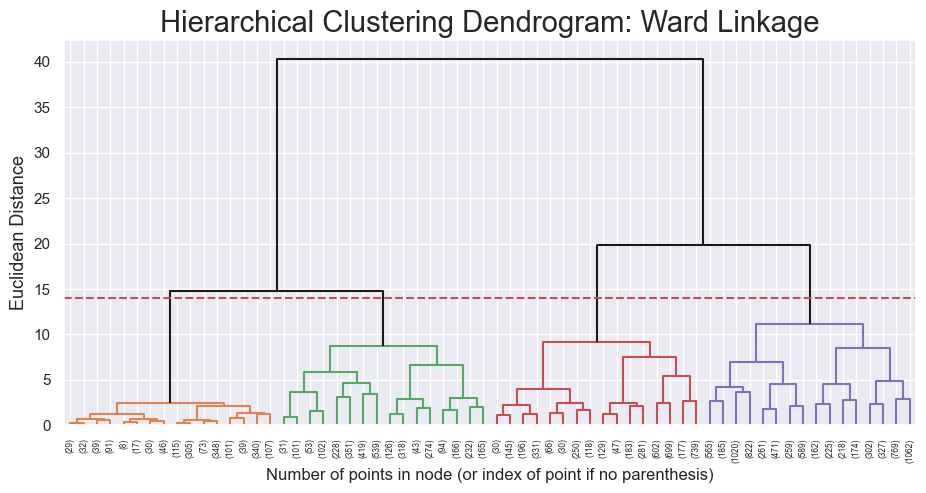

In [70]:
# with the best distance and method we will plot the dendrogram and choose the number of clusters
linkage_matrix= linkage(df_all[value_segmentation], method="ward")
plot_dendogram(linkage_matrix, y_threshold=14, distance="euclidean")

In [71]:
## create here the final hierarchical clustering model
hc_clust_all_value = AgglomerativeClustering(n_clusters=4) # dist = euclidean and linkage = ward are default
hc_labels_all_value = hc_clust_all_value.fit_predict(df_all[value_segmentation])
print(f"R^2 for hierarchical clustering (all customers, value-based): {get_rsq(df_all, value_segmentation, hc_labels_all_value):.4f}")
pd.Series(hc_labels_all_value).value_counts().sort_index()

R^2 for hierarchical clustering (all customers, value-based): 0.6743


0    7411
1    3242
2    4023
3    1720
Name: count, dtype: int64

We will repeat the same process for the behavioral segmentation

**Behavioral segmentation**

In [72]:
r2_hc_eucl = get_r2_hc_link(df_all[behavioral_segmentation], ['ward', 'complete', 'average', 'single'], 10, distance="euclidean") 
r2_hc_l1 = get_r2_hc_link(df_all[behavioral_segmentation], ['complete', 'average', 'single'], 10, distance="l1")  
r2_hc_l2 = get_r2_hc_link(df_all[behavioral_segmentation], ['complete', 'average', 'single'], 10, distance="l2")
r2_hc_manh = get_r2_hc_link(df_all[behavioral_segmentation], ['complete', 'average', 'single'], 10, distance="manhattan")

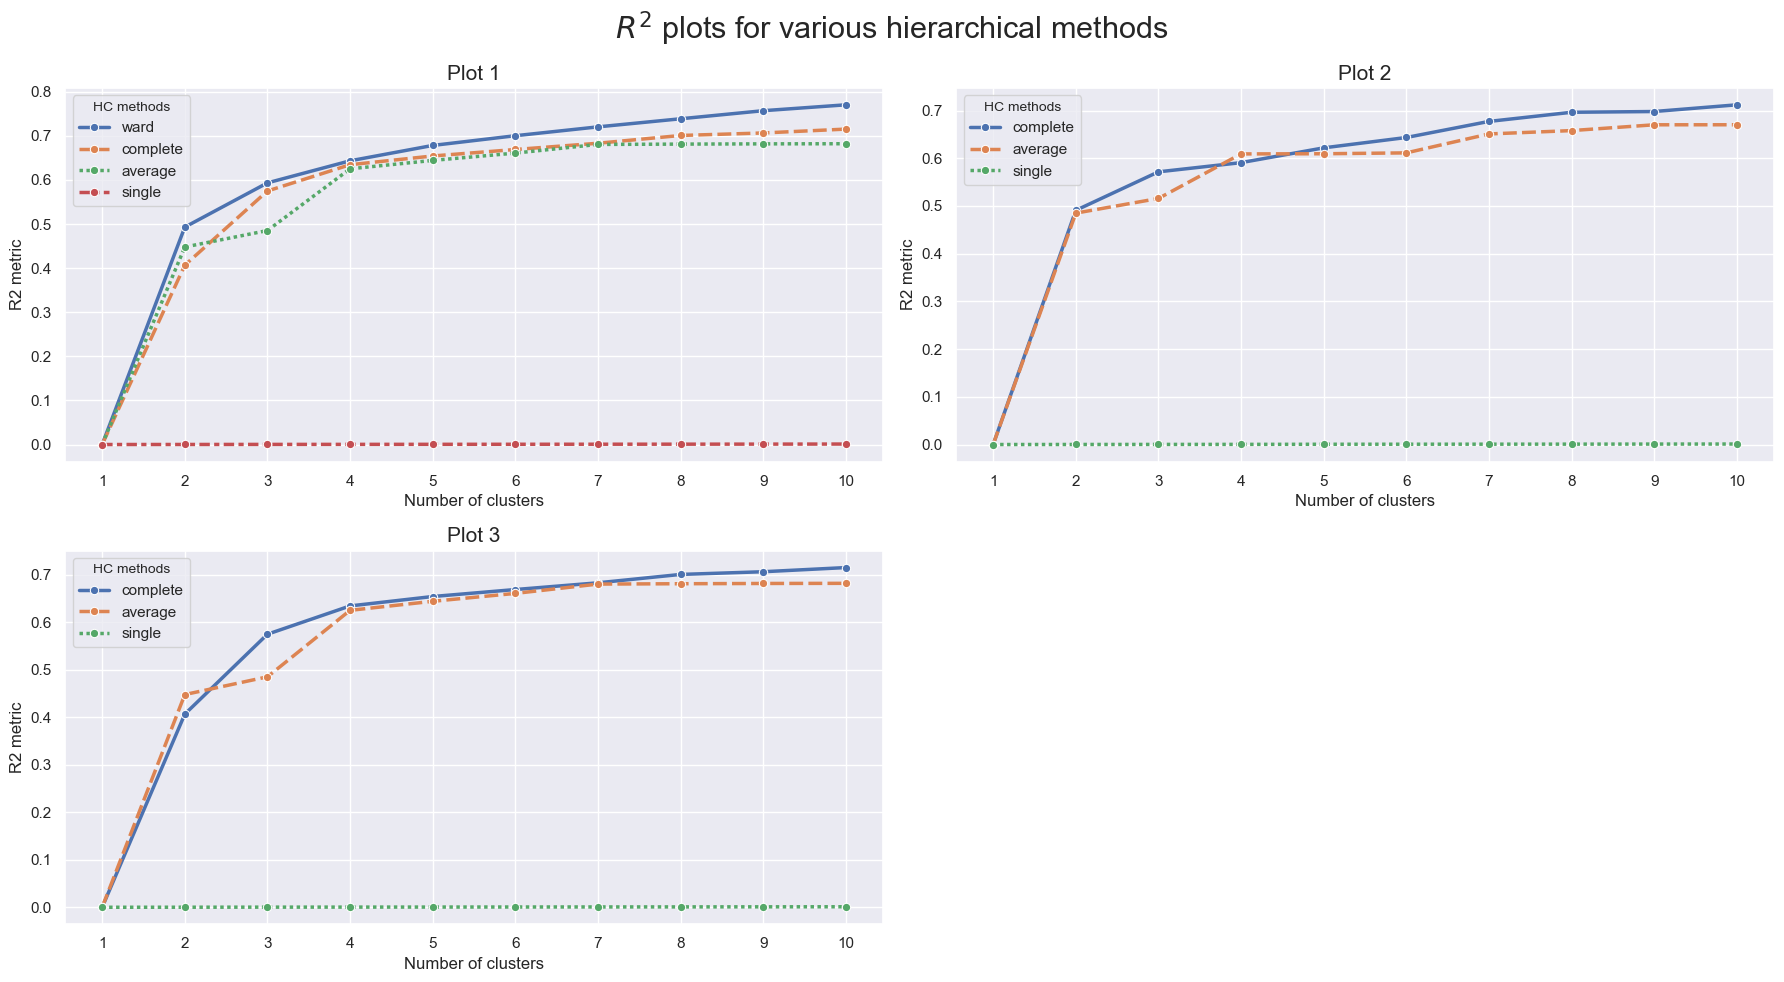

In [73]:
datasets = [r2_hc_eucl, r2_hc_l1, r2_hc_l2, r2_hc_manh]
plot_r2_hc_methods(datasets)

The best choice is euclidean distance with ward linkage, it reaches the highest R2  and also with lower number of clusters

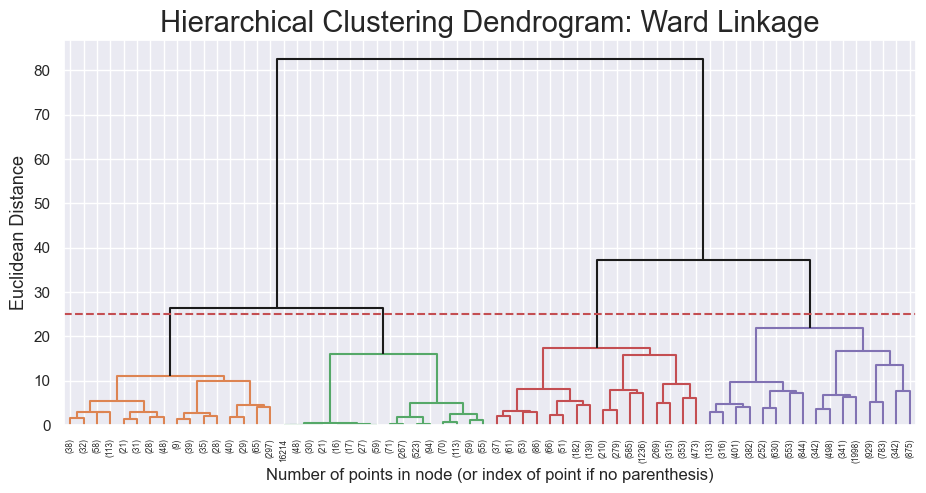

In [74]:
linkage_matrix= linkage(df_all[behavioral_segmentation], method="ward")
plot_dendogram(linkage_matrix, y_threshold=25, distance="euclidean")

4 or 5 clusters seem to be the best choice. The formation of the clusters seem similar to the one with value segmentation

In [75]:
## create here the final hierarchical clustering model
hc_clust_all_behav_4 = AgglomerativeClustering(n_clusters=4) # dist = euclidean and linkage = ward are default
hc_labels_all_behav_4 = hc_clust_all_behav_4.fit_predict(df_all[behavioral_segmentation])
print(f"R^2 for hierarchical clustering (all customers, behavioral-based): {get_rsq(df_all, behavioral_segmentation, hc_labels_all_behav_4):.4f}")
pd.Series(hc_labels_all_behav_4).value_counts()

R^2 for hierarchical clustering (all customers, behavioral-based): 0.6434


0    9619
2    4395
1    1471
3     911
Name: count, dtype: int64

clusters are very imbalanced. Cluster 0 has more than double the observations of the other clusters.

In [76]:
## create here the final hierarchical clustering model
hc_clust_all_behav_5 = AgglomerativeClustering(n_clusters=5) # dist = euclidean and linkage = ward are default
hc_labels_all_behav_5 = hc_clust_all_behav_5.fit_predict(df_all[behavioral_segmentation])
print(f"R^2 for hierarchical clustering (all customers, behavioral-based): {get_rsq(df_all, behavioral_segmentation, hc_labels_all_behav_5):.4f}")
pd.Series(hc_labels_all_behav_5).value_counts()

R^2 for hierarchical clustering (all customers, behavioral-based): 0.6783


2    6108
0    4395
4    3511
1    1471
3     911
Name: count, dtype: int64

With a 5th cluster, the previous biggest cluster, cluster 0, was separated into 2, now clusters 2 and 4. Its still not well balanced but it is better than the previous option, so we will choose 5 clusters.

In [77]:
hc_clust_all_behav = hc_clust_all_behav_5
hc_labels_all_behav = hc_labels_all_behav_5

#### **Active costumers**

**Value segmentation**

In [78]:
r2_hc_eucl = get_r2_hc_link(df_active[value_segmentation], ['ward', 'complete', 'average', 'single'], 10, distance="euclidean") 
r2_hc_l1 = get_r2_hc_link(df_active[value_segmentation], ['complete', 'average', 'single'], 10, distance="l1")  
r2_hc_l2 = get_r2_hc_link(df_active[value_segmentation], ['complete', 'average', 'single'], 10, distance="l2")
r2_hc_manh = get_r2_hc_link(df_active[value_segmentation], ['complete', 'average', 'single'], 10, distance="manhattan")

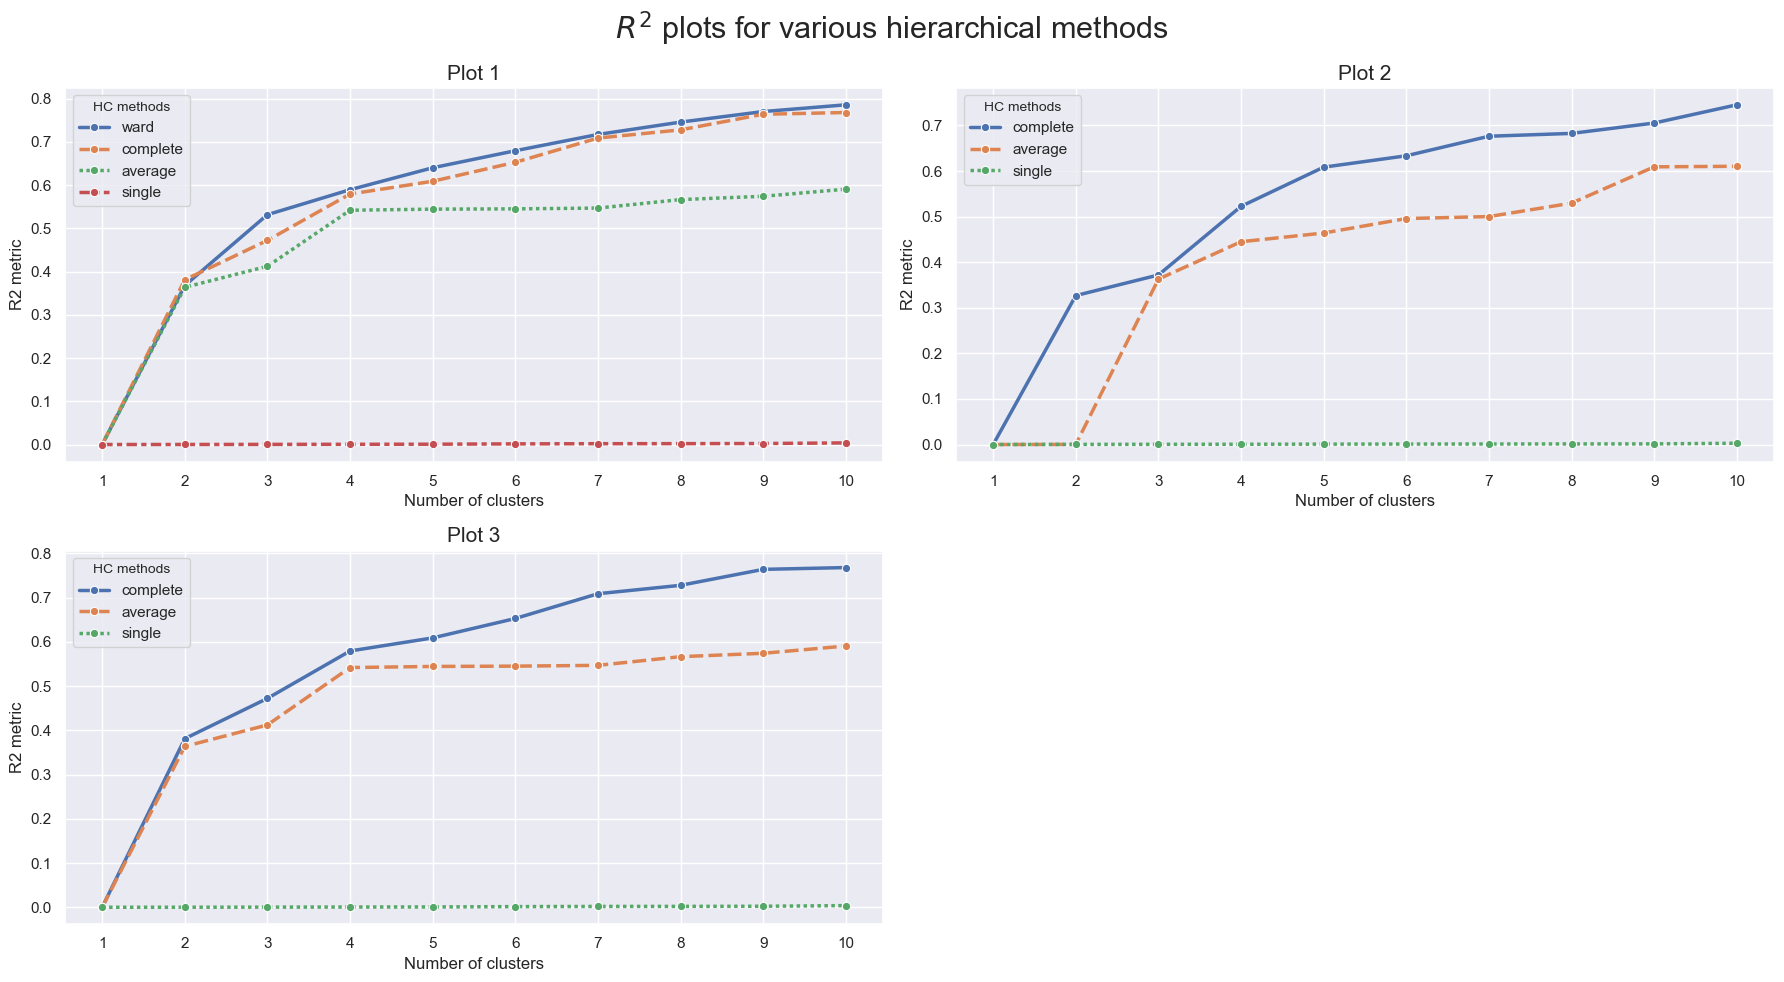

In [79]:
datasets = [r2_hc_eucl, r2_hc_l1, r2_hc_l2, r2_hc_manh]

# we will visualize the r2 for the different methods and distances, so that we can choose the best one
plot_r2_hc_methods(datasets)

Distances euclidean and l2 work similarly. ward and complete linkage work the best. euclidean distance with ward linkage reach higher R2 more quickly so we will choose that.

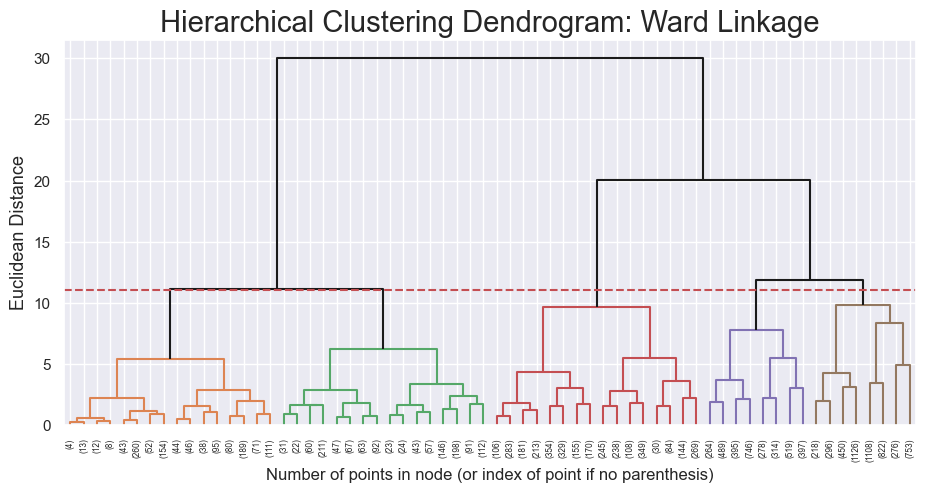

In [80]:
linkage_matrix= linkage(df_active[value_segmentation], method="ward")
plot_dendogram(linkage_matrix, y_threshold = 11, distance="euclidean")

Here 5 clusters seems like the best approach. But so does 7. However we do not want to create that many clusters so we will opt for 5.

In [81]:
## create here the final hierarchical clustering model
hc_clust_active_value = AgglomerativeClustering(n_clusters=5) 
hc_labels_active_value = hc_clust_active_value.fit_predict(df_active[value_segmentation])
print(f"R^2 for hierarchical clustering (active customers, value-based): {get_rsq(df_active, value_segmentation, hc_labels_active_value):.4f}")
pd.Series(hc_labels_active_value).value_counts().sort_index()

R^2 for hierarchical clustering (active customers, value-based): 0.6400


0    5049
1    3402
2    3258
3    1287
4    1220
Name: count, dtype: int64

This option probably has the most balanced clusters we  have seen so far, still there is a big difference the size of cluster 0 and the others.

**Behavioral Segmentation**

In [82]:
r2_hc_eucl = get_r2_hc_link(df_active[behavioral_segmentation], ['ward', 'complete', 'average', 'single'], 10, distance="euclidean") 
r2_hc_l1 = get_r2_hc_link(df_active[behavioral_segmentation], ['complete', 'average', 'single'], 10, distance="l1")  
r2_hc_l2 = get_r2_hc_link(df_active[behavioral_segmentation], ['complete', 'average', 'single'], 10, distance="l2")
r2_hc_manh = get_r2_hc_link(df_active[behavioral_segmentation], ['complete', 'average', 'single'], 10, distance="manhattan")

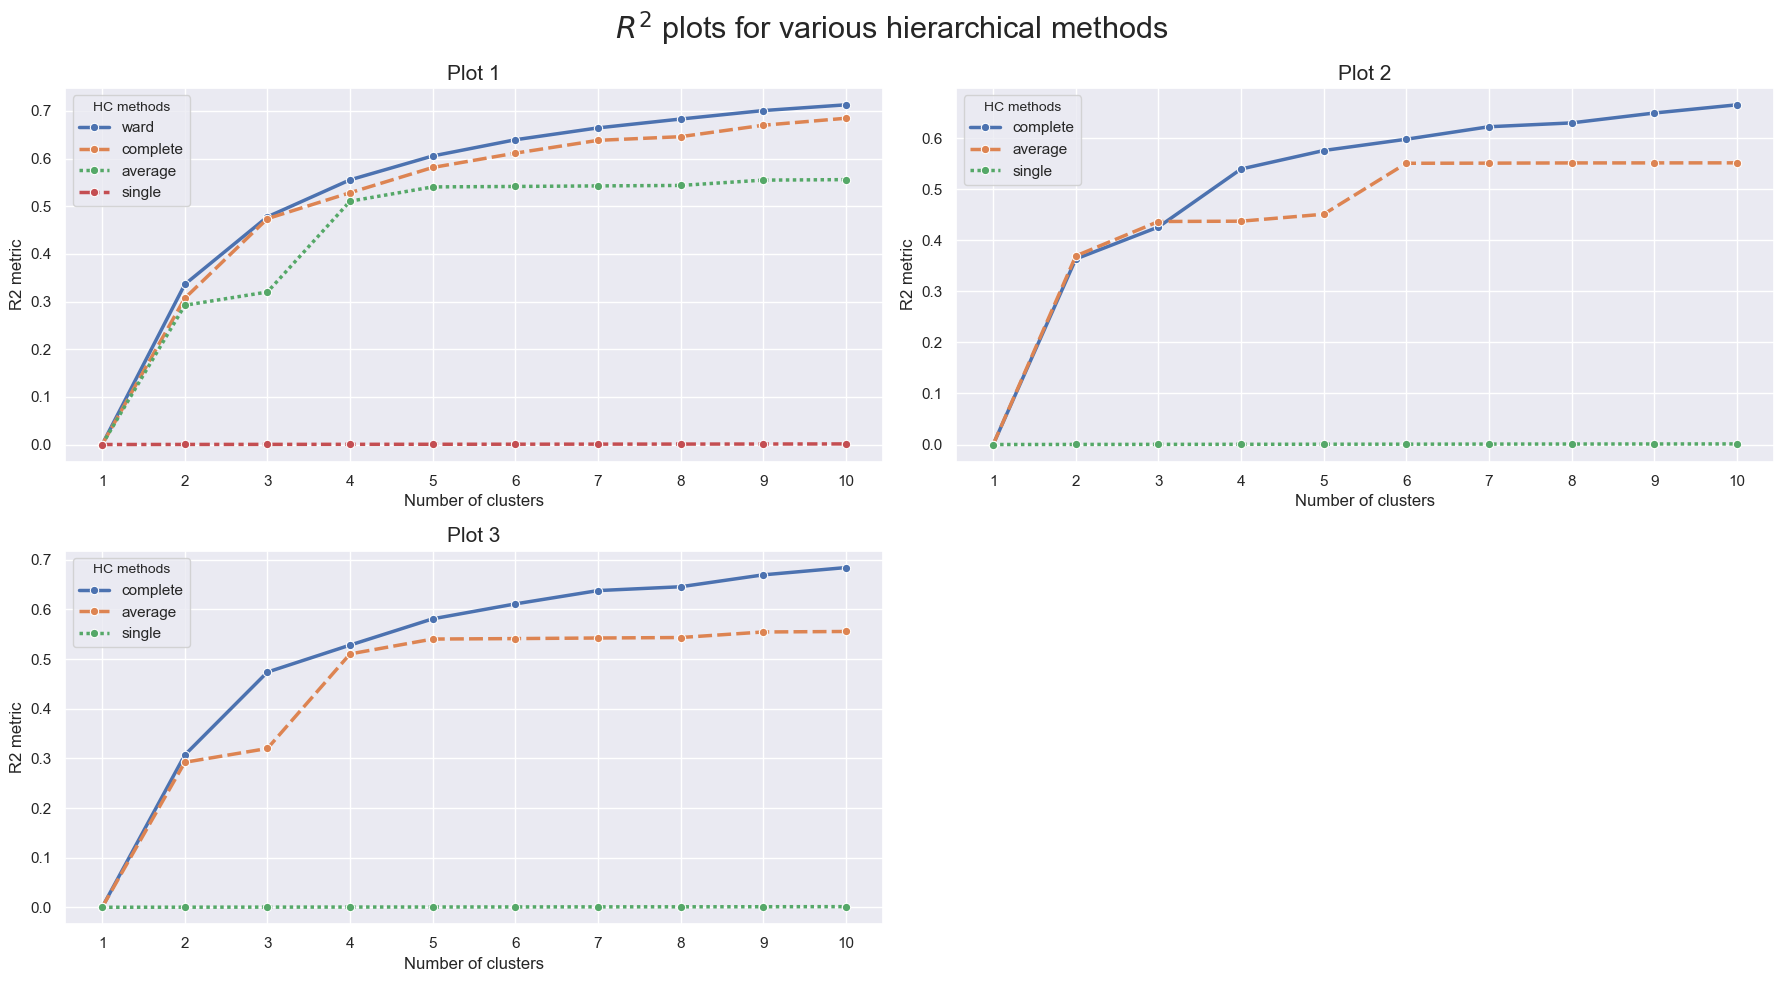

In [83]:
datasets = [r2_hc_eucl, r2_hc_l1, r2_hc_l2, r2_hc_manh]
plot_r2_hc_methods(datasets)

The best option is euclidean distance with ward linkage, although complete linkage with l2 distance is also a good choice.

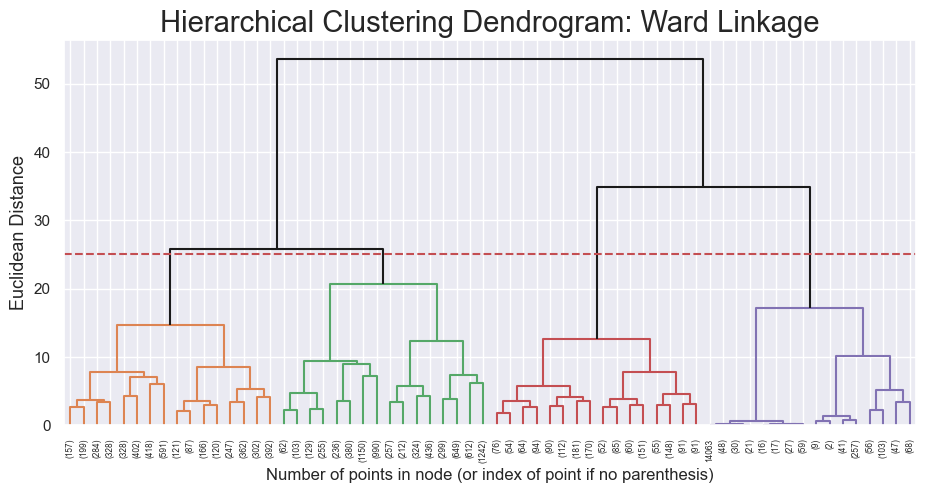

In [84]:
linkage_matrix= linkage(df_active[behavioral_segmentation], method="ward")
plot_dendogram(linkage_matrix, y_threshold=25, distance="euclidean")

4 clusters is a good option but so is 5.

In [85]:
## create here the final hierarchical clustering model
hc_clust_active_behav_4 = AgglomerativeClustering(n_clusters=4) 
hc_labels_active_behav_4 = hc_clust_active_behav_4.fit_predict(df_active[behavioral_segmentation])
print(f"R^2 for hierarchical clustering (active customers, behavior-based): {get_rsq(df_active, behavioral_segmentation, hc_labels_active_behav_4):.4f}")
pd.Series(hc_labels_active_behav_4).value_counts()

R^2 for hierarchical clustering (active customers, behavior-based): 0.5553


0    7336
3    4504
2    1574
1     802
Name: count, dtype: int64

In [86]:
hc_clust_active_behav_5 = AgglomerativeClustering(n_clusters=5) 
hc_labels_active_behav_5 = hc_clust_active_behav_5.fit_predict(df_active[behavioral_segmentation])
print(f"R^2 for hierarchical clustering (active customers, behavior-based): {get_rsq(df_active, behavioral_segmentation, hc_labels_active_behav_5):.4f}")
pd.Series(hc_labels_active_behav_5).value_counts()

R^2 for hierarchical clustering (active customers, behavior-based): 0.6053


1    4504
3    4031
4    3305
2    1574
0     802
Name: count, dtype: int64

Cluster 0 is divided into 2 clusters creating much more balanced clusters. We seem to have a micro cluster with 802 individuals however, in order to merge it, we would have to reduce the number of clusters to 2, and clearly they the clients in them would be very different. We will choose 5 clusters

In [87]:
hc_clust_active_behav = AgglomerativeClustering(n_clusters=5)
hc_labels_active_behav = hc_clust_active_behav.fit_predict(df_active[behavioral_segmentation])

R2 values for hierarichal clustering vary between 0.64 and 0.68 which is not a lot. We will probabçy find better results with other algorithms. The R2 seems to drop a little in the dataset of the active costumers. In geral we chose 4 to 5 cluster. The active costumers seem to have a lot more details and differences since the dendogram suggests higher number of clusters

### **3.3 Kmeans**

We will create a kmeans model with the best k which will provide us with the best results

Let's start by creating the functions to make the work easier

Silhouette Analysis Function

In [88]:
def silhouette_analysis(X_scaled, k_range, title_suffix):
    """
    Performs silhouette analysis for different k values 
    """
    avg_silhouette = []
    
    for nclus in k_range:
        if nclus == 1:
            continue
        
        # Create figure for silhouette plot
        fig = plt.figure(figsize=(13, 7))
        
        # Initialize KMeans with k-means++
        kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=10, random_state=1)
        cluster_labels = kmclust.fit_predict(X_scaled)
        
        # Calculate silhouette score
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg:.4f}")
        
        # Compute silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
        y_lower = 10
        
        for i in range(nclus):
            # Aggregate silhouette scores for cluster i
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            # Fill silhouette plot
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        
        plt.title(f"Silhouette Plot - {title_suffix} (k={nclus})")
        plt.xlabel("Silhouette Coefficient")
        plt.ylabel("Cluster Label")
        plt.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Average: {silhouette_avg:.4f}")
        
        xmin, xmax = np.round(sample_silhouette_values.min() - 0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])
        plt.ylim([0, len(X_scaled) + (nclus + 1) * 10])
        plt.yticks([])
        plt.xticks(np.arange(xmin, xmax, 0.1))
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return avg_silhouette

Elbow and CH Score Analysis

In [89]:
def elbow_and_ch_analysis(X_scaled, k_range, title_suffix):
    """
    Calculates Inertia (Elbow) and Calinski-Harabasz scores.
    """
    inertias = []
    ch_scores = []
    
    for k in k_range:
        kmclust = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=1)
        labels = kmclust.fit_predict(X_scaled)
        
        inertias.append(kmclust.inertia_)
        ch_scores.append(calinski_harabasz_score(X_scaled, labels))
    
    # Plot Elbow Method
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_title(f'Elbow Method - {title_suffix}', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Inertia')
    axes[0].grid(True, alpha=0.3)
    
    # Plot Calinski-Harabasz Score
    axes[1].plot(k_range, ch_scores, 'go-', linewidth=2, markersize=8)
    best_k_ch = k_range[np.argmax(ch_scores)]
    axes[1].axvline(x=best_k_ch, color='red', linestyle='--', linewidth=2, label=f'Best k={int(best_k_ch)}')
    axes[1].set_title(f'Calinski-Harabasz Score - {title_suffix}', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Calinski-Harabasz Score')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return inertias, ch_scores

Summary Metrics Table

In [90]:
def summary_metrics_table(X_scaled, k_range, title_suffix):
    """
    Creates a summary table of all metrics for each k.
    """
    results = {
        'k': [],
        'Inertia': [],
        'Silhouette': [],
        'Calinski-Harabasz': []
    }
    
    for k in k_range:
        kmclust = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=1)
        labels = kmclust.fit_predict(X_scaled)
        
        results['k'].append(k)
        results['Inertia'].append(kmclust.inertia_)
        results['Silhouette'].append(silhouette_score(X_scaled, labels))
        results['Calinski-Harabasz'].append(calinski_harabasz_score(X_scaled, labels))
    
    results_df = pd.DataFrame(results)
    
    print("\n" + "=" * 80)
    print(f"SUMMARY METRICS - {title_suffix}")
    print("=" * 80)
    print(results_df.to_string(index=False, float_format='%.4f'))
    print("=" * 80)
    
    return results_df

In [91]:
def plot_parallel_coordinates_from_labels(df, cluster_labels, features, title="Cluster Profiling - Parallel Coordinates"):
    """
    Plots parallel coordinates for cluster mean profiles.

    Parameters:
    - df: original dataframe with features
    - cluster_labels: array/series with cluster assignments
    - features: list of features to include
    - title: plot title
    """
    # Combine features + cluster labels
    df_concat = pd.concat([df[features], pd.Series(cluster_labels, name='labels', index=df.index)], axis=1)
    
    # Compute cluster means
    km_profile = df_concat.groupby('labels').mean().T
    
    # Prepare dataframe for plotting
    km_profile2 = km_profile.T.reset_index()
    km_profile2['labels'] = km_profile2['labels'].astype(str)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    parallel_coordinates(km_profile2, 'labels', colormap='tab10', linewidth=2, ax=ax)
    ax.set_title(title, fontsize=14)
    ax.axhline(0, linestyle='-.', alpha=0.5)
    plt.xticks(rotation=70, ha='right')
    plt.tight_layout()
    plt.show()

#### All Customers

#### Value-Based segmentation


In [92]:
k_range_all_value = range(2, 11)

# Silhouette analysis
print("\n--- SILHOUETTE ANALYSIS ---")
avg_sil_all_value = silhouette_analysis(df_all[value_segmentation].values, k_range_all_value, 'All Customers - Value-Based')

# Elbow and CH analysis
print("\n--- ELBOW AND CALINSKI-HARABASZ ANALYSIS ---")
inertias_all_value, ch_all_value = elbow_and_ch_analysis(df_all[value_segmentation].values, k_range_all_value, 'All Customers - Value-Based')

# Summary table
results_all_value = summary_metrics_table(df_all[value_segmentation].values, k_range_all_value, 'All Customers - Value-Based')


--- SILHOUETTE ANALYSIS ---
For n_clusters = 2, the average silhouette_score is : 0.4532


NameError: name 'cm' is not defined

<Figure size 1300x700 with 0 Axes>

Silhouette Plots 
- In k=2 we have the highest average silhouette score (0.4532). 
from k=3 to k=10 clusters become more unbalanced and several clusters show many points with low or even negative silhouette values 

Elbow Plot:

- Clear elbow visible around k=4 or k=5, where the rate of decrease in inertia starts to slow down. After k=5, the gains in inertia reduction become smaller.

Calinski-Harabasz Plot:

- Highest CH score at k=2 
Peak at k=2, then a slight drop, with another local peak at k=6 

* Silhouette strongly favors k=2 (highest and most stable separation).
* Elbow suggests k=4 or 5 for more granularity
* Calinski-Harabasz also points strongly to k=2 


Cluster sizes:
0     5351
1    11045
Name: count, dtype: int64

R² score: 0.4997


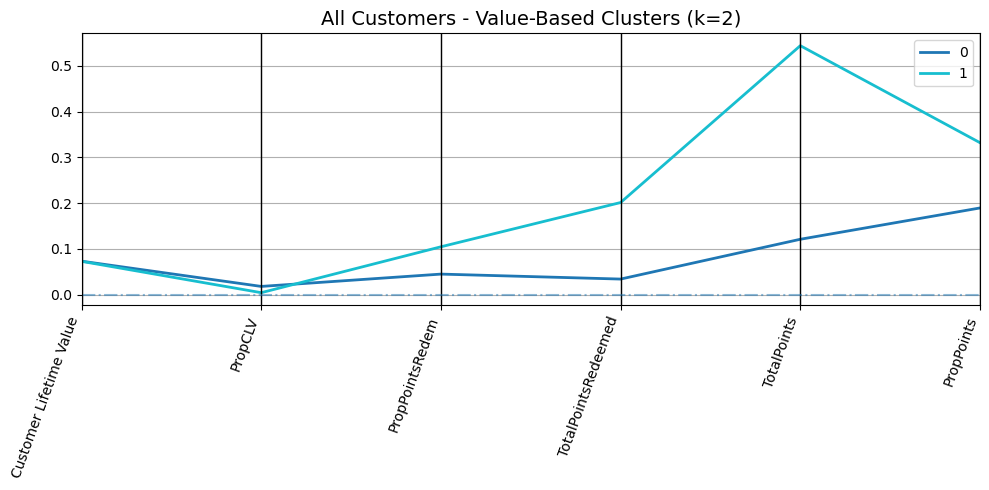

In [ ]:
number_clusters = 2 
km_value_all = KMeans(n_clusters=number_clusters, init='k-means++', n_init=10, random_state=1)
km_labels_value_all = km_value_all.fit_predict(df_all[value_segmentation].values)

# Show cluster sizes
print(f"\nCluster sizes:")
print(pd.Series(km_labels_value_all).value_counts().sort_index())

# Calculate and print R² score
r2_value_all = get_rsq(df_all, value_segmentation, km_labels_value_all)
print(f"\nR² score: {r2_value_all:.4f}")

# Plot parallel coordinates
plot_parallel_coordinates_from_labels(
    df_all[value_segmentation], 
    km_labels_value_all, 
    value_segmentation,
    title="All Customers - Value-Based Clusters (k=2)"
)

- Cluster 0: This is the most valuable customer segment. They generate high CLV, are highly engaged, and are the primary beneficiaries of the loyalty program in terms of accumulated points.
- Cluster 1: This segment represents the majority of low-value customers. They are characterized by low engagement, low CLV, and minimal use of the loyalty program

#### Behavioral segmentation


--- SILHOUETTE ANALYSIS ---
For n_clusters = 2, the average silhouette_score is : 0.5719


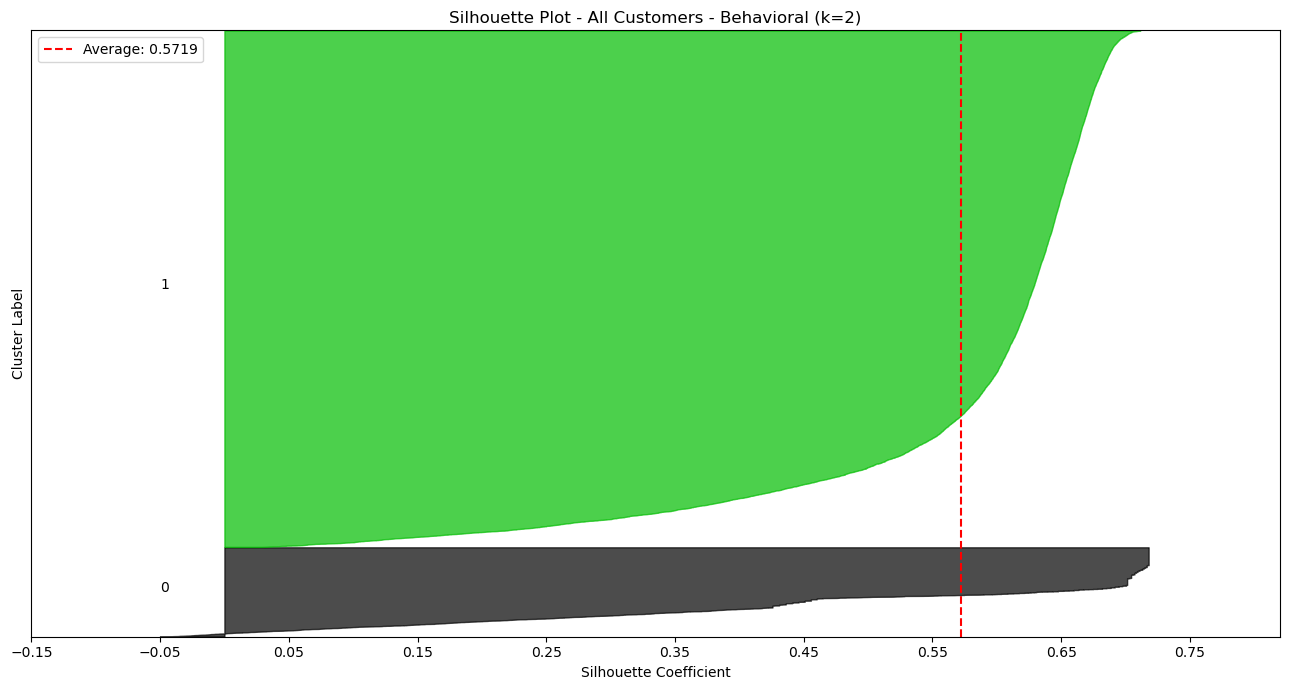

For n_clusters = 3, the average silhouette_score is : 0.3504


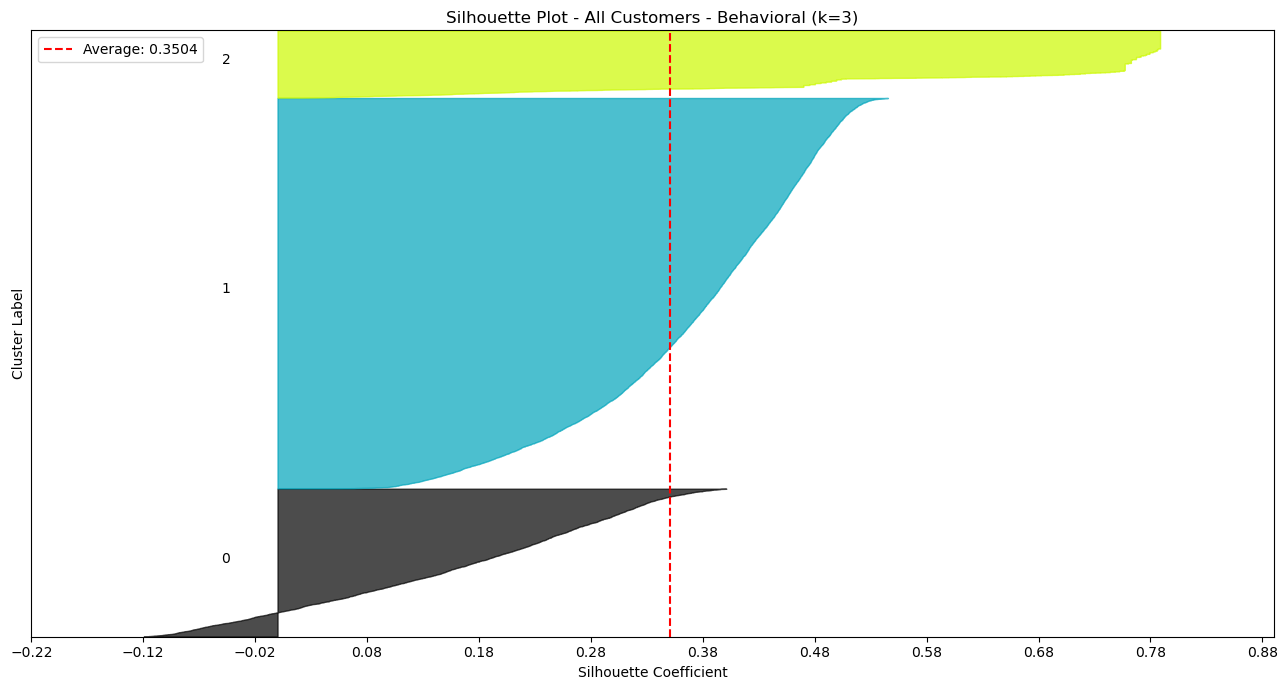

For n_clusters = 4, the average silhouette_score is : 0.2510


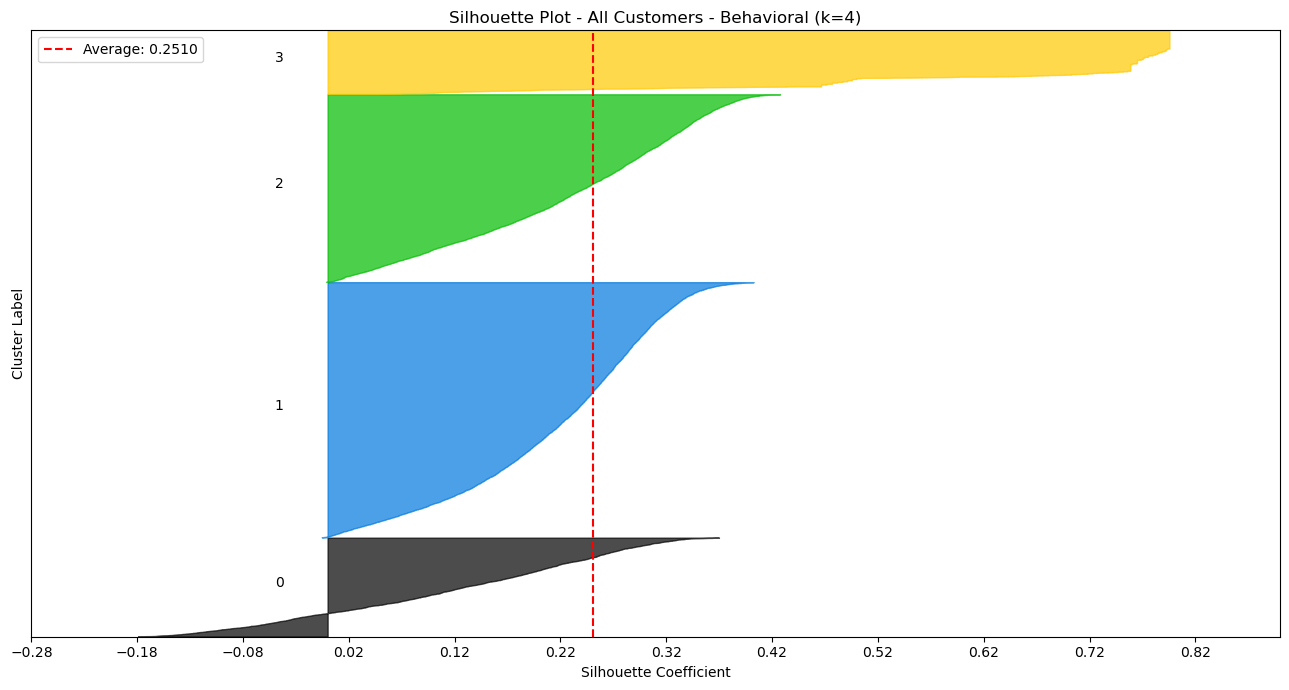

For n_clusters = 5, the average silhouette_score is : 0.2412


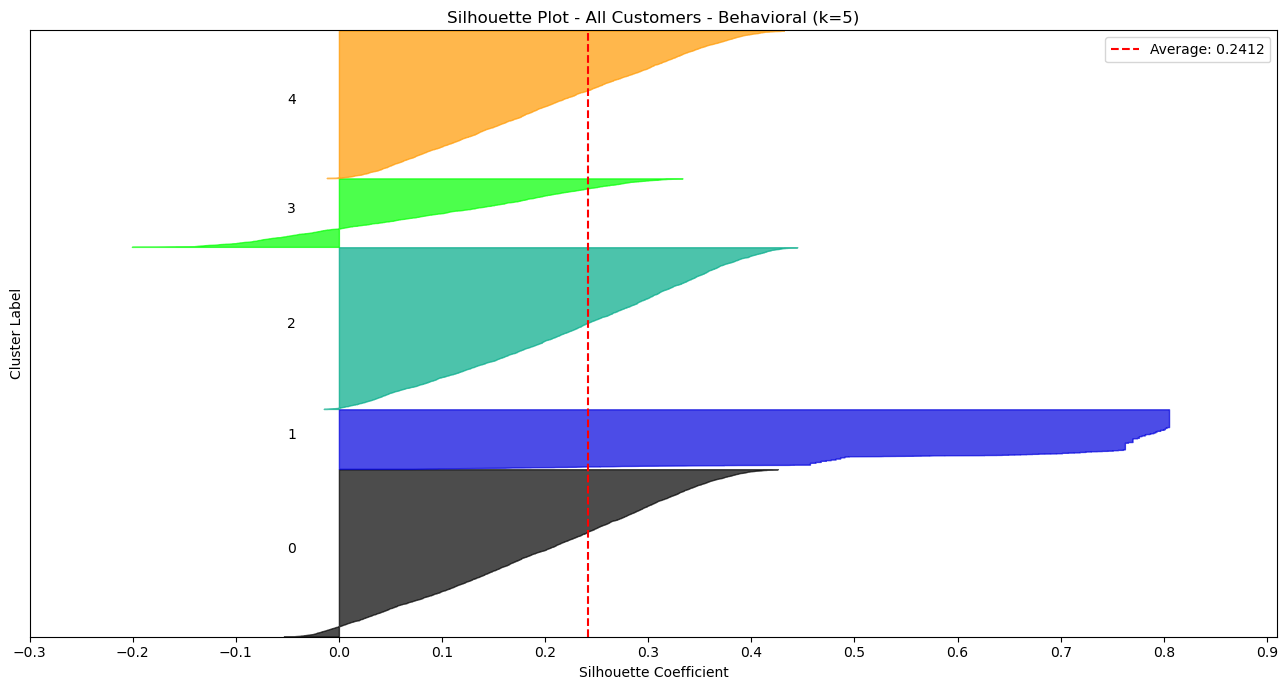

For n_clusters = 6, the average silhouette_score is : 0.2510


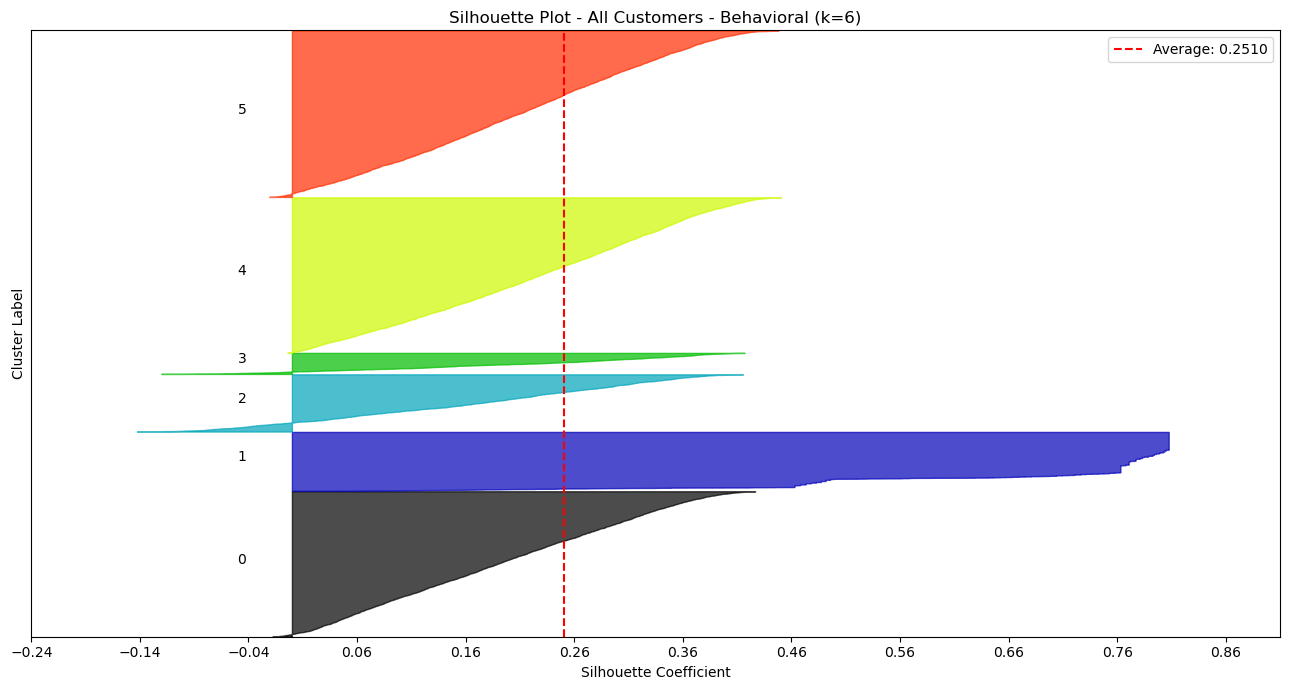

For n_clusters = 7, the average silhouette_score is : 0.2573


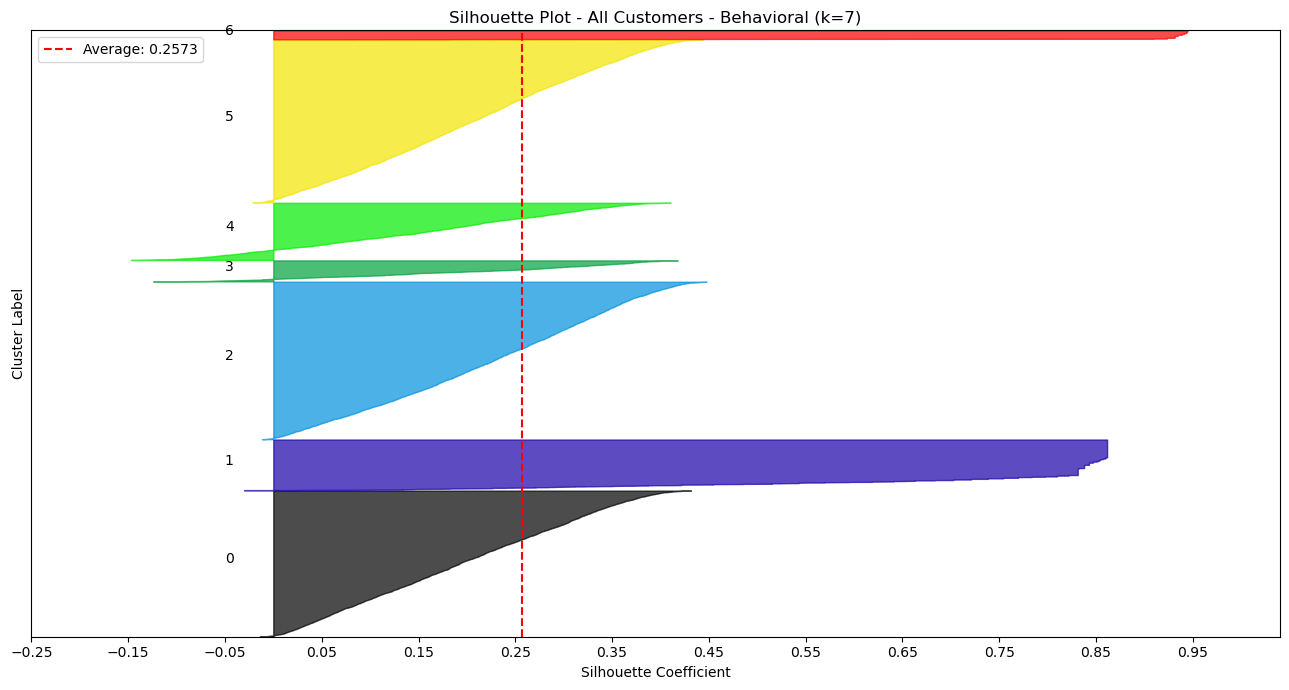

For n_clusters = 8, the average silhouette_score is : 0.2542


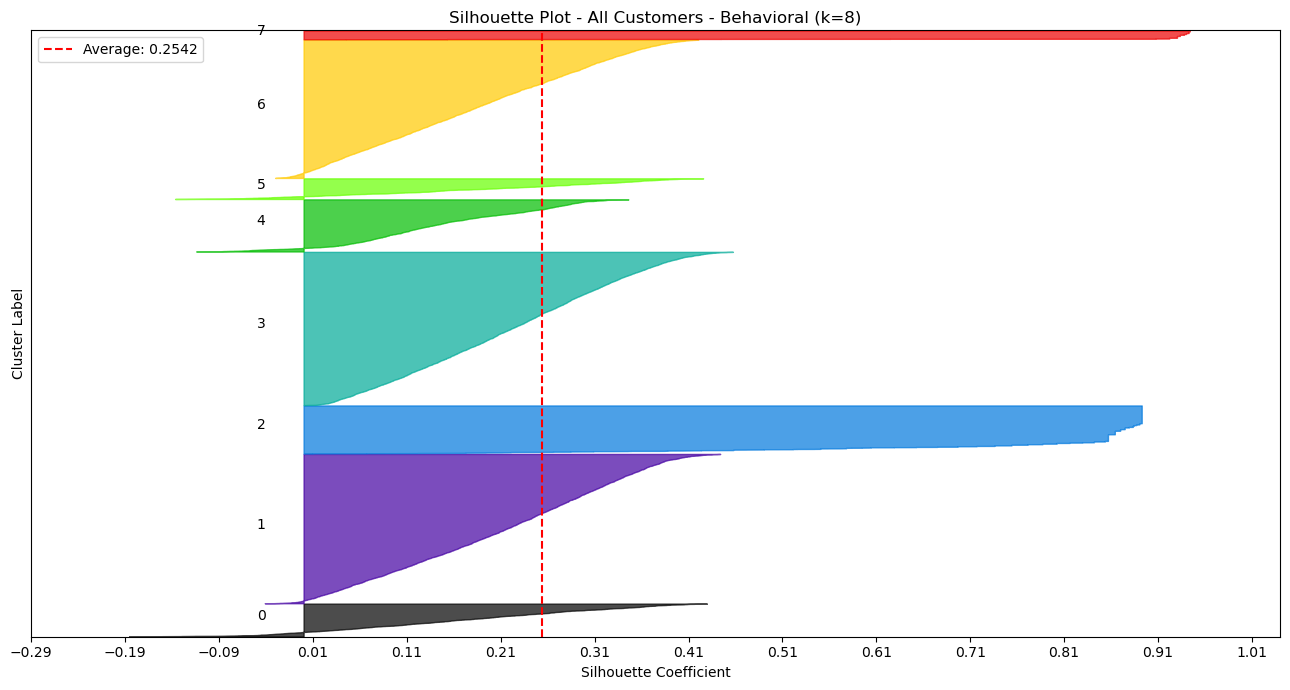

For n_clusters = 9, the average silhouette_score is : 0.2417


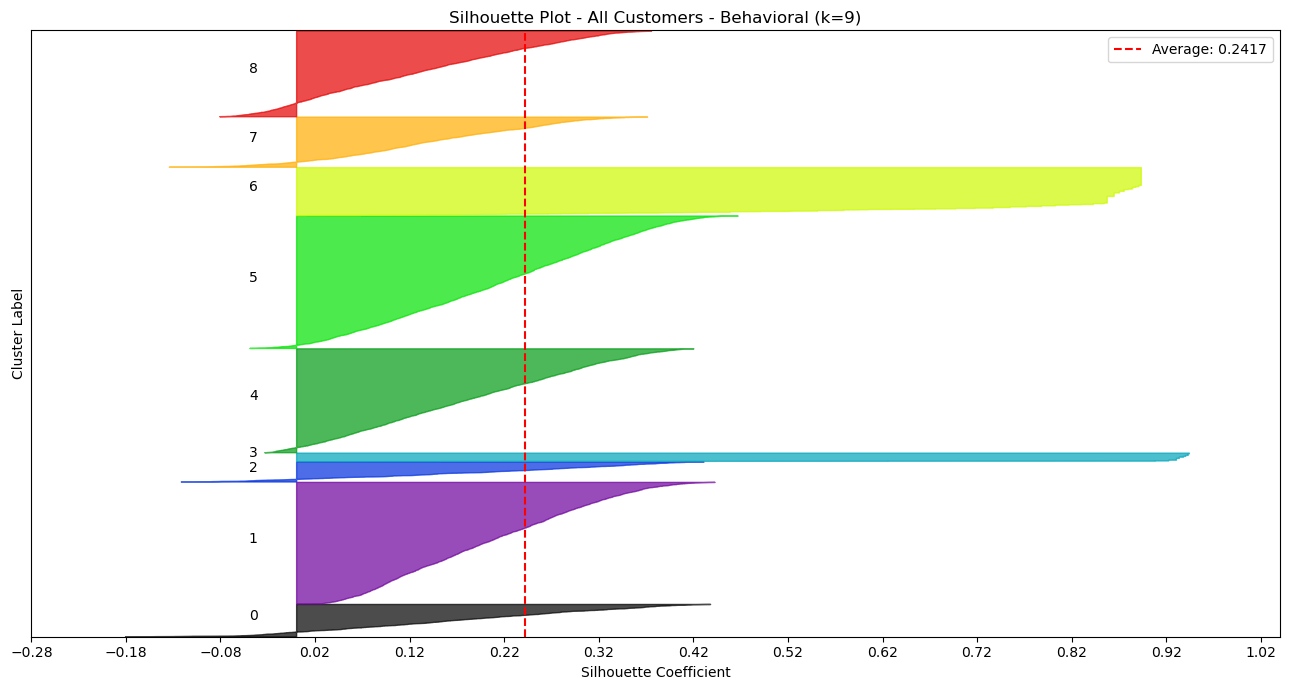

For n_clusters = 10, the average silhouette_score is : 0.2354


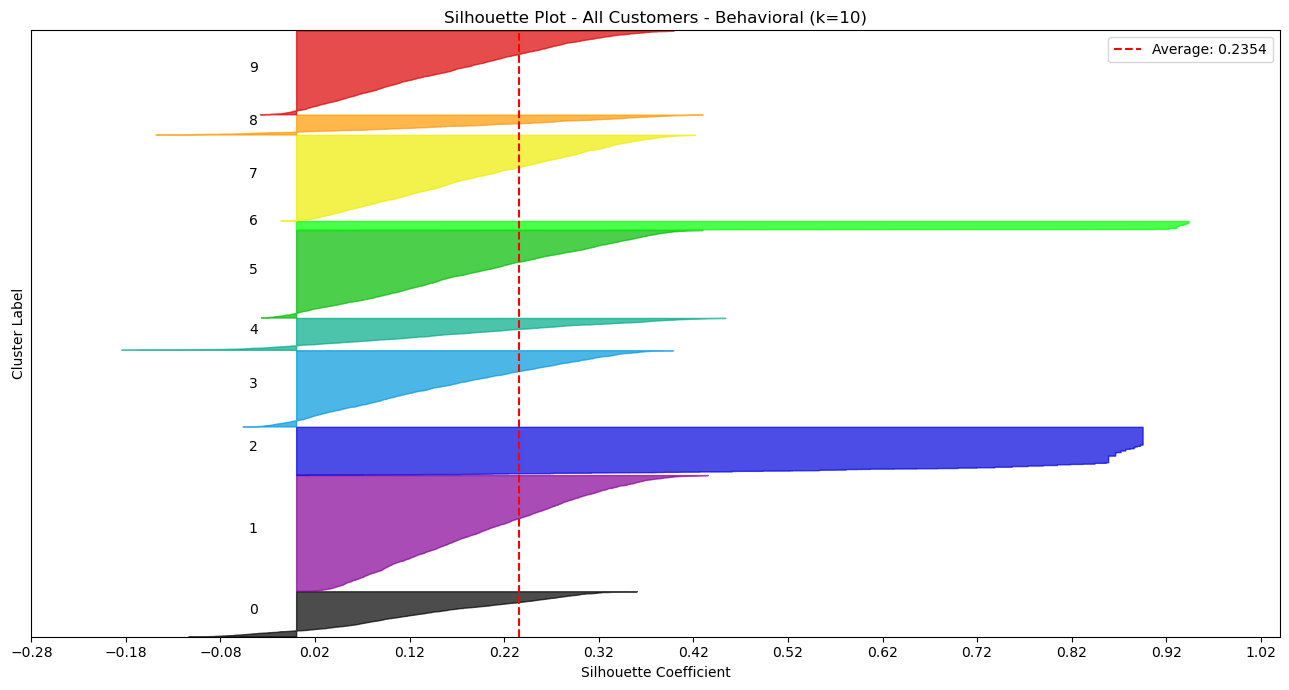


--- ELBOW AND CALINSKI-HARABASZ ANALYSIS ---


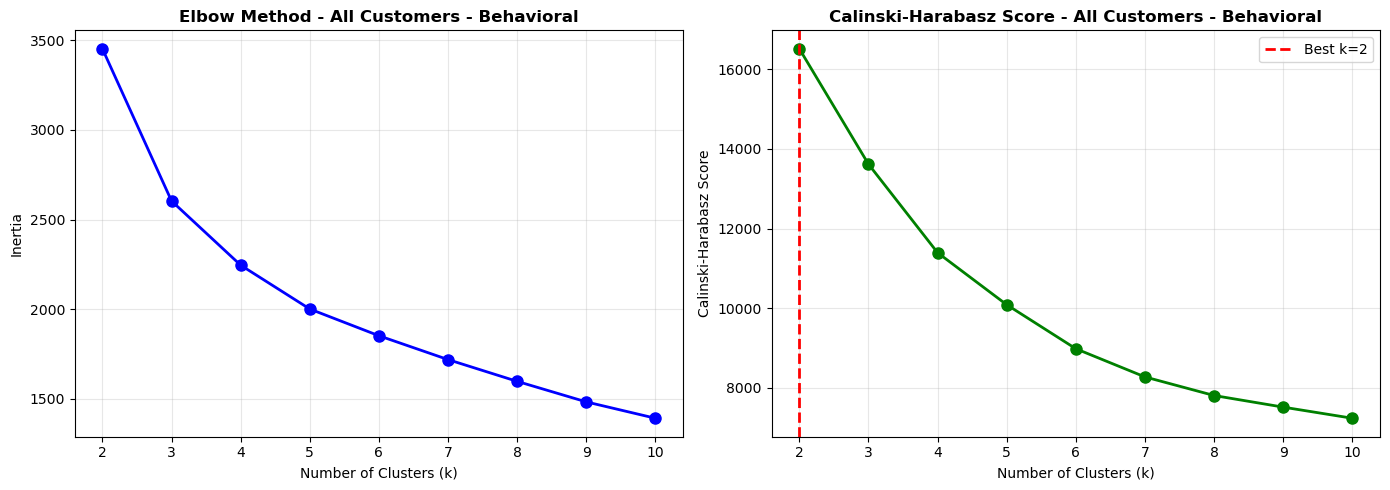


SUMMARY METRICS - All Customers - Behavioral
 k   Inertia  Silhouette  Calinski-Harabasz
 2 3451.4010      0.5719         16512.0609
 3 2603.3377      0.3504         13614.9444
 4 2245.6121      0.2510         11392.3071
 5 2001.4022      0.2412         10086.2835
 6 1852.4255      0.2510          8981.0301
 7 1719.4864      0.2573          8273.5040
 8 1598.2287      0.2542          7806.7899
 9 1483.8026      0.2417          7515.1990
10 1392.6566      0.2354          7236.1023


In [ ]:
k_range_all_behav = range(2, 11)

# Silhouette analysis
print("\n--- SILHOUETTE ANALYSIS ---")
avg_sil_all_behav = silhouette_analysis(df_all[behavioral_segmentation].values, k_range_all_behav, 'All Customers - Behavioral')

# Elbow and CH analysis
print("\n--- ELBOW AND CALINSKI-HARABASZ ANALYSIS ---")
inertias_all_behav, ch_all_behav = elbow_and_ch_analysis(df_all[behavioral_segmentation].values, k_range_all_behav, 'All Customers - Behavioral')

# Summary table
results_all_behav = summary_metrics_table(df_all[behavioral_segmentation].values, k_range_all_behav, 'All Customers - Behavioral')

Silhouette Plots:
- for k=2, we noticed a high average silhouette score (0.5719) 
Both clusters are very thick, uniform, and well-separated
-> For now, this is the strongest and cleanest separation by far

Elbow Plot:

* A noticeable bend around k=3 or k=4, where the inertia decrease starts flattening. After k=4–5, further reductions in inertia are marginal.

Calinski-Harabasz Plot:

* peak at k=2  

* Silhouette very strongly favors k=2 
* Calinski-Harabasz also decisively points to k=2.
* Elbow suggests k=3–4 could be considered for more granularity, but there is a drop in cluster quality 

The behavioral features appear to split the entire customer base into two behavioral patterns

To dive deeper into the caracteristics of each clusters ,we will create a Parallel Coordinates Plot with 2 clusters:


Cluster sizes:
0     2413
1    13983
Name: count, dtype: int64

R² score: 0.5018


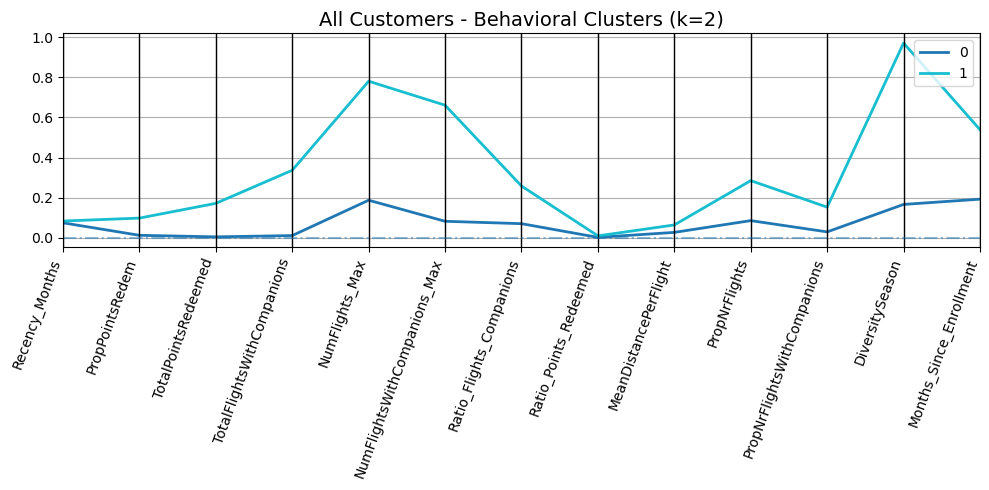

In [ ]:
number_clusters = 2 
km_behav_all = KMeans(n_clusters=number_clusters, init='k-means++', n_init=10, random_state=1)
km_labels_behav_all = km_behav_all.fit_predict(df_all[behavioral_segmentation].values)

# Show cluster sizes
print(f"\nCluster sizes:")
print(pd.Series(km_labels_behav_all).value_counts().sort_index())

# Calculate and print R² score
r2_behav_all = get_rsq(df_all, behavioral_segmentation, km_labels_behav_all)
print(f"\nR² score: {r2_behav_all:.4f}")

# Plot parallel coordinates
plot_parallel_coordinates_from_labels(
    df_all[behavioral_segmentation],
    km_labels_behav_all,
    behavioral_segmentation,
    title="All Customers - Behavioral Clusters (k=2)"
)

- Cluster 0: This segment consists of the most valuable and active flyers. They are characterized by high-volume, concentrated, and diverse travel, often with companions. They are the core of the airline's operational activity.
- Cluster 1: This segment is largely inactive. They contribute very little to the airline's revenue and activity metrics. This group likely includes new sign-ups, one-time flyers, and dormant customers.

check from here ! 

#### Active Customers 

####  Value-Based segmentation


--- SILHOUETTE ANALYSIS ---
For n_clusters = 2, the average silhouette_score is : 0.4082


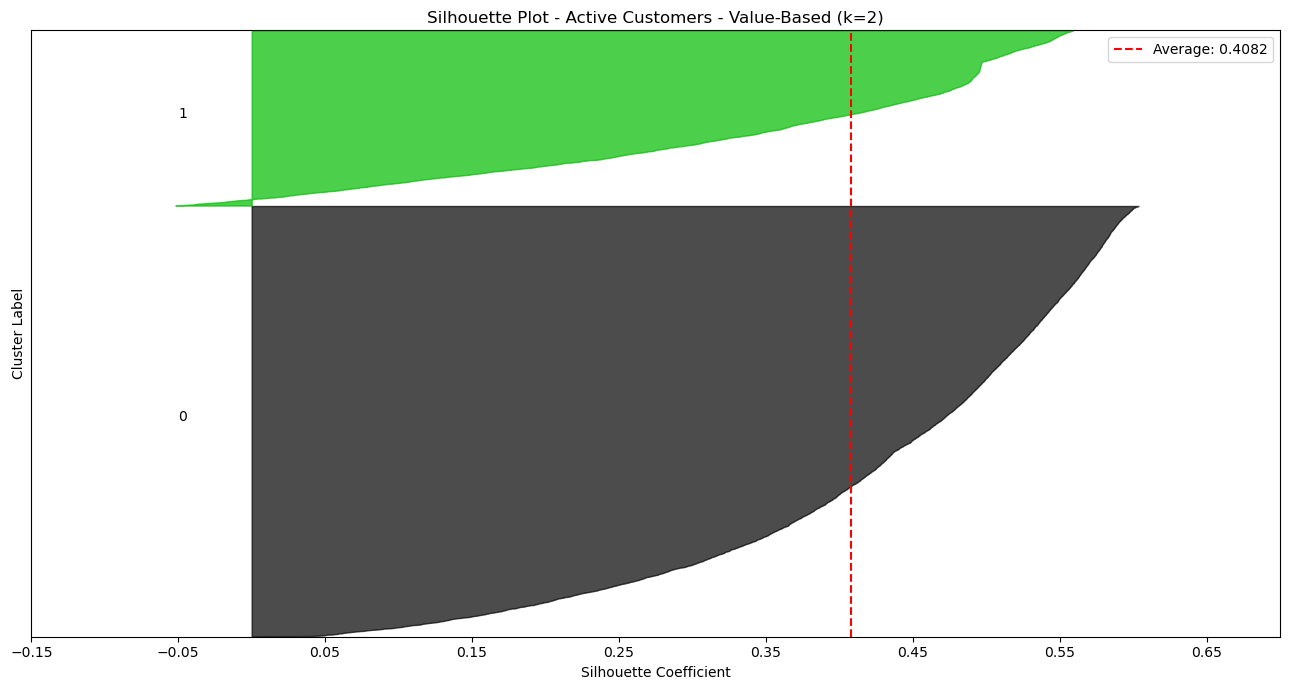

For n_clusters = 3, the average silhouette_score is : 0.3340


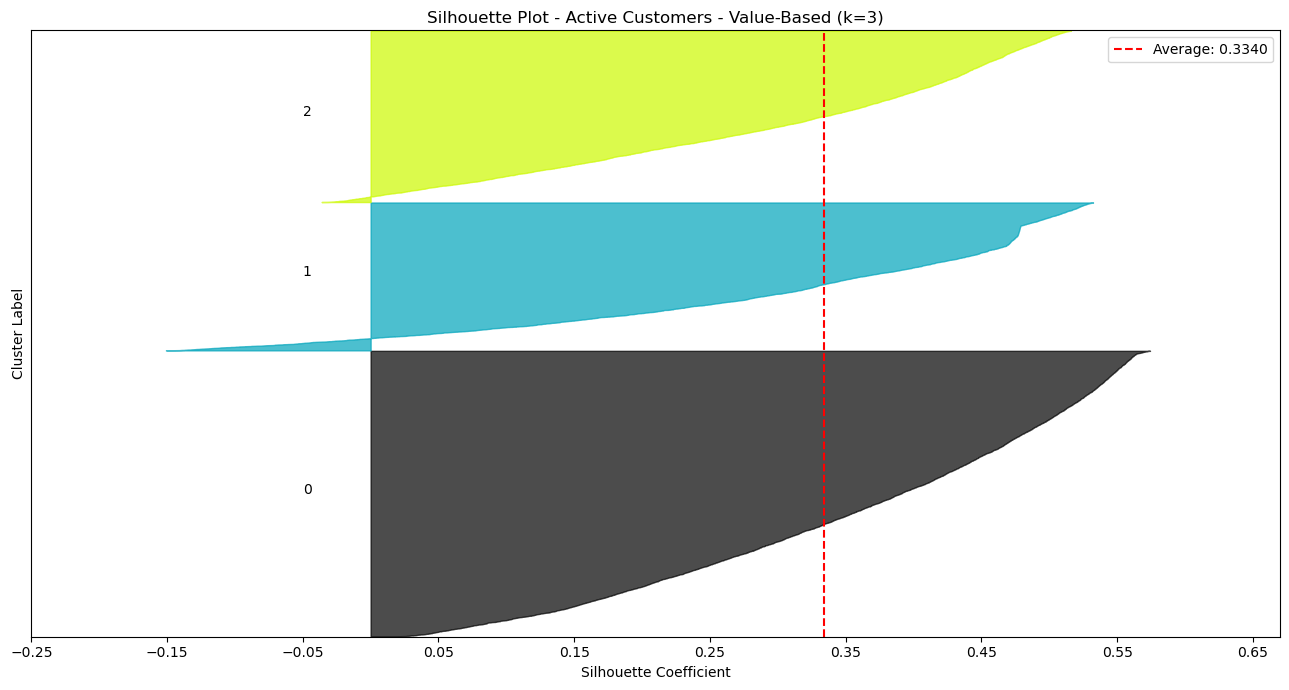

For n_clusters = 4, the average silhouette_score is : 0.2875


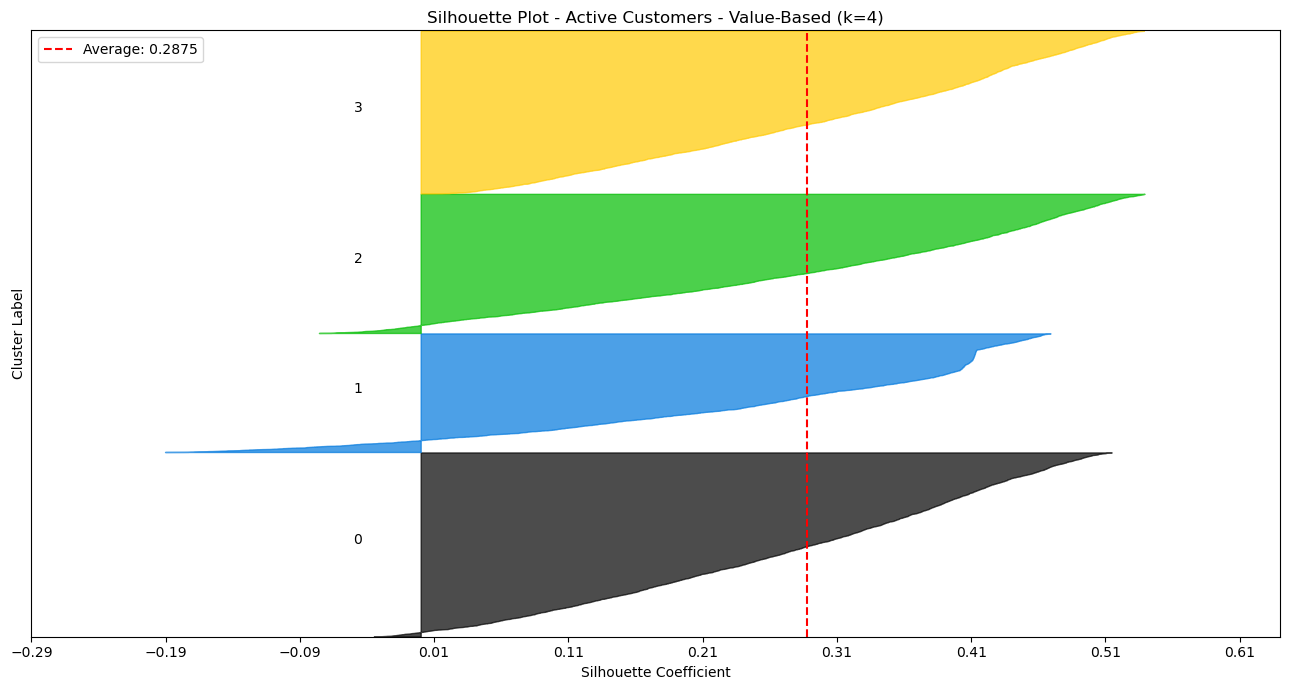

For n_clusters = 5, the average silhouette_score is : 0.3042


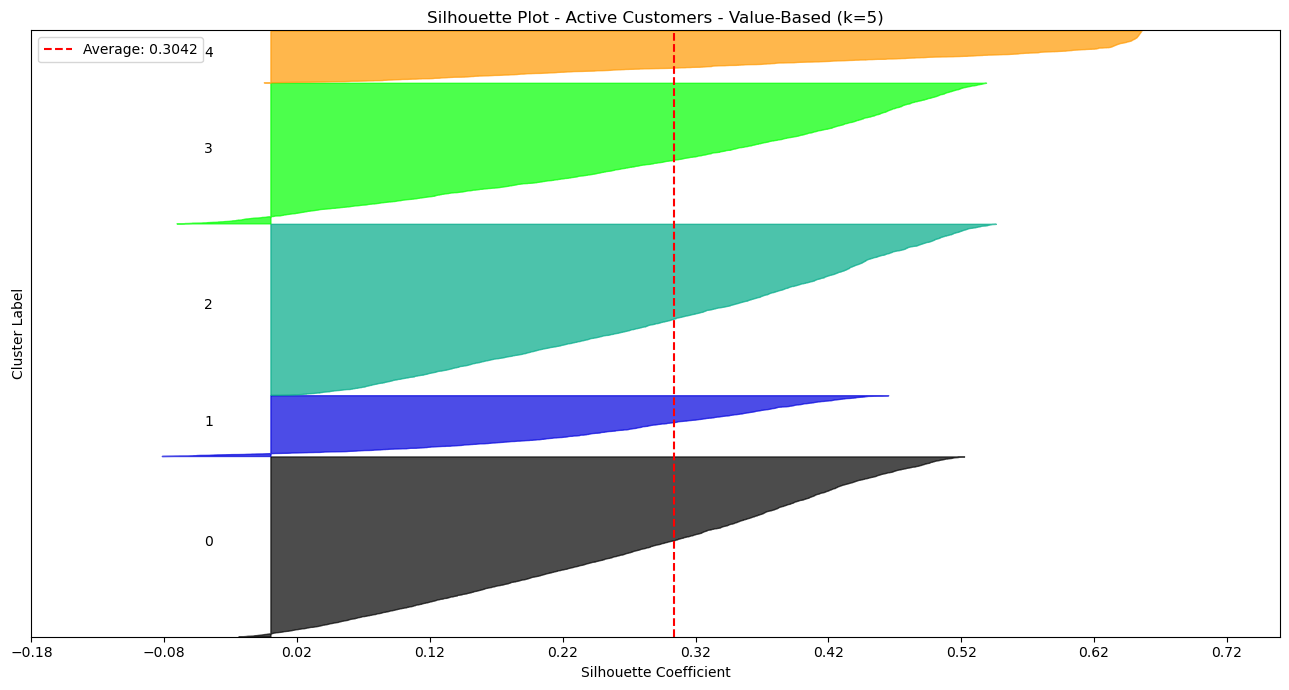

For n_clusters = 6, the average silhouette_score is : 0.2909


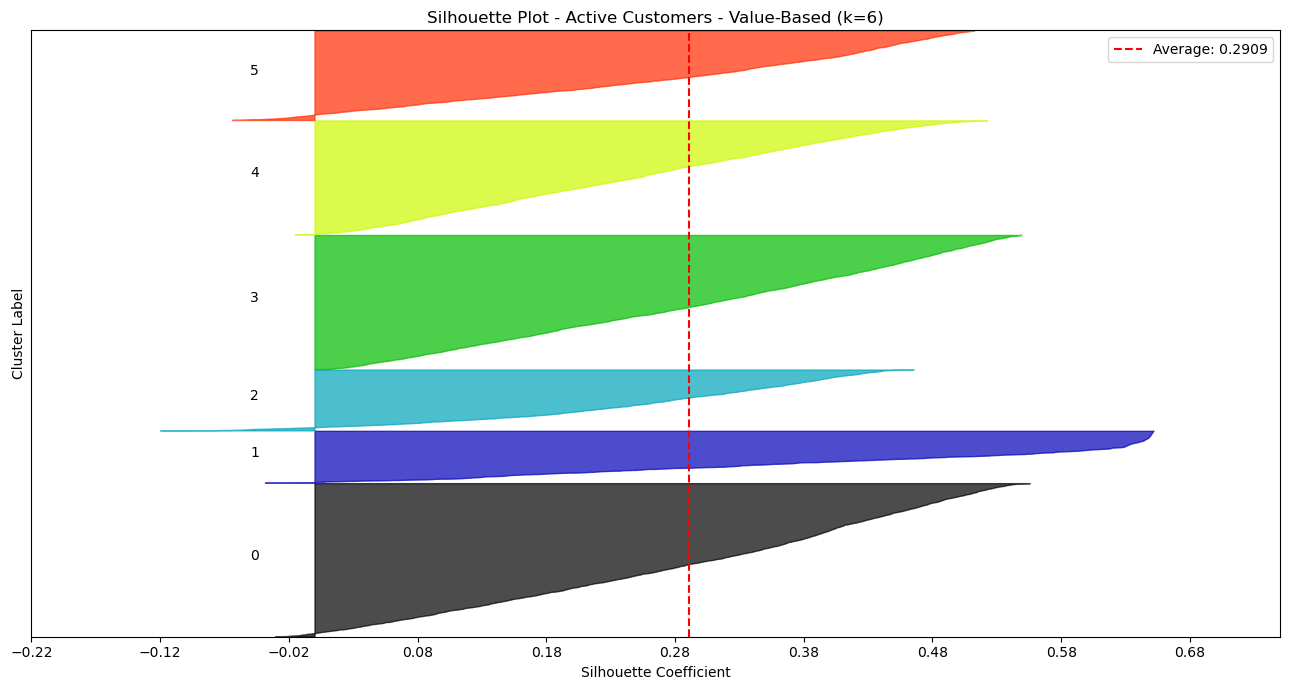

For n_clusters = 7, the average silhouette_score is : 0.2810


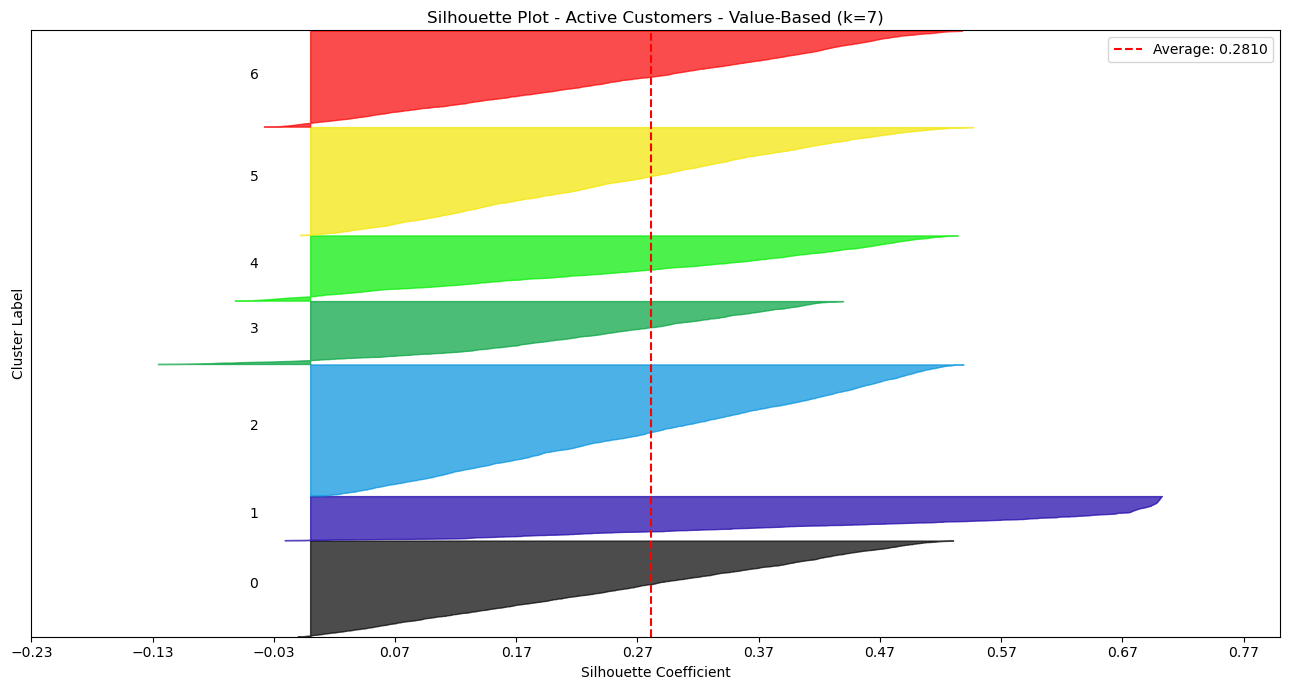

For n_clusters = 8, the average silhouette_score is : 0.2943


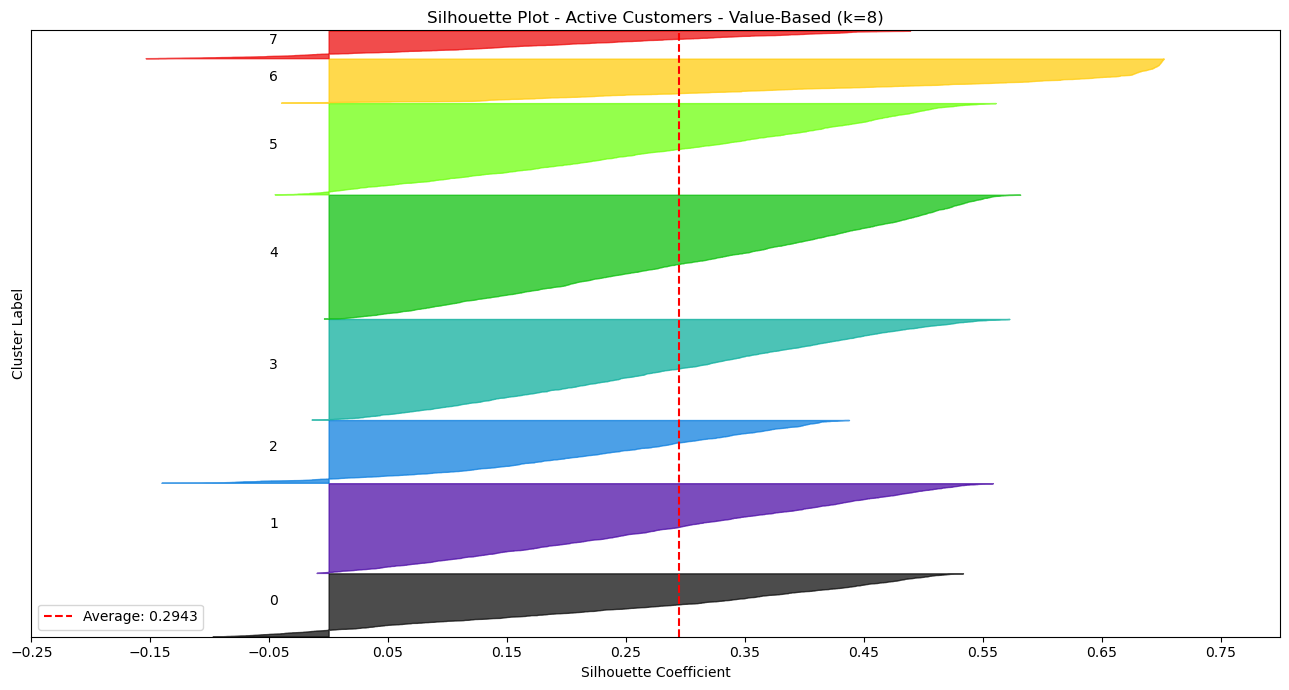

For n_clusters = 9, the average silhouette_score is : 0.3010


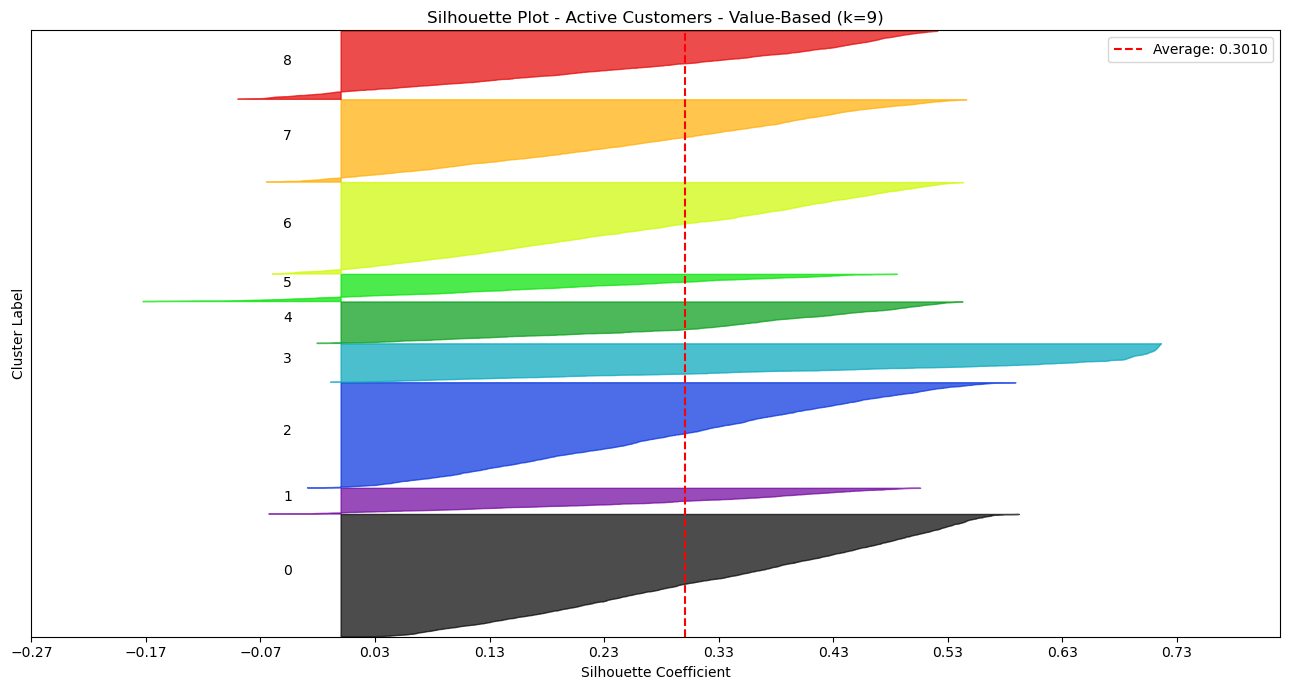

For n_clusters = 10, the average silhouette_score is : 0.2918


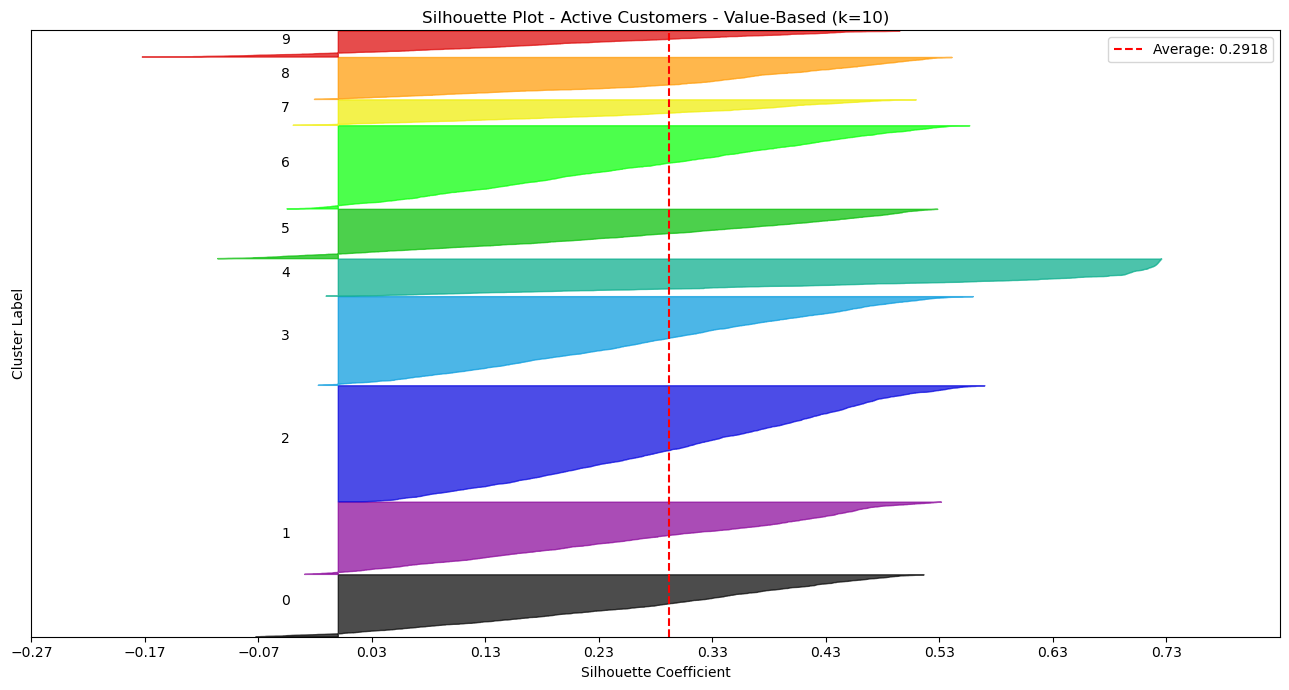


--- ELBOW AND CALINSKI-HARABASZ ANALYSIS ---


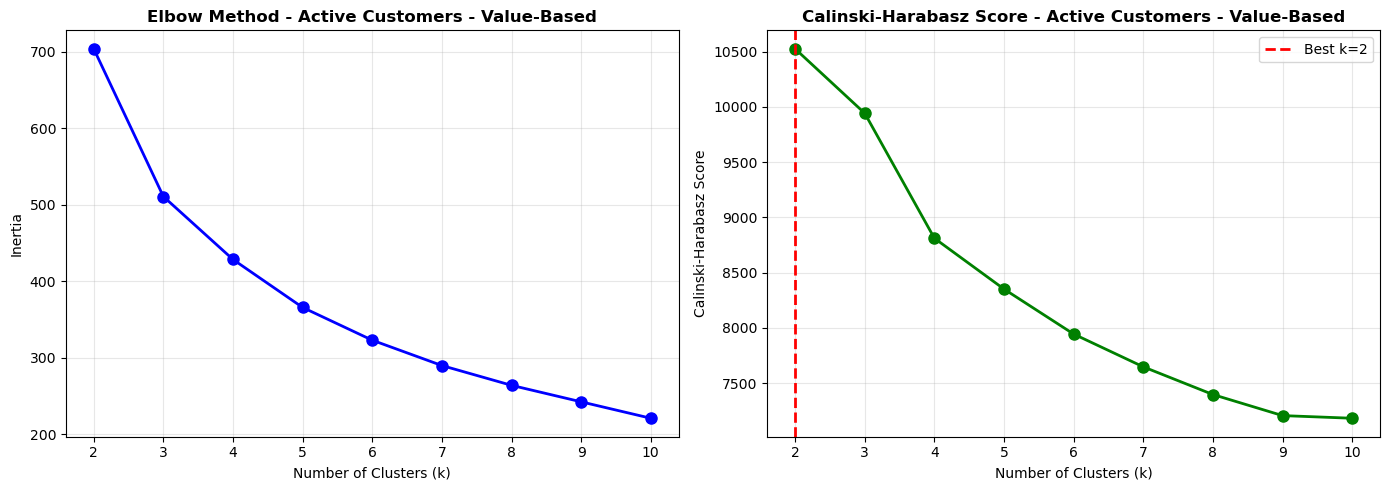


SUMMARY METRICS - Active Customers - Value-Based
 k  Inertia  Silhouette  Calinski-Harabasz
 2 703.7689      0.4082         10526.3862
 3 510.5861      0.3340          9942.8380
 4 428.2872      0.2875          8812.0435
 5 365.5693      0.3042          8351.8478
 6 322.7382      0.2909          7944.8176
 7 289.6173      0.2810          7648.1420
 8 263.7417      0.2943          7397.4408
 9 242.1759      0.3010          7206.7619
10 220.6916      0.2918          7182.7586


In [ ]:
k_range_active_value = range(2, 11)

# Silhouette analysis
print("\n--- SILHOUETTE ANALYSIS ---")
avg_sil_active_value = silhouette_analysis(df_active[value_segmentation].values, k_range_active_value, 'Active Customers - Value-Based')

# Elbow and CH analysis
print("\n--- ELBOW AND CALINSKI-HARABASZ ANALYSIS ---")
inertias_active_value, ch_active_value = elbow_and_ch_analysis(df_active[value_segmentation].values, k_range_active_value, 'Active Customers - Value-Based')

# Summary table
results_active_value = summary_metrics_table(df_active[value_segmentation].values, k_range_active_value, 'Active Customers - Value-Based')

To dive deeper into the caracteristics of each cluster ,we will create a Parallel Coordinates Plot with 2 clusters:


Cluster sizes:
0    10110
1     4106
Name: count, dtype: int64

R² score: 0.4255


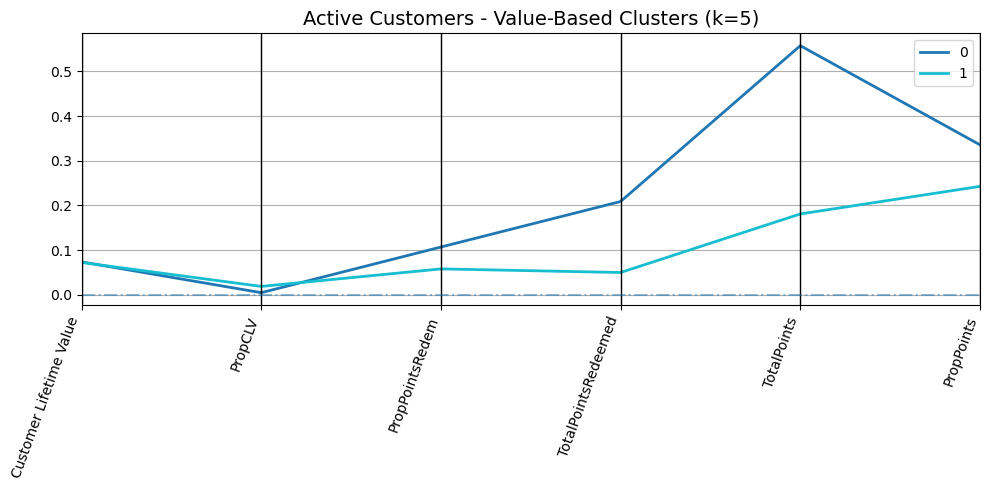

In [ ]:
number_clusters = 2
km_value_active = KMeans(n_clusters=number_clusters, init='k-means++', n_init=10, random_state=1)
km_labels_value_active = km_value_active.fit_predict(df_active[value_segmentation].values)

# Show cluster sizes
print(f"\nCluster sizes:")
print(pd.Series(km_labels_value_active).value_counts().sort_index())

# Calculate and print R² score
r2_value_active = get_rsq(df_active, value_segmentation, km_labels_value_active)
print(f"\nR² score: {r2_value_active:.4f}")

# Plot parallel coordinates
plot_parallel_coordinates_from_labels(
    df_active[value_segmentation],         
    km_labels_value_active,    
    value_segmentation,
    title="Active Customers - Value-Based Clusters (k=5)"
)

#### Behavioral segmentation


--- SILHOUETTE ANALYSIS ---
For n_clusters = 2, the average silhouette_score is : 0.5391


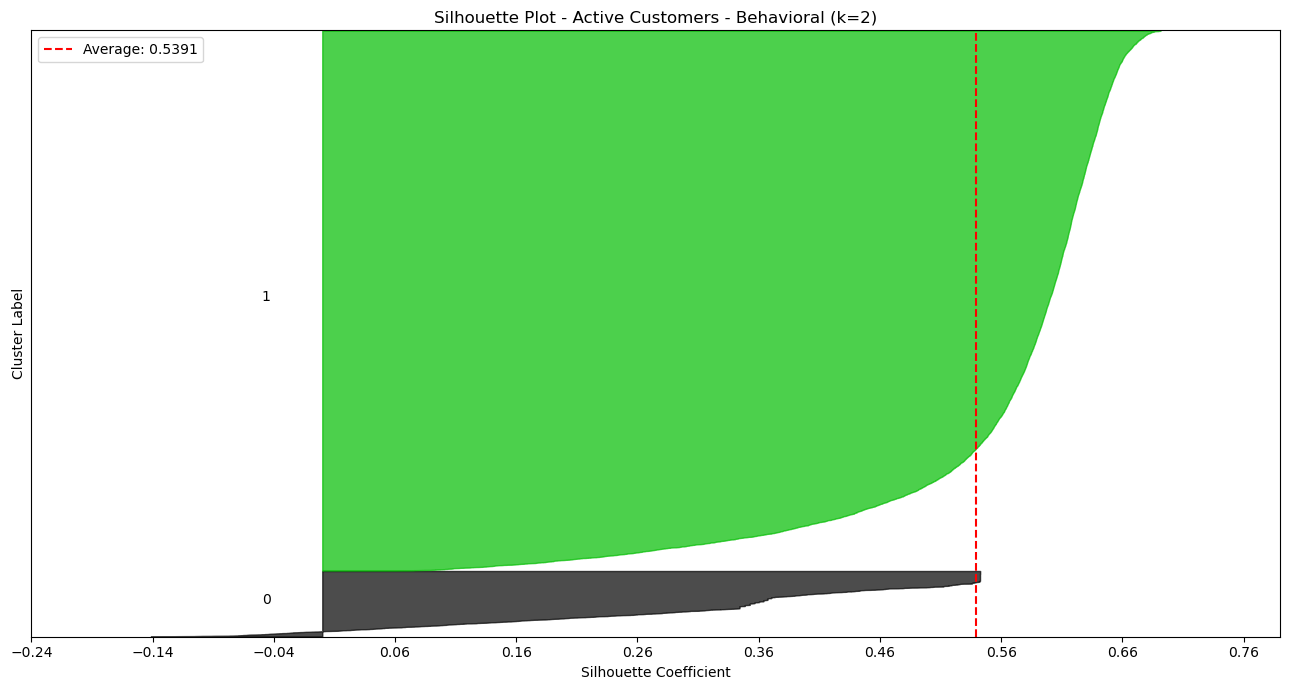

For n_clusters = 3, the average silhouette_score is : 0.2546


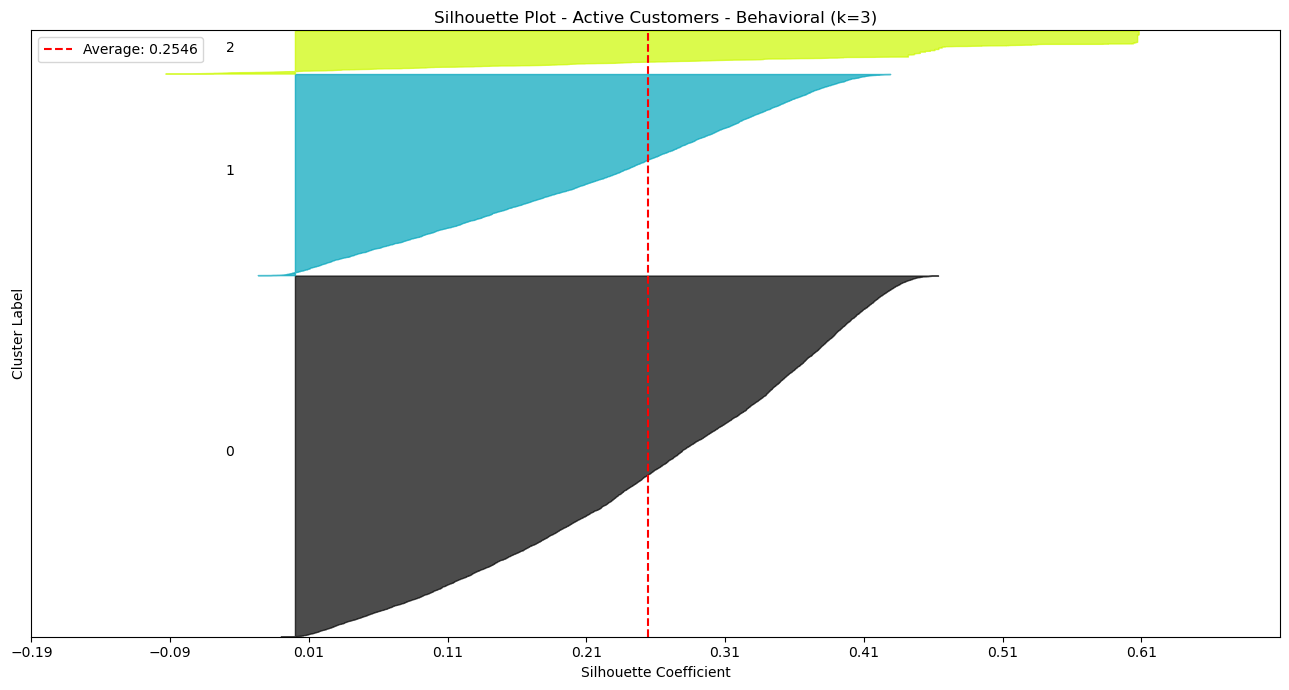

For n_clusters = 4, the average silhouette_score is : 0.2293


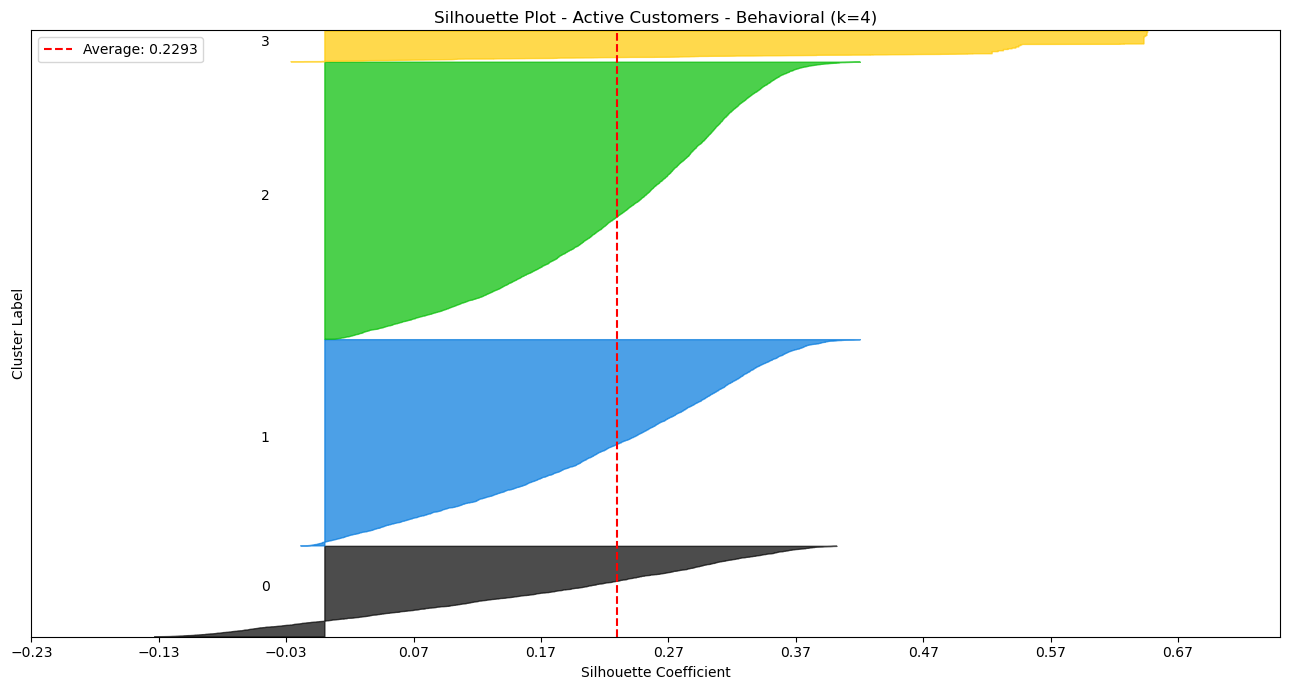

For n_clusters = 5, the average silhouette_score is : 0.2236


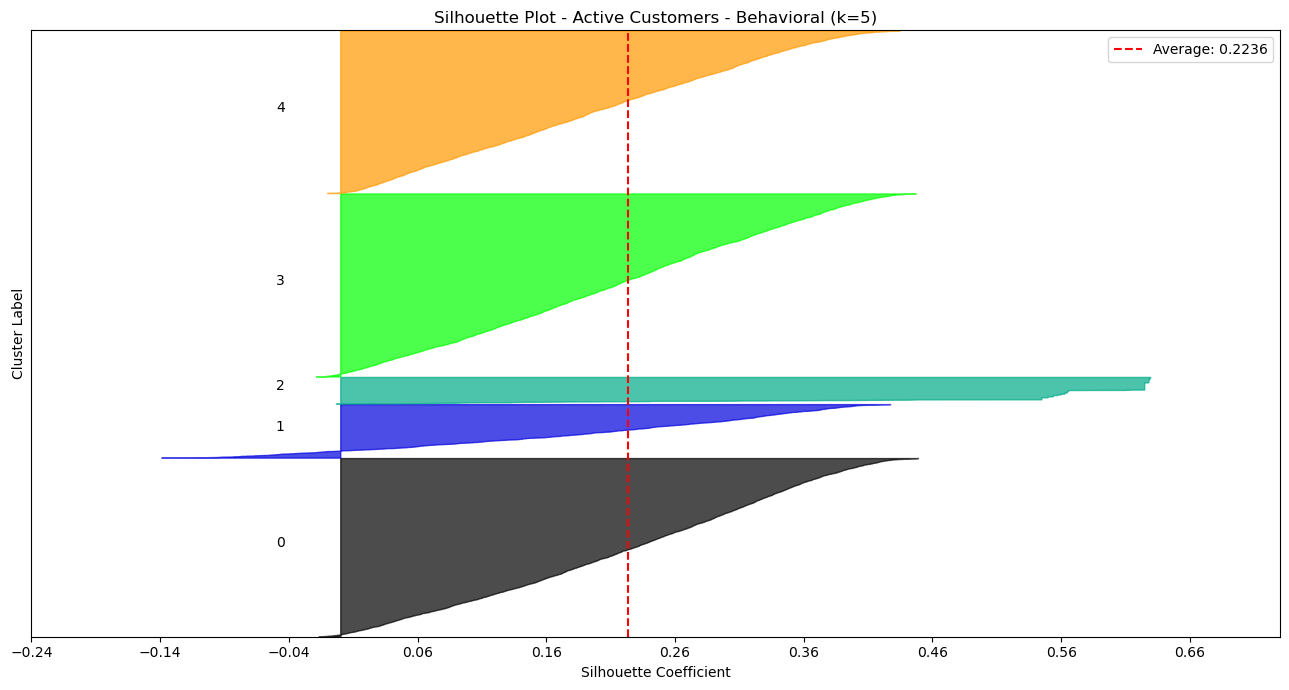

For n_clusters = 6, the average silhouette_score is : 0.2227


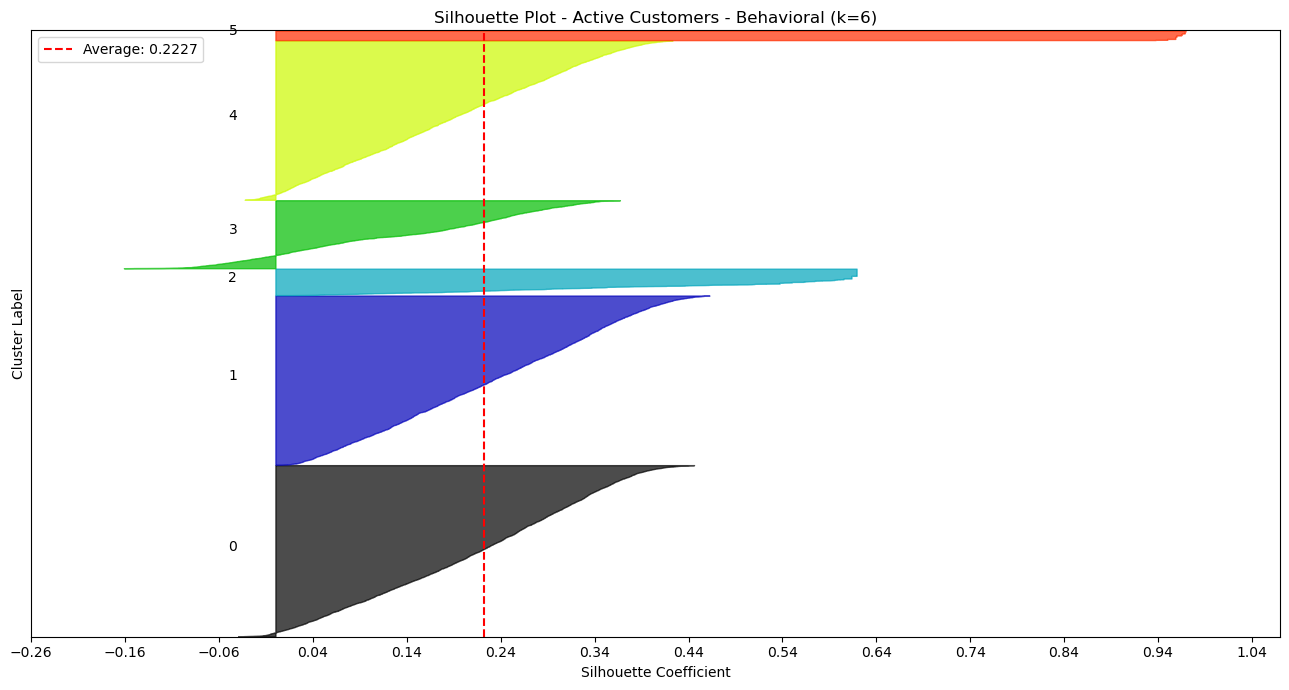

For n_clusters = 7, the average silhouette_score is : 0.2123


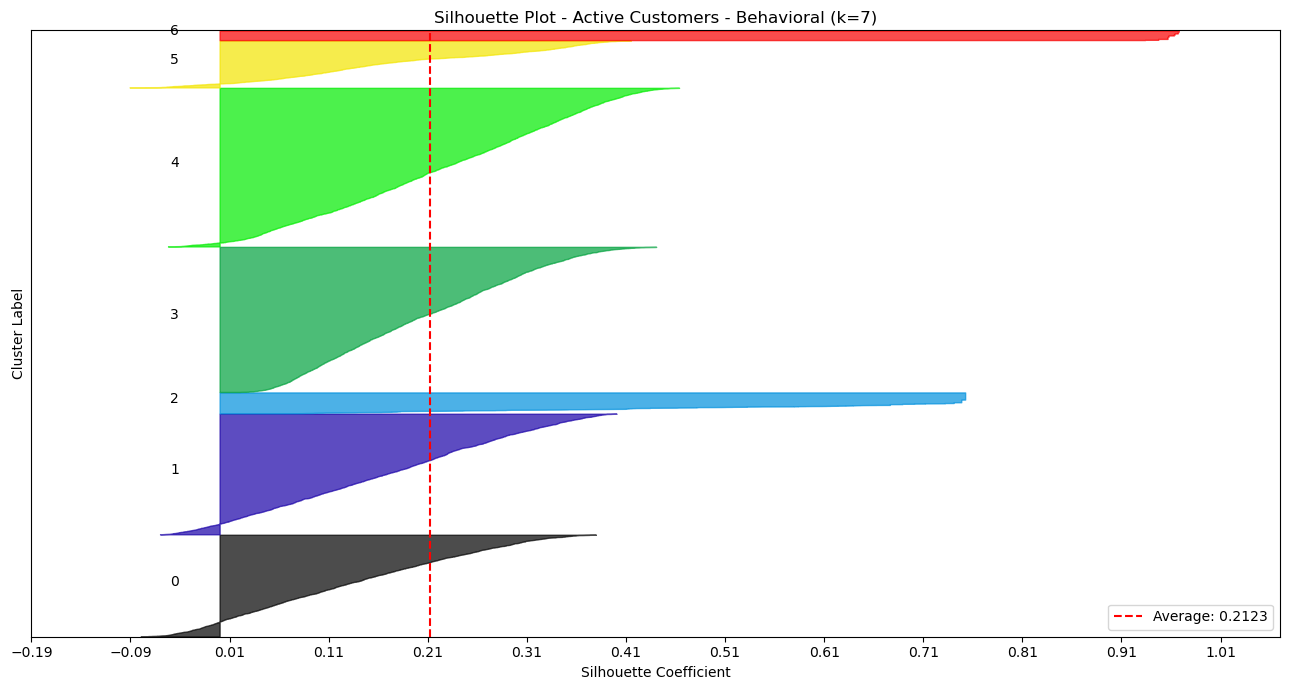

For n_clusters = 8, the average silhouette_score is : 0.2040


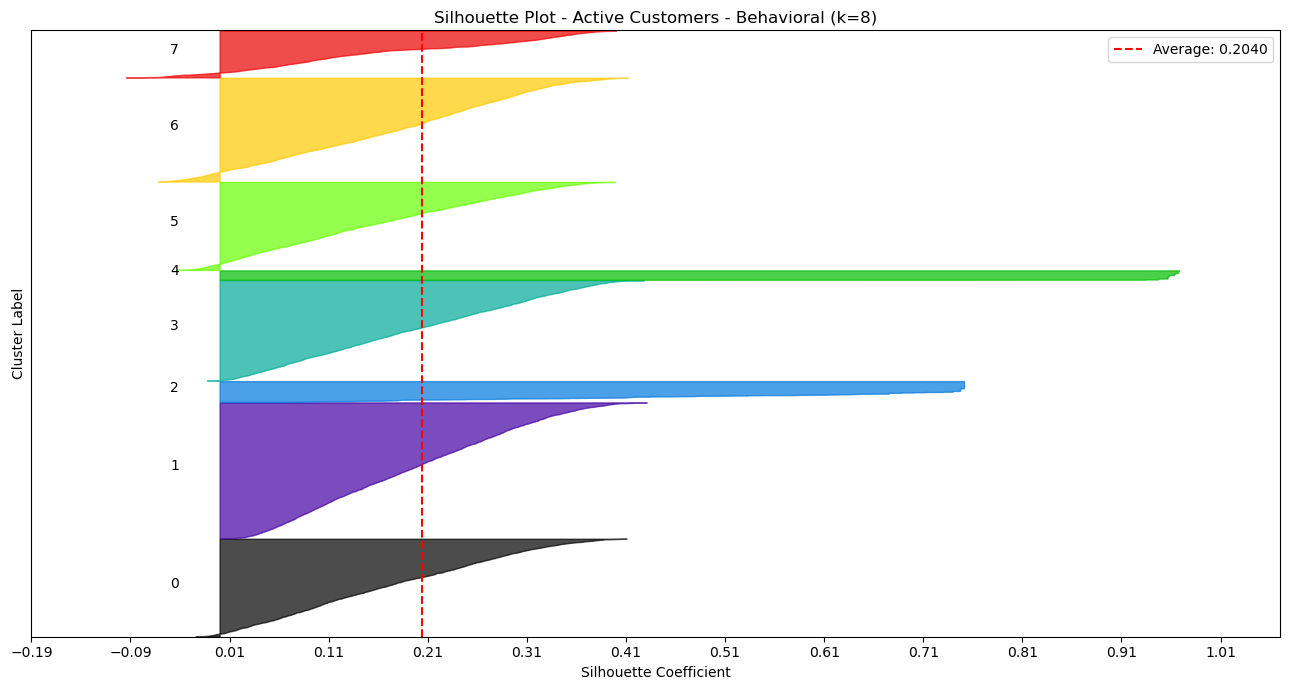

For n_clusters = 9, the average silhouette_score is : 0.2059


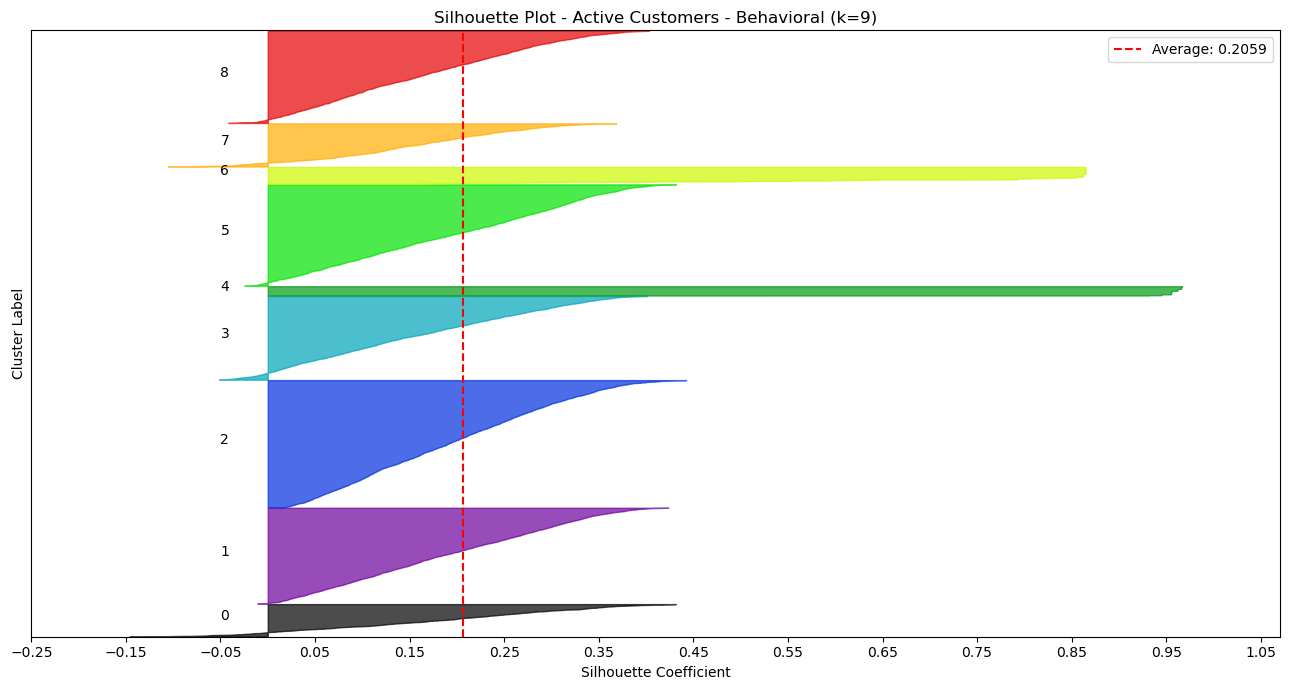

For n_clusters = 10, the average silhouette_score is : 0.2086


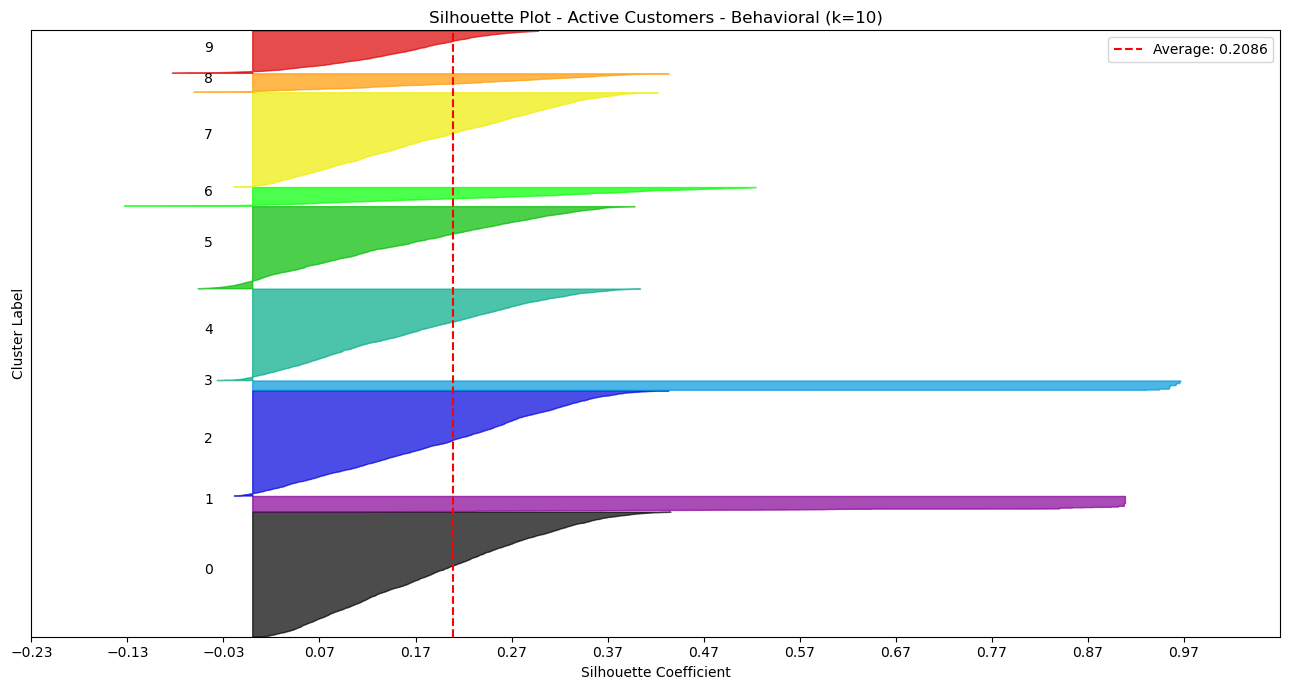


--- ELBOW AND CALINSKI-HARABASZ ANALYSIS ---


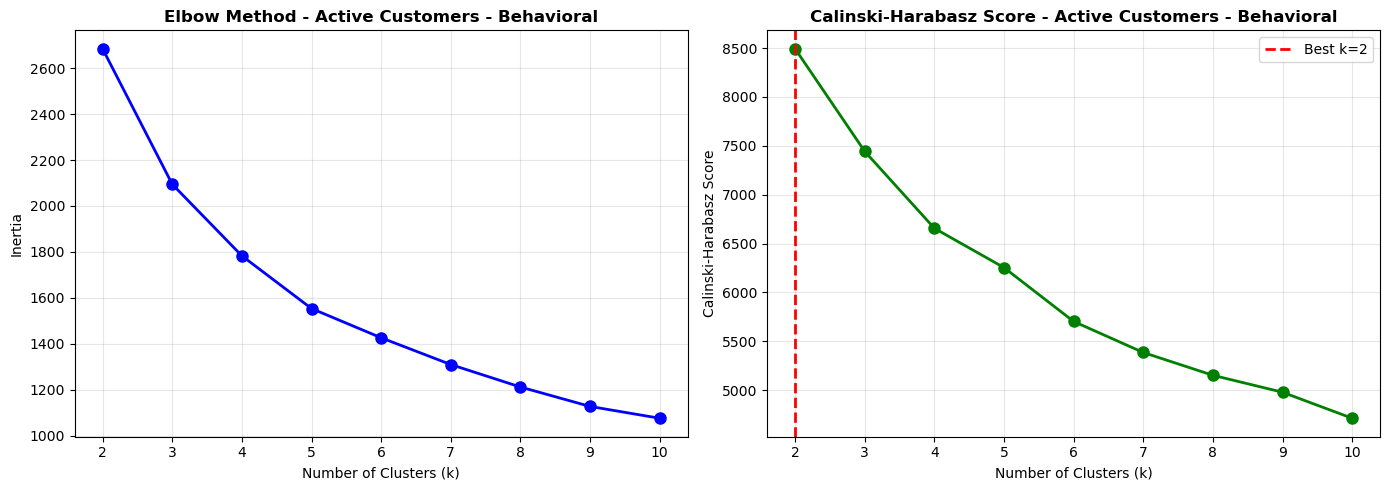


SUMMARY METRICS - Active Customers - Behavioral
 k   Inertia  Silhouette  Calinski-Harabasz
 2 2684.2218      0.5391          8492.2372
 3 2094.4424      0.2546          7442.5906
 4 1782.8417      0.2293          6656.4604
 5 1553.3396      0.2236          6254.4636
 6 1426.0425      0.2227          5703.5318
 7 1309.5182      0.2123          5386.2829
 8 1211.6875      0.2040          5153.0571
 9 1127.1780      0.2059          4979.7757
10 1075.6751      0.2086          4713.6616


In [ ]:
k_range_active_behav = range(2, 11)

# Silhouette analysis
print("\n--- SILHOUETTE ANALYSIS ---")
avg_sil_active_behav = silhouette_analysis(df_active[behavioral_segmentation].values, k_range_active_behav, 'Active Customers - Behavioral')

# Elbow and CH analysis
print("\n--- ELBOW AND CALINSKI-HARABASZ ANALYSIS ---")
inertias_active_behav, ch_active_behav = elbow_and_ch_analysis(df_active[behavioral_segmentation].values, k_range_active_behav, 'Active Customers - Behavioral')

# Summary table
results_active_behav = summary_metrics_table(df_active[behavioral_segmentation].values, k_range_active_behav, 'Active Customers - Behavioral')


Silhouette Plots:

* k=2 presents a very good average silhouette score of 0.5391  

Elbow Plot:
* Noticeable bend around k=3 or k=4, with inertia reductions flattening thereafter

Calinski-Harabasz Plot:

* Clear peak at k=2

* Silhouette presents visually the cleanest and strongest clustering of all the scenarios with k=2
* Calinski-Harabasz strongly agrees with k=2.
* Elbow points at k=3–4 for added granularity, but the resulting clusters are much weaker.


To go deep into the caracteristics of each clusters ,we will create a Parallel Coordinates Plot with 2 clusters:


Cluster sizes:
0     1535
1    12681
Name: count, dtype: int64

R² score: 0.3740


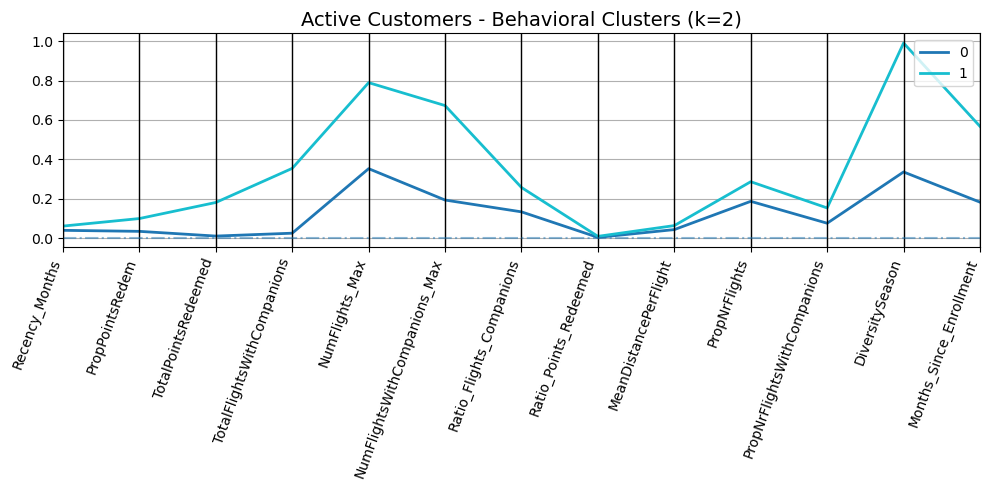

In [ ]:
number_clusters = 2
km_behav_active = KMeans(
    n_clusters=number_clusters,
    init='k-means++',
    n_init=10,
    random_state=1
)

km_labels_behav_active = km_behav_active.fit_predict(df_active[behavioral_segmentation].values)

# Show cluster sizes
print(f"\nCluster sizes:")
print(pd.Series(km_labels_behav_active).value_counts().sort_index())

# Calculate and print R² score
r2_behav_active = get_rsq(df_active, behavioral_segmentation, km_labels_behav_active)
print(f"\nR² score: {r2_behav_active:.4f}")

# Plot parallel coordinates
plot_parallel_coordinates_from_labels(
    df_active[behavioral_segmentation],
    km_labels_behav_active,
    behavioral_segmentation,
    title="Active Customers - Behavioral Clusters (k=2)"
)

- Cluster 0 : Elite, high-value customers with maximum diversification
- Cluster 1 : Solid, dependable customers with focused, routine usage patterns.

Now that we have all our models with both segmentation strategies, let's try to compare the results and choose the best solution :

In [ ]:
print("\n" + "="*80)
print("K-MEANS CLUSTERING ")
print("="*80)
print(f"All Customers - Value-Based:      k=2,  R²={r2_value_all:.4f}")
print(f"All Customers - Behavioral:       k=2,  R²={r2_behav_all:.4f}")
print(f"Active Customers - Value-Based:   k=2,  R²={r2_value_active:.4f}")
print(f"Active Customers - Behavioral:    k=2,  R²={r2_behav_active:.4f}")
print("="*80)


K-MEANS CLUSTERING 
All Customers - Value-Based:      k=2,  R²=0.4997
All Customers - Behavioral:       k=2,  R²=0.5018
Active Customers - Value-Based:   k=2,  R²=0.4255
Active Customers - Behavioral:    k=2,  R²=0.3740


### **3.3 Density Clustering**

#### **3.3.1 Mean Shift**

In [63]:
def mean_shift(df, perspective, quantile, random_state=1):
    bandwidth = estimate_bandwidth(df[perspective], quantile=quantile, random_state=random_state)

    mst = MeanShift(bandwidth=bandwidth, bin_seeding = True, n_jobs=4)

    ms_labels = mst.fit_predict(df[perspective])

    r2_1 = get_rsq(df, perspective, ms_labels)
    
    print(f"R² score: {r2_1:.4f}")
    print(len(np.unique(ms_labels)))
    return print(pd.Series(ms_labels).value_counts().sort_index())

##### **All Customers**

##### Value Segmentation

In [64]:
# All Customers - Value-Based
# quantille = 0.2; 2 clusters R2: 0.4833
# quantille = 0.1; 2 clusters R2: 0.4615
# quantille = 0.09; 3 clusters R2: 0.5803
# quantille = 0.08; 3 clusters R2: 0.5780
# quantille = 0.07; 5 clusters R2: 0.6050
# quantille = 0.06; 6 clusters R2: 0.6078

In [65]:
mean_shift(df_all, value_segmentation, quantile=0.09)

R² score: 0.5803
3
0    10991
1     1940
2     3465
Name: count, dtype: int64


##### Behavioural Segmentation

In [66]:
# All Customers - Behavioral Segmentation
# quantille = 0.2; 2 clusters R2: 0.4994
# quantille = 0.15; 2 clusters R2: 0.4993
# quantille = 0.1; 3 clusters R2: 0.5204
# quantille = 0.09; 4 clusters R2: 0.5777
# quantille = 0.08; 6 clusters R2: 0.6559
# quantille = 0.07; 6 clusters R2: 0.6482

In [67]:
mean_shift(df_all, behavioral_segmentation, quantile=0.09)

R² score: 0.5777
4
0    13698
1     1532
2      238
3      928
Name: count, dtype: int64


##### **Active Customers**

##### Value Segmentation

In [68]:
# Active Customers - Value Segmentation
# quantille = 0.1; 3 clusters R2: 0.4602 
# quantille = 0.01; 137 clusters R2: 0.8830 
# quantille = 0.03; 23 clusters R2: 0.6832 
# quantille = 0.04; 12 clusters R2: 0.6894 
# quantille = 0.05; 8 clusters R2: 0.5062 
# quantille = 0.06; 7 clusters R2: 0.5014 
# quantille = 0.07; 5 clusters R2: 0.4987 
# quantille = 0.08; 4 clusters R2: 0.4913 
# quantille = 0.09; 4 clusters R2: 0.4937 

In [72]:
mean_shift(df_active, value_segmentation, quantile=0.07)

R² score: 0.4987
5
0    10736
1     1359
2      711
3     1185
4      225
Name: count, dtype: int64


##### Behavioural Segmentation

In [70]:
# Active Customers - Behavioral Segmentation
# quantille = 0.3; 3 clusters R2: 0.4040
# quantille = 0.2; 2 clusters R2: 0.4002
# quantille = 0.1; 5 clusters R2: 0.4861
# quantille = 0.09; 5 clusters R2: 0.4809
# quantille = 0.08; 5 clusters R2: 0.4785
# quantille = 0.07; 5 clusters R2: 0.4768

In [71]:
mean_shift(df_active, behavioral_segmentation, quantile=0.1)

R² score: 0.4861
5
0    12507
1     1125
2      352
3      221
4       11
Name: count, dtype: int64


next

#### **3.3.2 HDBSCAN**

In [ ]:
from sklearn.cluster import HDBSCAN

##### **All Costumers**

##### Value Perspective

In [ ]:
results = []
for mcs in range(50, 400, 25):
    for ms in [5, 10, 20, 30]:
        hdb = HDBSCAN(min_cluster_size=mcs, min_samples=ms)
        labels = hdb.fit_predict(df_all[value_segmentation])

        noise = (labels == -1).mean()
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # R² só em pontos não-noise
        mask = labels != -1
        r2 = get_rsq(df_all.loc[mask], value_segmentation, labels[mask]) if mask.sum() > 0 else np.nan

        results.append((mcs, ms, n_clusters, noise, r2))

results_df = pd.DataFrame(results, columns=["min_cluster_size","min_samples","n_clusters","noise_ratio","r2_excl_noise"])
results_df.sort_values(["n_clusters","noise_ratio"], ascending=[True, True]).head(15)

min_cluster_size  min_samples  n_clusters  noise_ratio  r2_excl_noise
37               275           10           3     0.267382       0.623466
41               300           10           3     0.267382       0.623466
45               325           10           3     0.267382       0.623466
49               350           10           3     0.267382       0.623466
53               375           10           3     0.267382       0.623466
34               250           20           3     0.375091       0.670076
38               275           20           3     0.375091       0.670076
42               300           20           3     0.375091       0.670076
46               325           20           3     0.375091       0.670076
50               350           20           3     0.375091       0.670076
54               375           20           3     0.375091       0.670076
19               150           30           3     0.446328       0.725519
23               175           30           3     0.446328       0.725519
27               200           30           3     0.446328       0.725519
31               225           30           3     0.446328       0.725519

##### Behavioral Perspective

In [ ]:
results = []
for mcs in [300, 450, 600, 800]:
    for ms in [5, 10, 20, 30]:
        hdb = HDBSCAN(min_cluster_size=mcs, min_samples=ms)
        labels = hdb.fit_predict(df_all[behavioral_segmentation])

        noise = (labels == -1).mean()
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # R² só em pontos não-noise
        mask = labels != -1
        r2 = get_rsq(df_all.loc[mask], behavioral_segmentation, labels[mask]) if mask.sum() > 0 else np.nan

        results.append((mcs, ms, n_clusters, noise, r2))

results_df = pd.DataFrame(results, columns=["min_cluster_size","min_samples","n_clusters","noise_ratio","r2_excl_noise"])
results_df.sort_values(["n_clusters","noise_ratio"], ascending=[True, True]).head(15)

min_cluster_size  min_samples  n_clusters  noise_ratio  r2_excl_noise
14               800           20           2     0.043181       0.472589
13               800           10           3     0.095450       0.615477
7                450           30           3     0.108075       0.635345
11               600           30           3     0.108075       0.635345
15               800           30           3     0.108075       0.635345
10               600           20           3     0.116553       0.625221
8                600            5           4     0.030068       0.618954
12               800            5           4     0.030068       0.618954
5                450           10           4     0.051537       0.629944
9                600           10           4     0.051537       0.629944
6                450           20           4     0.081056       0.639190
1                300           10           5     0.083008       0.584990
4                450            5           5     0.094474       0.671872
2                300           20           5     0.112527       0.593249
3                300           30           5     0.135460       0.612241

##### **Active Costumers**

##### Value Perspective

##### Behavioral Perspective

#### **3.3.3 Gaussian Mixture Models (GMM)**

##### **All Costumers**

##### Value Segmentation

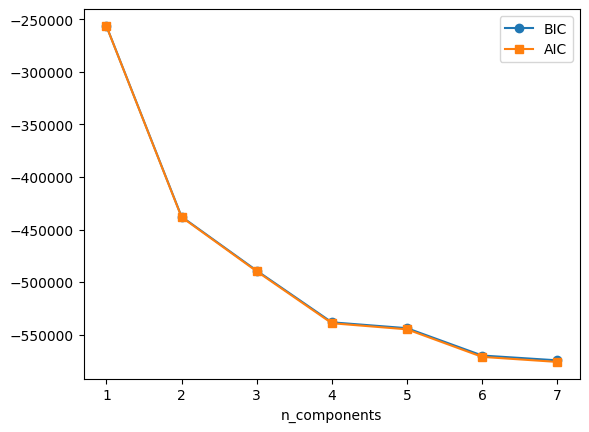

In [ ]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 8)

models = []
for n in n_components:
    model = GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_all[value_segmentation])
    models.append(model)

bic_values = [m.bic(df_all[value_segmentation]) for m in models]
aic_values = [m.aic(df_all[value_segmentation]) for m in models]
plt.plot(n_components, bic_values, 'o-', label='BIC')
plt.plot(n_components, aic_values, 's-', label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [ ]:
# Performing GMM clustering
gmm_all_val = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)

gmm_labels_all_val = gmm_all_val.fit_predict(df_all[value_segmentation])

In [ ]:
# Concatenating the labels to df
df_concat = pd.concat([df_all[value_segmentation], pd.Series(gmm_labels_all_val, index=df_all.index, name="gmm_labels_all_val")], axis=1)

df_concat['gmm_labels_all_val'].value_counts().sort_index()

gmm_labels_all_val
0    2885
1    3449
2    1091
3    8971
Name: count, dtype: int64

In [ ]:
r2_gmm_all_val = get_rsq(df_all, value_segmentation, gmm_labels_all_val)
print(f"GMM R² score: {r2_gmm_all_val:.4f}")

GMM R² score: 0.5060


In [ ]:
probabilities_all_val = gmm_all_val.predict_proba(df_all[value_segmentation])
probabilities_all_val

array([[1.20627216e-03, 0.00000000e+00, 5.45769289e-23, 9.98793728e-01],
       [2.83147542e-04, 0.00000000e+00, 1.27500648e-13, 9.99716852e-01],
       [2.09514046e-04, 0.00000000e+00, 1.90484408e-26, 9.99790486e-01],
       ...,
       [9.95386171e-01, 0.00000000e+00, 4.61382892e-03, 0.00000000e+00],
       [6.34426126e-42, 9.99997960e-01, 2.03963266e-06, 0.00000000e+00],
       [3.88577614e-04, 0.00000000e+00, 9.62981825e-12, 9.99611422e-01]],
      shape=(16396, 4))

In [ ]:
max_probs = probabilities_all_val.max(axis=1)

uncertain_threshold = 0.7

certain_customers = df_all[max_probs >= uncertain_threshold]
uncertain_customers = df_all[max_probs < uncertain_threshold]

print(f"GMM Probability Analysis All Customers:")
print(f"- Clear assignments (≥70% probability): {len(certain_customers):,} customers")
print(f"- Uncertain assignments (<70% probability): {len(uncertain_customers):,} customers ({len(uncertain_customers)/len(df_all):.1%})")


GMM Probability Analysis All Customers:
- Clear assignments (≥70% probability): 16,306 customers
- Uncertain assignments (<70% probability): 90 customers (0.5%)


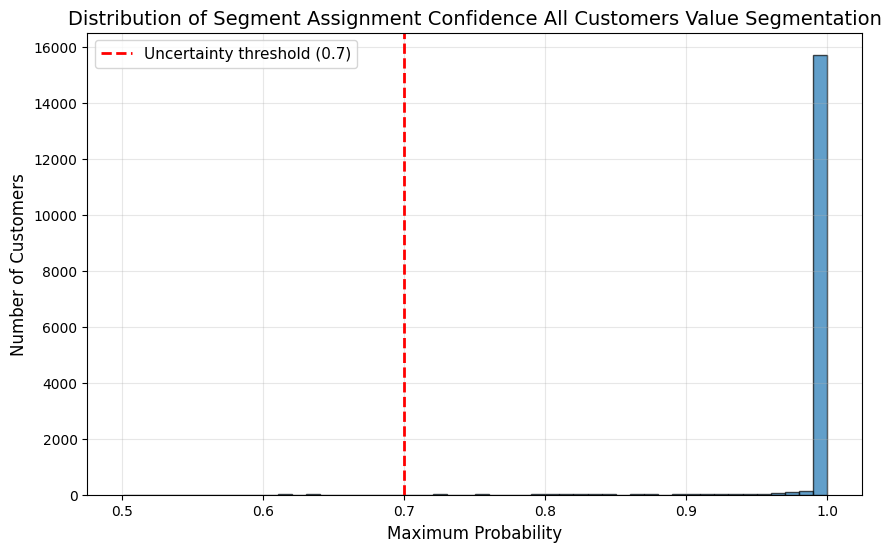

In [ ]:
# Show probability distribution
plt.figure(figsize=(10,6))
plt.hist(max_probs, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=uncertain_threshold, color='r', linestyle='--', linewidth=2, 
            label=f'Uncertainty threshold ({uncertain_threshold})')
plt.xlabel('Maximum Probability', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('Distribution of Segment Assignment Confidence All Customers Value Segmentation', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

##### Behavioural Segmentation

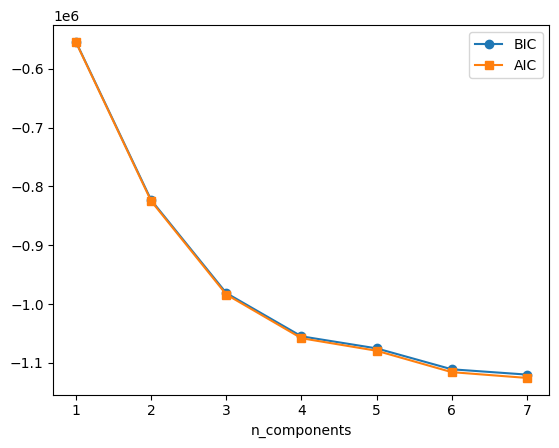

In [ ]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 8)

models = []
for n in n_components:
    model = GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_all[behavioral_segmentation])
    models.append(model)

bic_values = [m.bic(df_all[behavioral_segmentation]) for m in models]
aic_values = [m.aic(df_all[behavioral_segmentation]) for m in models]
plt.plot(n_components, bic_values, 'o-', label='BIC')
plt.plot(n_components, aic_values, 's-', label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [ ]:
# Performing GMM clustering
gmm_all_beh = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)

gmm_labels_all_beh = gmm_all_beh.fit_predict(df_all[behavioral_segmentation])

In [ ]:
# Concatenating the labels to df
df_concat = pd.concat([df_all[behavioral_segmentation], pd.Series(gmm_labels_all_beh, index=df_all.index, name="gmm_labels_all_beh")], axis=1)

df_concat['gmm_labels_all_beh'].value_counts().sort_index()

gmm_labels_all_beh
0    9134
1    1471
2    2896
3    2895
Name: count, dtype: int64

In [ ]:
r2_gmm_all_beh = get_rsq(df_all, behavioral_segmentation, gmm_labels_all_beh)
print(f"GMM R² score: {r2_gmm_all_beh:.4f}")

GMM R² score: 0.6179


In [ ]:
probabilities_all_beh = gmm_all_beh.predict_proba(df_all[behavioral_segmentation])
probabilities_all_beh

array([[9.99818855e-001, 0.00000000e+000, 1.81144661e-004,
        7.13443761e-021],
       [9.99998981e-001, 0.00000000e+000, 1.01918551e-006,
        2.30275841e-026],
       [9.99931884e-001, 0.00000000e+000, 6.81155507e-005,
        3.99822365e-018],
       ...,
       [3.18234669e-107, 0.00000000e+000, 9.99996522e-001,
        3.47811983e-006],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000],
       [9.99669360e-001, 0.00000000e+000, 3.30640299e-004,
        1.07927716e-016]], shape=(16396, 4))

In [ ]:
max_probs = probabilities_all_beh.max(axis=1)

uncertain_threshold = 0.7

certain_customers = df_all[max_probs >= uncertain_threshold]
uncertain_customers = df_all[max_probs < uncertain_threshold]

print(f"GMM Probability Analysis All Customers Behavioral Segmentation:")
print(f"- Clear assignments (≥70% probability): {len(certain_customers):,} customers")
print(f"- Uncertain assignments (<70% probability): {len(uncertain_customers):,} customers ({len(uncertain_customers)/len(df_all):.1%})")


GMM Probability Analysis All Customers Behavioral Segmentation:
- Clear assignments (≥70% probability): 16,234 customers
- Uncertain assignments (<70% probability): 162 customers (1.0%)


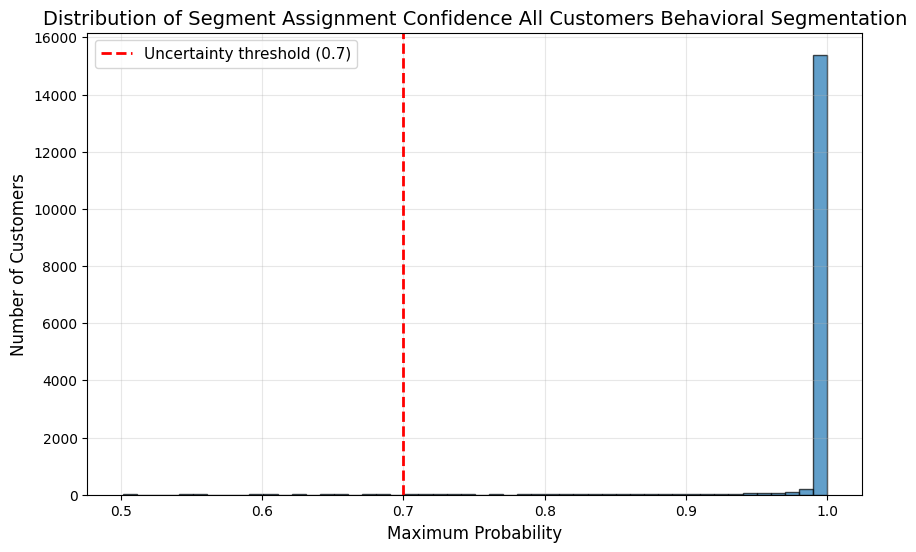

In [ ]:
# Show probability distribution
plt.figure(figsize=(10,6))
plt.hist(max_probs, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=uncertain_threshold, color='r', linestyle='--', linewidth=2, 
            label=f'Uncertainty threshold ({uncertain_threshold})')
plt.xlabel('Maximum Probability', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('Distribution of Segment Assignment Confidence All Customers Behavioral Segmentation', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

##### **Active Customers**

##### Value Segmentation

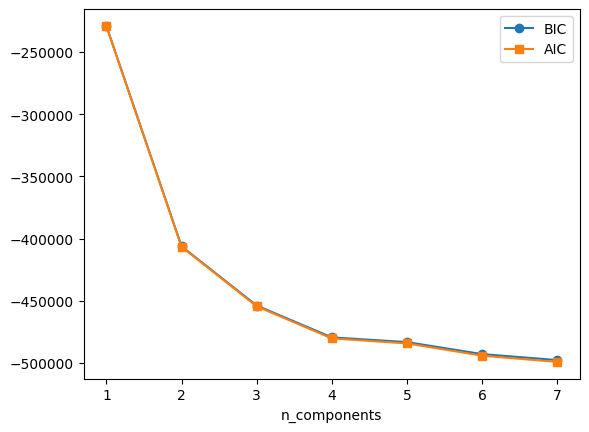

In [ ]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 8)

models = []
for n in n_components:
    model = GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_active[value_segmentation])
    models.append(model)

bic_values = [m.bic(df_active[value_segmentation]) for m in models]
aic_values = [m.aic(df_active[value_segmentation]) for m in models]
plt.plot(n_components, bic_values, 'o-', label='BIC')
plt.plot(n_components, aic_values, 's-', label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [ ]:
# Performing GMM clustering
gmm_active_val = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)

gmm_labels_active_val = gmm_active_val.fit_predict(df_active[value_segmentation])

In [ ]:
# Concatenating the labels to df
df_concat = pd.concat([df_active[value_segmentation], pd.Series(gmm_labels_active_val, index=df_active.index, name="gmm_labels_active_val")], axis=1)

df_concat['gmm_labels_active_val'].value_counts().sort_index()

gmm_labels_active_val
0    2718
1    8952
2     835
3    1711
Name: count, dtype: int64

In [ ]:
r2_gmm_active_val = get_rsq(df_active, value_segmentation, gmm_labels_active_val)
print(f"GMM R² score: {r2_gmm_active_val:.4f}")

GMM R² score: 0.4122


In [ ]:
probabilities_active_val = gmm_active_val.predict_proba(df_active[value_segmentation])
probabilities_active_val

array([[1.15344321e-03, 9.98846557e-01, 6.97281872e-33, 0.00000000e+00],
       [2.36898435e-04, 9.99763102e-01, 1.36052749e-21, 0.00000000e+00],
       [2.22736580e-04, 9.99777263e-01, 4.25775431e-28, 0.00000000e+00],
       ...,
       [9.85764346e-01, 0.00000000e+00, 1.42356545e-02, 0.00000000e+00],
       [3.85198711e-42, 0.00000000e+00, 3.56458314e-06, 9.99996435e-01],
       [3.21809901e-04, 9.99678190e-01, 7.10883558e-18, 0.00000000e+00]],
      shape=(14216, 4))

In [ ]:
max_probs = probabilities_active_val.max(axis=1)

uncertain_threshold = 0.7

certain_customers = df_active[max_probs >= uncertain_threshold]
uncertain_customers = df_active[max_probs < uncertain_threshold]

print(f"GMM Probability Analysis Active Customers:")
print(f"- Clear assignments (≥70% probability): {len(certain_customers):,} customers")
print(f"- Uncertain assignments (<70% probability): {len(uncertain_customers):,} customers ({len(uncertain_customers)/len(df_active):.1%})")

GMM Probability Analysis Active Customers:
- Clear assignments (≥70% probability): 14,169 customers
- Uncertain assignments (<70% probability): 47 customers (0.3%)


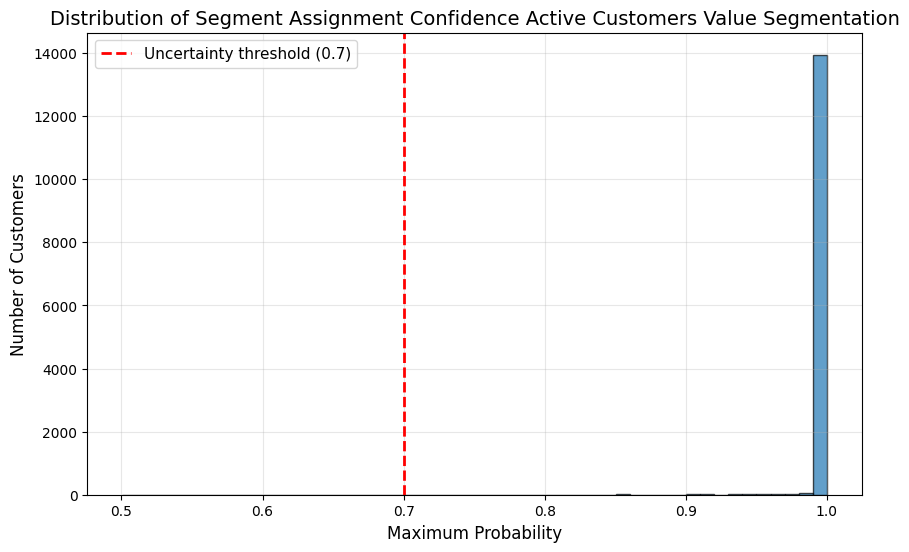

In [ ]:
# Show probability distribution
plt.figure(figsize=(10,6))
plt.hist(max_probs, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=uncertain_threshold, color='r', linestyle='--', linewidth=2, 
            label=f'Uncertainty threshold ({uncertain_threshold})')
plt.xlabel('Maximum Probability', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('Distribution of Segment Assignment Confidence Active Customers Value Segmentation', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

##### Behavioural Segmentation

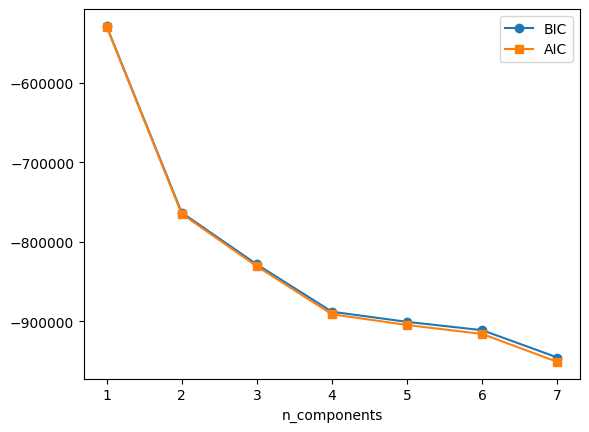

In [ ]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 8)

models = []
for n in n_components:
    model = GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_active[behavioral_segmentation])
    models.append(model)

bic_values = [m.bic(df_active[behavioral_segmentation]) for m in models]
aic_values = [m.aic(df_active[behavioral_segmentation]) for m in models]
plt.plot(n_components, bic_values, 'o-', label='BIC')
plt.plot(n_components, aic_values, 's-', label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [ ]:
# Performing GMM clustering
gmm_active_beh = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)

gmm_labels_active_beh = gmm_active_beh.fit_predict(df_active[behavioral_segmentation])

In [ ]:
# Concatenating the labels to df
df_concat = pd.concat([df_active[behavioral_segmentation], pd.Series(gmm_labels_active_beh, index=df_active.index, name="gmm_labels_active_beh")], axis=1)

df_concat['gmm_labels_active_beh'].value_counts().sort_index()

gmm_labels_active_beh
0    2619
1     736
2    1800
3    9061
Name: count, dtype: int64

In [ ]:
r2_gmm_active_beh = get_rsq(df_active, behavioral_segmentation, gmm_labels_active_beh)
print(f"GMM R² score: {r2_gmm_active_beh:.4f}")

GMM R² score: 0.6179


In [ ]:
probabilities_active_beh = gmm_active_beh.predict_proba(df_active[behavioral_segmentation])
probabilities_active_beh

array([[1.05854696e-003, 0.00000000e+000, 9.33296169e-023,
        9.98941453e-001],
       [9.07676158e-008, 0.00000000e+000, 5.35433006e-026,
        9.99999909e-001],
       [3.97048613e-004, 0.00000000e+000, 3.69887329e-018,
        9.99602951e-001],
       ...,
       [9.99994733e-001, 0.00000000e+000, 5.26741032e-006,
        1.84937154e-140],
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000,
        0.00000000e+000],
       [9.54932128e-004, 0.00000000e+000, 1.52594989e-017,
        9.99045068e-001]], shape=(14216, 4))

In [ ]:
max_probs = probabilities_active_beh.max(axis=1)

uncertain_threshold = 0.7

certain_customers = df_active[max_probs >= uncertain_threshold]
uncertain_customers = df_active[max_probs < uncertain_threshold]

print(f"GMM Probability Analysis Active Customers Behavioral Segmentation:")
print(f"- Clear assignments (≥70% probability): {len(certain_customers):,} customers")
print(f"- Uncertain assignments (<70% probability): {len(uncertain_customers):,} customers ({len(uncertain_customers)/len(df_active):.1%})")

GMM Probability Analysis Active Customers Behavioral Segmentation:
- Clear assignments (≥70% probability): 14,084 customers
- Uncertain assignments (<70% probability): 132 customers (0.9%)


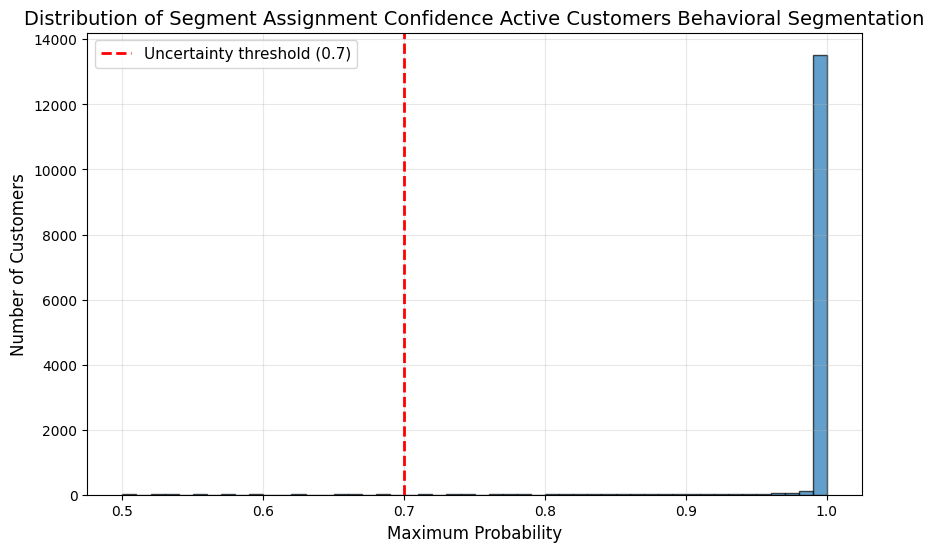

In [ ]:
# Show probability distribution
plt.figure(figsize=(10,6))
plt.hist(max_probs, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=uncertain_threshold, color='r', linestyle='--', linewidth=2, 
            label=f'Uncertainty threshold ({uncertain_threshold})')
plt.xlabel('Maximum Probability', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('Distribution of Segment Assignment Confidence Active Customers Behavioral Segmentation', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

### **3.4 Self-Organizing Maps (SOM)**

In [199]:
def train_som (data, topology='hexagonal', N = 20, M = 30):
    """
    Trains a Self-Organizing Map (SOM) on the provided data.

    Parameters:
    - data: pandas DataFrame of shape (n_samples, n_features)

    Returns:
    - som: trained MiniSom object
    """
    
    data = data.values  # Convert DataFrame to NumPy array
    n_feats = data.shape[1]

    sm = MiniSom(N, M,              
             n_feats,        
             learning_rate=0.5, 
             topology=topology, 
             neighborhood_function='gaussian', 
             sigma=1.8,
             activation_distance='euclidean',
             random_seed=42
             )
    
    # Initializes the weights of the SOM picking random samples from data
    sm.random_weights_init(data) 

    print("Before training:")
    print("QE", np.round(sm.quantization_error(data),4))
    if topology == 'rectangular':
        print("TE", np.round(sm.topographic_error(data),4))



    # Trains the SOM using all the vectors in data sequentially
    # minisom does not distinguish between unfolding and fine tuning phase;

    sm.train_batch(data, 500_000)

    print("After training:")
    print("QE", np.round(sm.quantization_error(data),4))
    if topology == 'rectangular':
        print("TE", np.round(sm.topographic_error(data),4))
    
    return sm

In [200]:
def plot_hexagons(som, sf, colornorm, matrix_vals, label="", cmap=cm.Grays, annot=False):

    '''
    Plots hexagonal grid representing the SOM.
    
    Parameters:
    - som: Trained MiniSom object
    - sf: matplotlib figure object
    - colornorm: Normalization for color mapping
    - matrix_vals: 2D array of values to plot (e.g., U-Matrix or component planes)
    - label: Title for the figure
    - cmap: Colormap to use
    - annot: Boolean to indicate if values should be annotated on hexagons



    '''
    
    axs = sf.subplots(1,1)
    
    for i in range(matrix_vals.shape[0]):
        for j in range(matrix_vals.shape[1]):

            wx, wy = som.convert_map_to_euclidean((i,j)) 

            hex = RegularPolygon((wx, wy), 
                                numVertices=6, 
                                radius= np.sqrt(1/3),
                                facecolor=cmap(colornorm(matrix_vals[i, j])), 
                                alpha=1, 
                                edgecolor='white',
                                linewidth=.5)
            axs.add_patch(hex)
            if annot==True:
                annot_val = np.round(matrix_vals[i,j],2)
                if int(annot_val) == annot_val:
                    annot_val = int(annot_val)
                axs.text(wx,wy, annot_val, 
                        ha='center', va='center', 
                        fontsize='x-small')


    ## Remove axes for hex plot
    axs.margins(.05)
    axs.set_aspect('equal')
    axs.axis("off")
    axs.set_title(label)

    

    # ## Add colorbar
    divider = make_axes_locatable(axs)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])

    ## Create custom colorbar 
    cb1 = colorbar.Colorbar(ax_cb,
                            orientation='vertical', 
                            alpha=1,
                            mappable=cmap_sm
                            )
    cb1.ax.get_yaxis().labelpad = 6

    # Add colorbar to plot
    sf.add_axes(ax_cb)

    return sf 

In [201]:
def plot_component_planes(som, data, max_cols=3, figsize=(12, 8)):
    """
    Plots the component planes of the trained SOM.

    Parameters:
    - som: trained MiniSom object
    - data: pandas DataFrame of shape (n_samples, n_features)
    - max_cols: maximum number of columns in the grid
    - figsize: figure size
    """
    
    weights = som.get_weights()
    n_features = len(data.columns)

    n_cols = min(max_cols, n_features)
    n_rows = ceil(n_features / n_cols)

    fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128)
    subfigs = fig.subfigures(n_rows, n_cols).ravel()[:n_features]

    for cpi, sf in zip(range(n_features), subfigs):
        matrix_vals = weights[:, :, cpi]
        colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))

        sf = plot_hexagons(som, sf, 
                            colornorm,
                            matrix_vals,
                            label=data.columns[cpi],
                            cmap=cm.coolwarm)
    
    plt.show()


In [202]:
def plot_hitmap(som, data ):

    """
    Plots the hits map of the trained SOM.

    Parameters:
    - som: trained MiniSom object
    - data: pandas DataFrame of shape (n_samples, n_features)

    """

    hitsmatrix = som.activation_response(data.values)

    fig = plt.figure(figsize=(20,15))

    colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

    fig = plot_hexagons(som, fig, 
                        colornorm,
                        hitsmatrix,
                        label="SOM Hits Map",
                        cmap=cm.Greens,
                        annot=True
                        )

In [203]:
def plot_u_matrix(som):
    
    """
    Plots the U-Matrix of the trained SOM.

    Parameters:
    - som: trained MiniSom object

    """

    umatrix = som.distance_map(scaling='mean')
    fig = plt.figure(figsize=(20,15))

    colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

    fig = plot_hexagons(som, fig, 
                        colornorm,
                        umatrix,
                        label="U-matrix",
                        cmap=cm.RdYlBu_r,
                        annot=True
                        )


#### **Active costumers**

**Value Segmentation**

In [204]:
# Train SOM for all customers - value segmentation and get the quality metrics
# sm_all_value = train_som(df_all[value_segmentation], toplogy='rectangular', N = 20, M = 30)
# sm_all_value = train_som(df_all[value_segmentation], toplogy='rectangular', N = 12, M = 12)
# sm_all_value = train_som(df_all[value_segmentation], toplogy='hexagonal', N = 20, M = 30)
sm_all_value = train_som(df_all[value_segmentation])

Before training:
QE 0.0365
After training:
QE 0.0334


We experimented with 20 x 30, 12 x 12 and 50 x 50. The results were the following:  

sm_all_value = train_som(df_all[value_segmentation], topology = 'rectangular)    ( 20 X 30 )  

Before training:  
QE 0.0365  
TE 0.9816  
After training:  
QE 0.0333  
TE 0.0847  



sm_all_value = train_som(df_all[value_segmentation], topology = 'rectangular, N=12, M=12)    

Before training:  
QE 0.0582  
TE 0.9653  
After training:  
QE 0.0533  
TE 0.0619  





sm_all_value = train_som(df_all[value_segmentation], topology = 'rectangular, N=50, M=50)  

Before training:  
QE 0.0209  
TE 0.9973  
After training:  
QE 0.0196  
TE 0.1012  

While larger maps achieved lower QE, they also exhibited higher TE, indicating reduced topology preservation. The 12×12 SOM showed insufficient resolution, whereas the 50×50 SOM resulted in over-fragmentation, it showed a higher topographic error. The 20×30 SOM provided the best balance between representation accuracy and topological stability and was therefore selected for further analysis. We chose to continue with the 20 X 30 SOM.

After that we switched the topology from 'rectangular' to 'hexagonal' in order to do continue the analysis ( proceed with the visualizations)

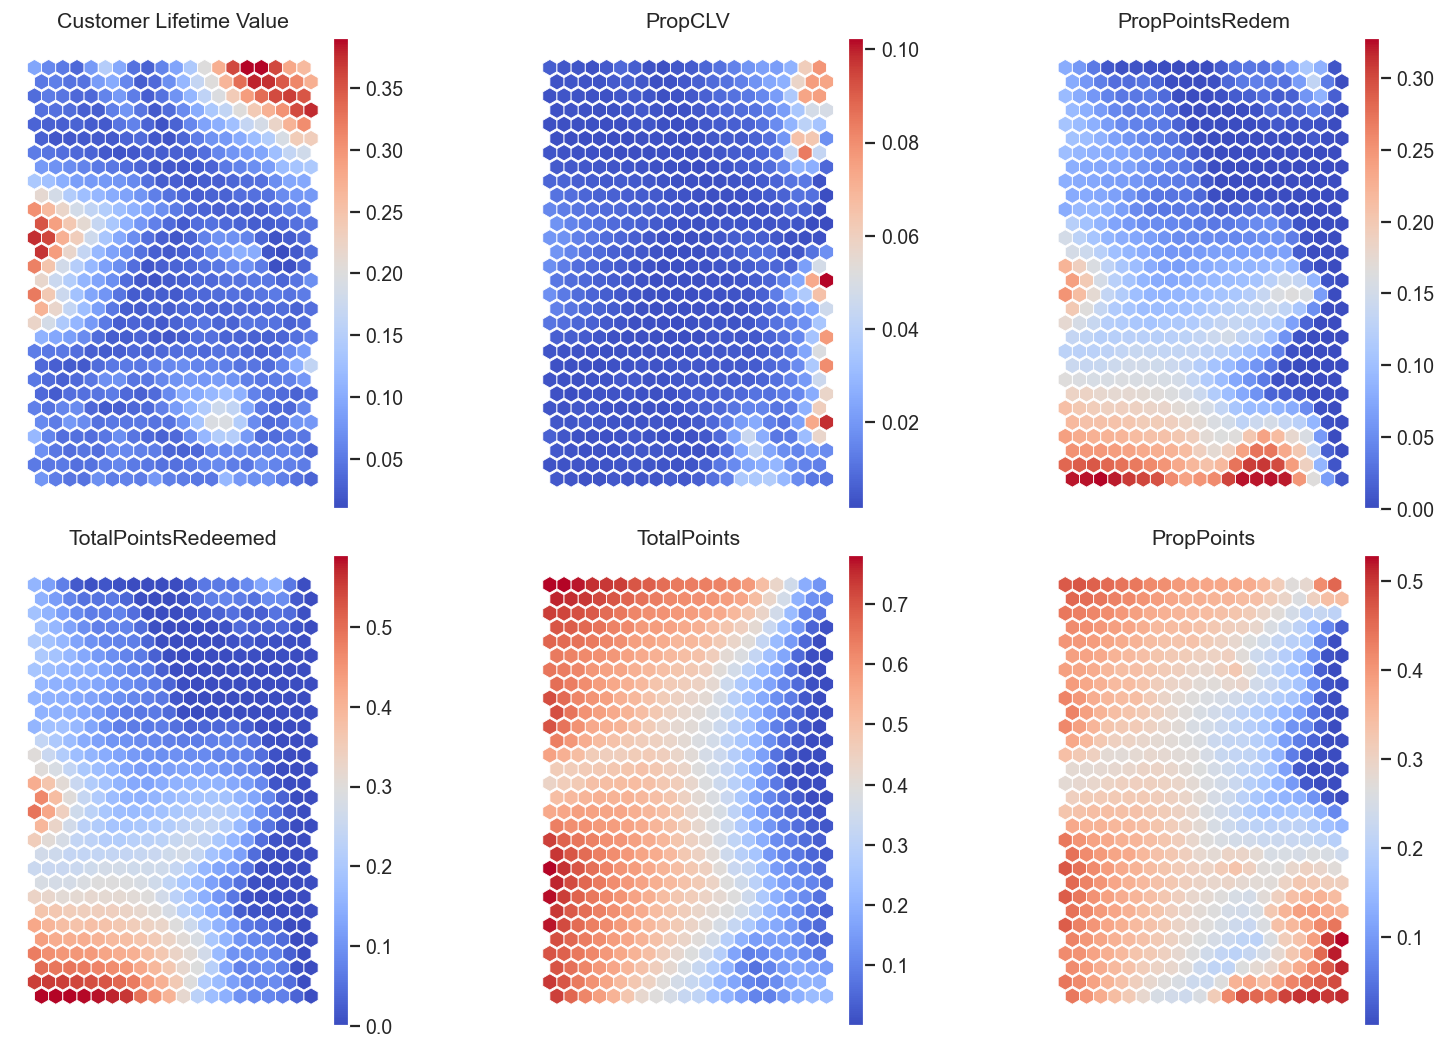

In [205]:
# Plot component planes ( for all features see their value in the hexagons)
plot_component_planes(sm_all_value, df_all[value_segmentation])

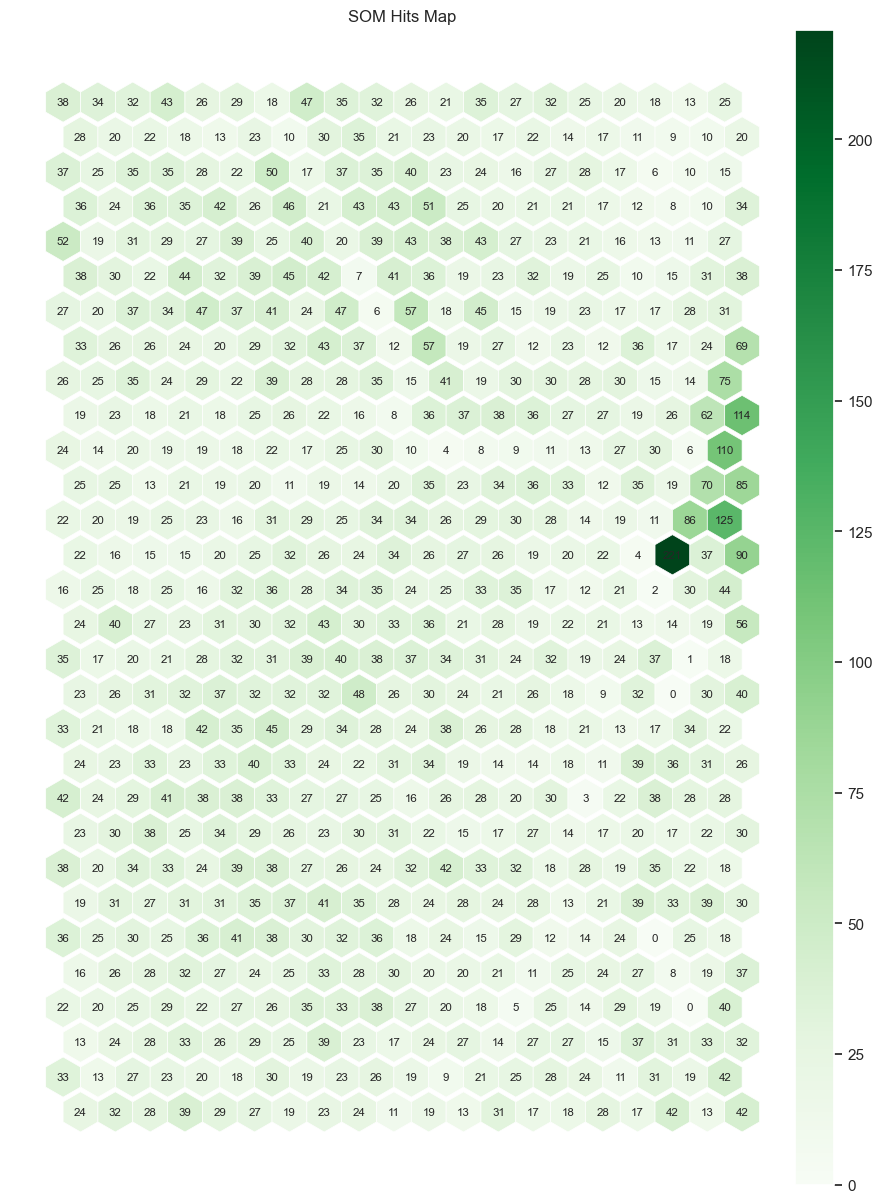

In [206]:
# Counts the number of data samples mapped to each neuron
plot_hitmap(sm_all_value, df_all[value_segmentation])

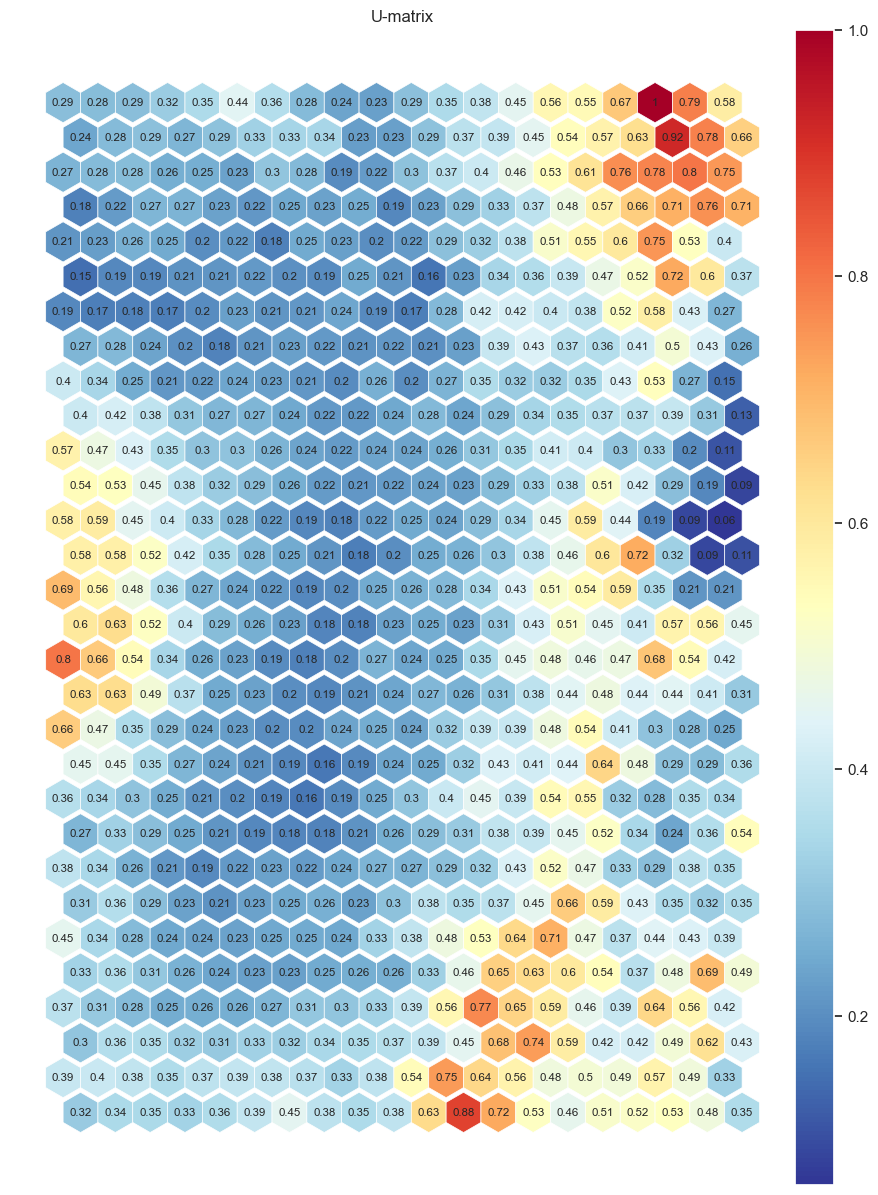

In [207]:
# Plot U-Matrix ( distance between neighboring neurons)
plot_u_matrix(sm_all_value)

**K-means on SOM units**

In [ ]:
weights_all_value = sm_all_value.get_weights()
weights_all_value_df = pd.DataFrame(weights_all_value.reshape(20 * 30, len(value_segmentation)), columns=value_segmentation)

0    252
1    152
2    196
Name: count, dtype: int64
SOM with Kmeans R² score: 0.6087


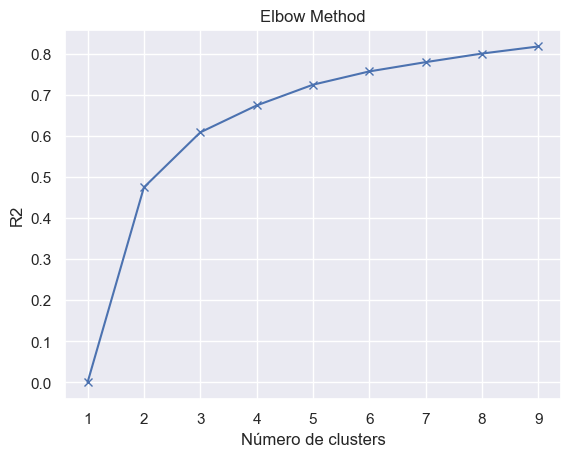

In [222]:
r2 = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='k-means++')
    kmeans_labels = kmeans.fit_predict(weights_all_value_df)
    r2.append(get_rsq(weights_all_value_df, value_segmentation, kmeans_labels)) 

plt.plot(K, r2, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('R2')
plt.title('Elbow Method')
plt.show()

The R2 starts to stabilize at 2 clusters, however, the score is very low. It seems that 4 is a better option since the R2 value is higher and there still tha values keep increasing significantly after that.

In [224]:
kmeans_som_all_value_3 = KMeans(n_clusters=3, random_state=42, n_init=10, init='k-means++')

kmeans_units_labels_all_value_3 = kmeans_som_all_value_3.fit_predict(weights_all_value_df)
# Print cluster counts for Kmeans with 4 clusters and get the R² score
print(pd.Series(kmeans_units_labels_all_value_3).value_counts().sort_index())
r2_db = get_rsq(weights_all_value_df, value_segmentation, kmeans_units_labels_all_value_3)
print(f"SOM with Kmeans R² score: {r2_db:.4f}")

0    252
1    152
2    196
Name: count, dtype: int64
SOM with Kmeans R² score: 0.6087


In [228]:
kmeans_som_all_value_4 = KMeans(n_clusters=4, random_state=42, n_init=10, init='k-means++')

kmeans_units_labels_all_value_4 = kmeans_som_all_value_4.fit_predict(weights_all_value_df)
# Print cluster counts for Kmeans with 4 clusters and get the R² score
print(pd.Series(kmeans_units_labels_all_value_4).value_counts().sort_index())
r2_db = get_rsq(weights_all_value_df, value_segmentation, kmeans_units_labels_all_value_4)
print(f"SOM with Kmeans R² score: {r2_db:.4f}")

0    223
1     70
2    152
3    155
Name: count, dtype: int64
SOM with Kmeans R² score: 0.6742


In [229]:
kmeans_som_all_value_5 = KMeans(n_clusters=5, random_state=42, n_init=10, init='k-means++')

kmeans_units_labels_all_value_5 = kmeans_som_all_value_5.fit_predict(weights_all_value_df)
# Print cluster counts for Kmeans with 4 clusters and get the R² score
print(pd.Series(kmeans_units_labels_all_value_5).value_counts().sort_index())
r2_db = get_rsq(weights_all_value_df, value_segmentation, kmeans_units_labels_all_value_5)
print(f"SOM with Kmeans R² score: {r2_db:.4f}")

0    106
1    136
2    123
3     67
4    168
Name: count, dtype: int64
SOM with Kmeans R² score: 0.7247


The 5 clusters are more balanced than the rest and the R2 score is significantly better so we will choose 5 clusters.

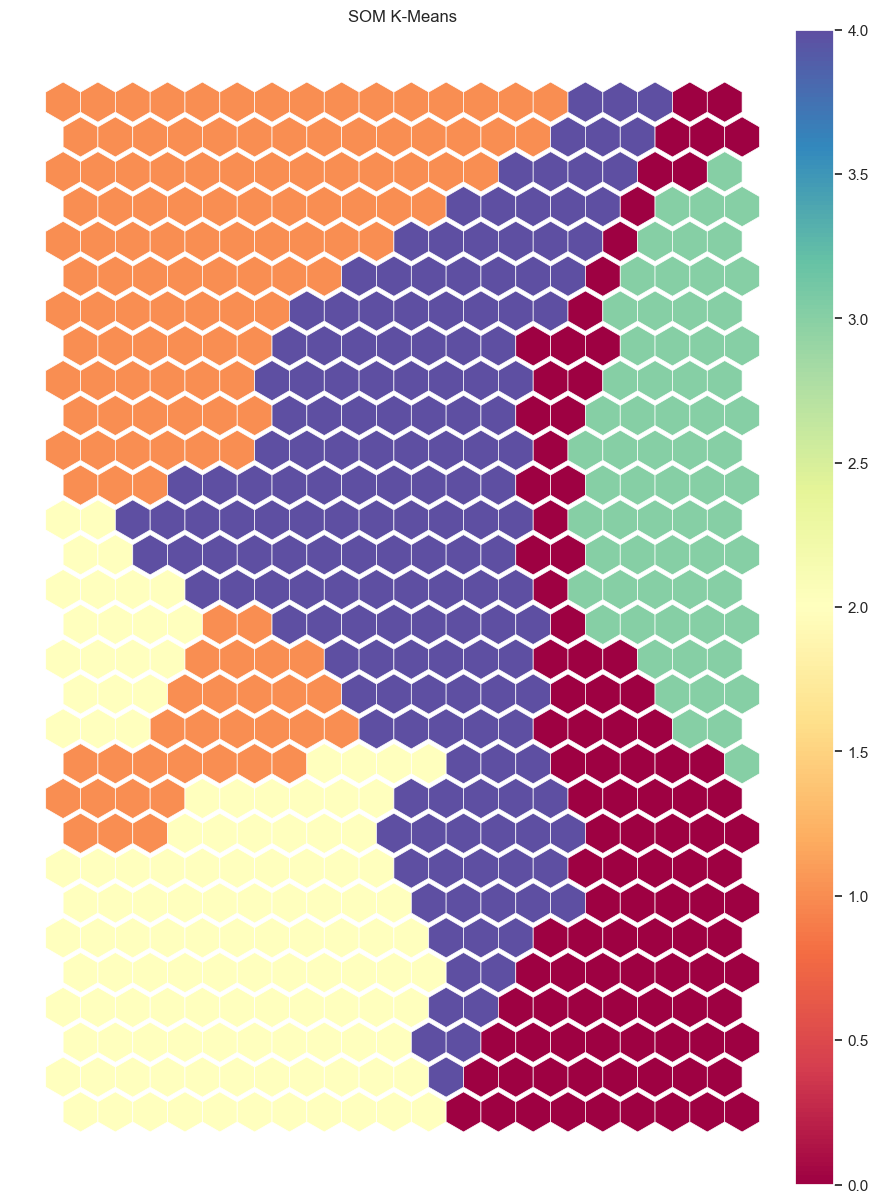

In [242]:
kmeans_som_matrix = kmeans_units_labels_all_value_5.reshape((20,30))

fig = plt.figure(figsize=(20,15))

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(kmeans_som_matrix))

fig = plot_hexagons(sm_all_value, fig, 
                    colornorm,
                    kmeans_som_matrix,
                    label="SOM K-Means",
                    cmap=cm.Spectral,
                    )

**Hierarchical on SOM units**

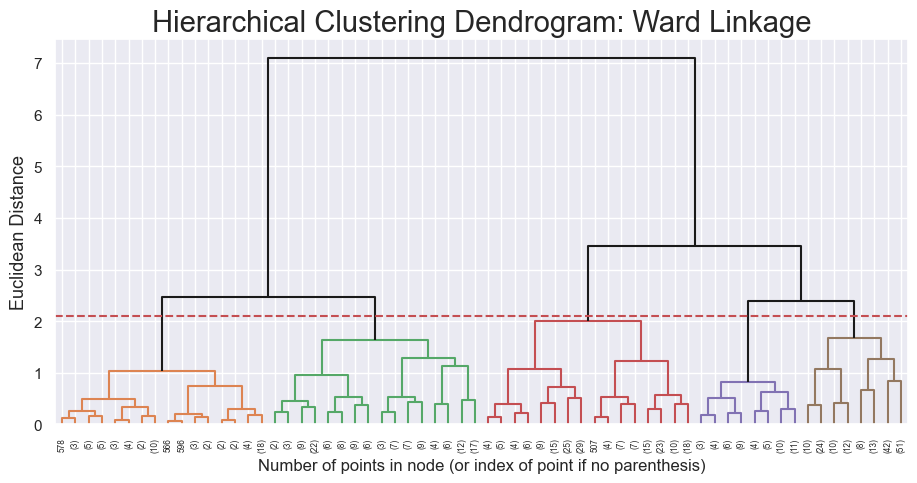

In [234]:
linkage_matrix= linkage(weights_all_value_df, method="ward")
plot_dendogram(linkage_matrix, y_threshold=2.1, distance="euclidean") 

In [253]:
hc_som_all_value_5 = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')

hc_units_labels_all_value_5 = hc_som_all_value_5.fit_predict(weights_all_value_df)

print(pd.Series(hc_units_labels_all_value_5).value_counts().sort_index())
r2_db = get_rsq(weights_all_value_df, value_segmentation, hc_units_labels_all_value_5)
print(f"SOM with Hierarchical R² score: {r2_db:.4f}")

0    182
1    130
2    170
3     66
4     52
Name: count, dtype: int64
SOM with Hierarchical R² score: 0.6862


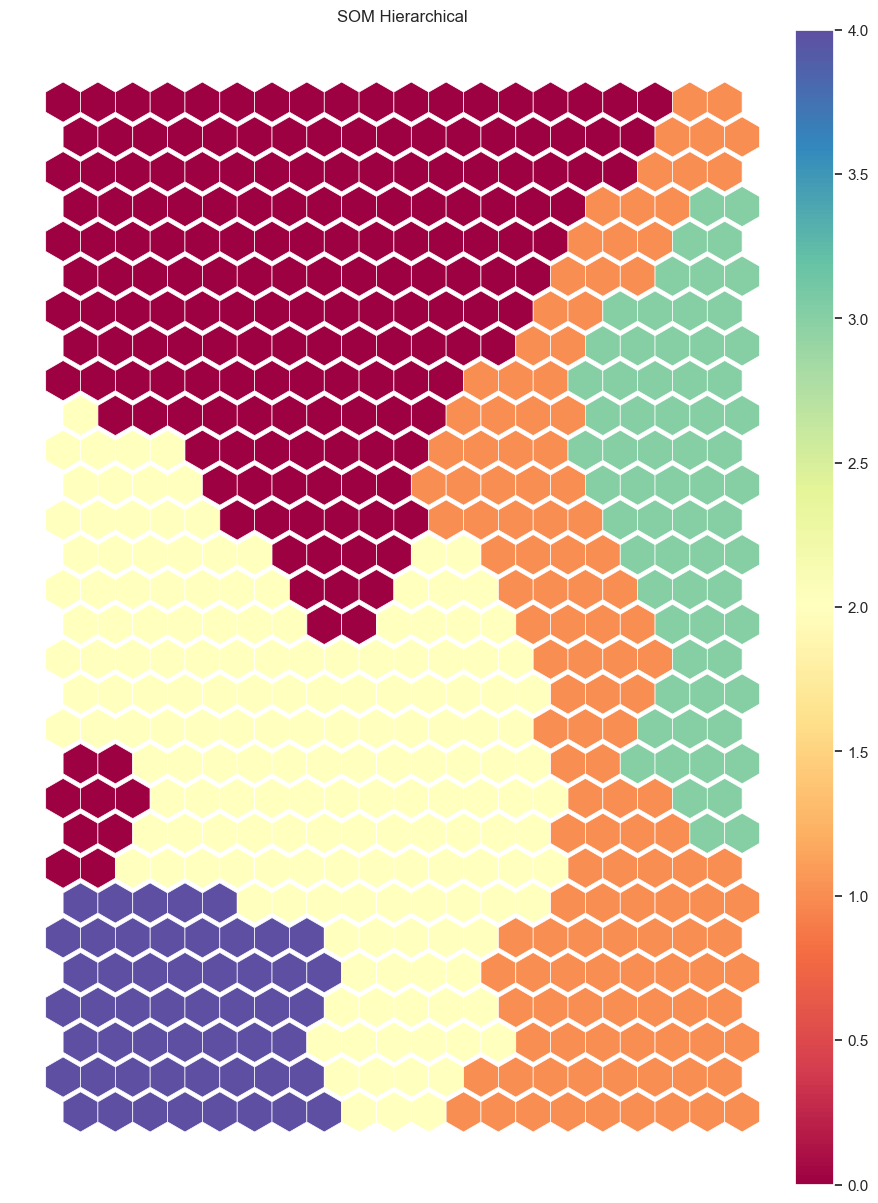

In [255]:
hc_som_matrix = hc_units_labels_all_value_5.reshape((20,30))

fig = plt.figure(figsize=(20,15))

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hc_som_matrix))

fig = plot_hexagons(sm_all_value, fig, 
                    colornorm,
                    hc_som_matrix,
                    label="SOM Hierarchical",
                    cmap=cm.Spectral,
                    )

The SOMS implementation with kmeans creates more balanceed clusters and achieves the higher result for the R2 so we will choose Kmeans.

**Behavioral Segmentation**

In [ ]:
# Train SOM for all customers - behavioural segmentation and get the quality metrics
sm_all_behav = train_som(df_all[behavioral_segmentation])

In [ ]:
# Plot component planes ( for all features see their value in the hexagons)
plot_component_planes(sm_all_behav, df_all[behavioral_segmentation])

In [ ]:
# Counts the number of data samples mapped to each neuron
plot_hitmap(sm_all_behav, df_all[behavioral_segmentation])

In [ ]:
# Plot U-Matrix ( distance between neighboring neurons)
plot_u_matrix(sm_all_behav)

#### **Active Costumers**

**Value Segmentation**

In [ ]:
# Train SOM for all customers - value segmentation and get the quality metrics
sm_active_value = train_som(df_active[value_segmentation])

In [ ]:
# Plot component planes ( for all features see their value in the hexagons)
plot_component_planes(sm_active_value, df_active[value_segmentation])

In [ ]:
# Counts the number of data samples mapped to each neuron
plot_hitmap(sm_active_value, df_active[value_segmentation])

In [ ]:
# Plot U-Matrix ( distance between neighboring neurons)
plot_u_matrix(sm_active_value)

**Behavioral Segmentation**

In [ ]:
# Train SOM for all customers - value segmentation and get the quality metrics
sm_active_behav = train_som(df_active[behavioral_segmentation])

In [ ]:
# Plot component planes ( for all features see their value in the hexagons)
plot_component_planes(sm_active_behav, df_active[behavioral_segmentation])

In [ ]:
# Counts the number of data samples mapped to each neuron
plot_hitmap(sm_active_behav, df_active[behavioral_segmentation])

In [ ]:
# Plot U-Matrix ( distance between neighboring neurons)
plot_u_matrix(sm_active_behav)